# BT4012 Fraud Analytics

## Project Group 11
Clara Tay Linn Qi

Kok Ze Xuan

Loo Hui Lin

Wee Zhen Qi, Tarcius

Wong Chung How, Brian

# Import Packages

In [1]:
#package versions

#!pip uninstall matplotlib
#!pip install matplotlib==3.4
#!pip uninstall hyperopt
#!pip install hyperopt==0.2.7

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from scipy import stats
import math
from matplotlib.pyplot import text
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn import linear_model
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval, Trials
from hyperopt.pyll import scope
from math import ceil, floor

import tensorflow
from tensorflow import keras
from keras.models import Sequential
import keras.backend as K
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.pipeline import make_pipeline
import keras_tuner as kt
from math import floor
from keras.layers import Dense


random_num = 100

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

# Import Data

In [4]:
train = pd.read_csv('Train-1542865627584.csv')
train_beneficiary = pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
train_inpatient = pd.read_csv('Train_Inpatientdata-1542865627584.csv')
train_outpatient = pd.read_csv('Train_Outpatientdata-1542865627584.csv')

# actually no need load the test datasets right
test = pd.read_csv('Test-1542969243754.csv')
test_beneficiary = pd.read_csv('Test_Beneficiarydata-1542969243754.csv')
test_inpatient = pd.read_csv('Test_Inpatientdata-1542969243754.csv')
test_outpatient = pd.read_csv('Test_Outpatientdata-1542969243754.csv')

In [5]:
train.head()

Provider PotentialFraud
0  PRV51001             No
1  PRV51003            Yes
2  PRV51004             No
3  PRV51005            Yes
4  PRV51007             No

In [6]:
train.value_counts()

Provider  PotentialFraud
PRV51001  No                1
PRV55516  No                1
PRV55527  No                1
PRV55525  No                1
PRV55523  No                1
                           ..
PRV53246  No                1
PRV53245  Yes               1
PRV53244  No                1
PRV53243  No                1
PRV57763  No                1
Length: 5410, dtype: int64

In [7]:
train_beneficiary.head()

BeneID         DOB  DOD  Gender  Race RenalDiseaseIndicator  State  \
0  BENE11001  1943-01-01  NaN       1     1                     0     39   
1  BENE11002  1936-09-01  NaN       2     1                     0     39   
2  BENE11003  1936-08-01  NaN       1     1                     0     52   
3  BENE11004  1922-07-01  NaN       1     1                     0     39   
4  BENE11005  1935-09-01  NaN       1     1                     0     24   

   County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ...  \
0     230                   12                   12  ...   
1     280                   12                   12  ...   
2     590                   12                   12  ...   
3     270                   12                   12  ...   
4     680                   12                   12  ...   

   ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  \
0                       1                     1                          1   
1                       2                     2                          2   
2                       2                     2                          1   
3                       2                     1                          1   
4                       2                     1                          2   

   ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis  \
0                         2                                1   
1                         2                                2   
2                         2                                2   
3                         1                                1   
4                         2                                2   

   ChronicCond_stroke  IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  \
0                   1                     36000                   3204   
1                   2                         0                      0   
2                   2                         0                      0   
3                   2                         0                      0   
4                   2                         0                      0   

   OPAnnualReimbursementAmt  OPAnnualDeductibleAmt  
0                        60                     70  
1                        30                     50  
2                        90                     40  
3                      1810                    760  
4                      1790                   1200  

[5 rows x 25 columns]

In [8]:
train_beneficiary.dtypes

BeneID                             object
DOB                                object
DOD                                object
Gender                              int64
Race                                int64
RenalDiseaseIndicator              object
State                               int64
County                              int64
NoOfMonths_PartACov                 int64
NoOfMonths_PartBCov                 int64
ChronicCond_Alzheimer               int64
ChronicCond_Heartfailure            int64
ChronicCond_KidneyDisease           int64
ChronicCond_Cancer                  int64
ChronicCond_ObstrPulmonary          int64
ChronicCond_Depression              int64
ChronicCond_Diabetes                int64
ChronicCond_IschemicHeart           int64
ChronicCond_Osteoporasis            int64
ChronicCond_rheumatoidarthritis     int64
ChronicCond_stroke                  int64
IPAnnualReimbursementAmt            int64
IPAnnualDeductibleAmt               int64
OPAnnualReimbursementAmt          

In [9]:
train_outpatient.shape

(517737, 27)

In [10]:
train_inpatient.head()

BeneID   ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11001  CLM46614   2009-04-12  2009-04-18  PRV55912   
1  BENE11001  CLM66048   2009-08-31  2009-09-02  PRV55907   
2  BENE11001  CLM68358   2009-09-17  2009-09-20  PRV56046   
3  BENE11011  CLM38412   2009-02-14  2009-02-22  PRV52405   
4  BENE11014  CLM63689   2009-08-13  2009-08-30  PRV56614   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                   26000          PHY390922                NaN   
1                    5000          PHY318495          PHY318495   
2                    5000          PHY372395                NaN   
3                    5000          PHY369659          PHY392961   
4                   10000          PHY379376          PHY398258   

  OtherPhysician AdmissionDt  ... ClmDiagnosisCode_7  ClmDiagnosisCode_8  \
0            NaN  2009-04-12  ...               2724               19889   
1            NaN  2009-08-31  ...                NaN                 NaN   
2      PHY324689  2009-09-17  ...                NaN                 NaN   
3      PHY349768  2009-02-14  ...              25062               40390   
4            NaN  2009-08-13  ...               5119               29620   

  ClmDiagnosisCode_9 ClmDiagnosisCode_10 ClmProcedureCode_1  \
0               5849                 NaN                NaN   
1                NaN                 NaN             7092.0   
2                NaN                 NaN                NaN   
3               4019                 NaN              331.0   
4              20300                 NaN             3893.0   

  ClmProcedureCode_2 ClmProcedureCode_3 ClmProcedureCode_4 ClmProcedureCode_5  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

  ClmProcedureCode_6  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 30 columns]

In [11]:
train_inpatient.dtypes

BeneID                     object
ClaimID                    object
ClaimStartDt               object
ClaimEndDt                 object
Provider                   object
InscClaimAmtReimbursed      int64
AttendingPhysician         object
OperatingPhysician         object
OtherPhysician             object
AdmissionDt                object
ClmAdmitDiagnosisCode      object
DeductibleAmtPaid         float64
DischargeDt                object
DiagnosisGroupCode         object
ClmDiagnosisCode_1         object
ClmDiagnosisCode_2         object
ClmDiagnosisCode_3         object
ClmDiagnosisCode_4         object
ClmDiagnosisCode_5         object
ClmDiagnosisCode_6         object
ClmDiagnosisCode_7         object
ClmDiagnosisCode_8         object
ClmDiagnosisCode_9         object
ClmDiagnosisCode_10        object
ClmProcedureCode_1        float64
ClmProcedureCode_2        float64
ClmProcedureCode_3        float64
ClmProcedureCode_4        float64
ClmProcedureCode_5        float64
ClmProcedureCo

In [12]:
train_outpatient.head()

BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11002  CLM624349   2009-10-11  2009-10-11  PRV56011   
1  BENE11003  CLM189947   2009-02-12  2009-02-12  PRV57610   
2  BENE11003  CLM438021   2009-06-27  2009-06-27  PRV57595   
3  BENE11004  CLM121801   2009-01-06  2009-01-06  PRV56011   
4  BENE11004  CLM150998   2009-01-22  2009-01-22  PRV56011   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                      30          PHY326117                NaN   
1                      80          PHY362868                NaN   
2                      10          PHY328821                NaN   
3                      40          PHY334319                NaN   
4                     200          PHY403831                NaN   

  OtherPhysician ClmDiagnosisCode_1  ... ClmDiagnosisCode_9  \
0            NaN              78943  ...                NaN   
1            NaN               6115  ...                NaN   
2            NaN               2723  ...                NaN   
3            NaN              71988  ...                NaN   
4            NaN              82382  ...                NaN   

  ClmDiagnosisCode_10 ClmProcedureCode_1 ClmProcedureCode_2  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   

  ClmProcedureCode_3 ClmProcedureCode_4 ClmProcedureCode_5 ClmProcedureCode_6  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

  DeductibleAmtPaid  ClmAdmitDiagnosisCode  
0                 0                  56409  
1                 0                  79380  
2                 0                    NaN  
3                 0                    NaN  
4                 0                  71947  

[5 rows x 27 columns]

In [13]:
train_outpatient.dtypes

BeneID                     object
ClaimID                    object
ClaimStartDt               object
ClaimEndDt                 object
Provider                   object
InscClaimAmtReimbursed      int64
AttendingPhysician         object
OperatingPhysician         object
OtherPhysician             object
ClmDiagnosisCode_1         object
ClmDiagnosisCode_2         object
ClmDiagnosisCode_3         object
ClmDiagnosisCode_4         object
ClmDiagnosisCode_5         object
ClmDiagnosisCode_6         object
ClmDiagnosisCode_7         object
ClmDiagnosisCode_8         object
ClmDiagnosisCode_9         object
ClmDiagnosisCode_10        object
ClmProcedureCode_1        float64
ClmProcedureCode_2        float64
ClmProcedureCode_3        float64
ClmProcedureCode_4        float64
ClmProcedureCode_5        float64
ClmProcedureCode_6        float64
DeductibleAmtPaid           int64
ClmAdmitDiagnosisCode      object
dtype: object

In [14]:
test.head()

Provider
0  PRV51002
1  PRV51006
2  PRV51009
3  PRV51010
4  PRV51018

In [15]:
test_beneficiary.head()

BeneID         DOB         DOD  Gender  Race RenalDiseaseIndicator  \
0  BENE11001  1943-01-01         NaN       1     1                     0   
1  BENE11007  1940-09-01  2009-12-01       1     2                     0   
2  BENE11010  1936-07-01         NaN       2     1                     0   
3  BENE11011  1914-03-01         NaN       2     2                     0   
4  BENE11014  1938-04-01         NaN       2     1                     Y   

   State  County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ...  \
0     39     230                   12                   12  ...   
1     45     610                   12                   12  ...   
2     41      30                   12                   12  ...   
3      1     360                   12                   12  ...   
4     45     780                   12                   12  ...   

   ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  \
0                       1                     1                          1   
1                       2                     1                          2   
2                       2                     1                          1   
3                       1                     1                          2   
4                       1                     2                          1   

   ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis  \
0                         2                                1   
1                         1                                1   
2                         1                                2   
3                         2                                1   
4                         2                                2   

   ChronicCond_stroke  IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  \
0                   1                     36000                   3204   
1                   2                         0                      0   
2                   2                         0                      0   
3                   1                      5000                   1068   
4                   2                     21260                   2136   

   OPAnnualReimbursementAmt  OPAnnualDeductibleAmt  
0                        60                     70  
1                      1490                    160  
2                      1170                    660  
3                       250                    320  
4                       120                    100  

[5 rows x 25 columns]

In [16]:
test_inpatient.head()

BeneID   ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11014  CLM67387   2009-09-09  2009-09-16  PRV57070   
1  BENE11017  CLM31237   2008-12-25  2009-01-08  PRV54750   
2  BENE11026  CLM78930   2009-12-09  2009-12-13  PRV53758   
3  BENE11031  CLM56810   2009-06-23  2009-07-06  PRV55825   
4  BENE11085  CLM34625   2009-01-20  2009-01-31  PRV52338   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                    9000          PHY317786          PHY427017   
1                   14000          PHY314656          PHY426644   
2                    2000          PHY349495                NaN   
3                   16000          PHY429538          PHY371893   
4                   19000          PHY397161                NaN   

  OtherPhysician AdmissionDt  ... ClmDiagnosisCode_7  ClmDiagnosisCode_8  \
0            NaN  2009-09-09  ...               5990                 570   
1            NaN  2008-12-25  ...               4549               29570   
2            NaN  2009-12-09  ...              78650                7813   
3            NaN  2009-06-23  ...               4254               41400   
4            NaN  2009-01-20  ...              V6109                7242   

  ClmDiagnosisCode_9 ClmDiagnosisCode_10 ClmProcedureCode_1  \
0              41071                4280             4443.0   
1              34831                 NaN             5551.0   
2               4254                 NaN                NaN   
3               5849               41401             8152.0   
4                NaN                 NaN                NaN   

  ClmProcedureCode_2 ClmProcedureCode_3 ClmProcedureCode_4 ClmProcedureCode_5  \
0             5849.0                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3             3320.0                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

  ClmProcedureCode_6  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 30 columns]

In [17]:
test_outpatient.head()

BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11001  CLM392397   2009-06-02  2009-06-02  PRV55962   
1  BENE11001  CLM430760   2009-06-23  2009-06-23  PRV56112   
2  BENE11007  CLM233081   2009-03-07  2009-03-07  PRV56979   
3  BENE11007  CLM496381   2009-07-29  2009-07-29  PRV56573   
4  BENE11007  CLM521391   2009-08-12  2009-08-12  PRV56573   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                      30          PHY347633                NaN   
1                      30          PHY381777                NaN   
2                     200          PHY425311                NaN   
3                      10          PHY393253          PHY347995   
4                      10          PHY417685                NaN   

  OtherPhysician ClmDiagnosisCode_1  ... ClmDiagnosisCode_9  \
0      PHY347633              V5832  ...                NaN   
1      PHY381777               9594  ...                NaN   
2      PHY425311               7248  ...                NaN   
3            NaN              58889  ...                NaN   
4      PHY382041               V666  ...                NaN   

  ClmDiagnosisCode_10 ClmProcedureCode_1 ClmProcedureCode_2  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   

  ClmProcedureCode_3 ClmProcedureCode_4 ClmProcedureCode_5 ClmProcedureCode_6  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

  DeductibleAmtPaid  ClmAdmitDiagnosisCode  
0                 0                    NaN  
1                 0                    NaN  
2                 0                    NaN  
3                 0                   5939  
4                 0                    NaN  

[5 rows x 27 columns]

As we do not have a validation set / test set with the true labels, we will just be working with the train set and create the train/test splits from there. We will merge all the datasets, split the validation set then break the datasets down to their constituents again for neater EDA and Feature Engineering

### Dataset merging and Train/Evaluation split

#### Difference between inpatient and outpatient columns

In [18]:
train_inpatient.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6'],
      dtype='object')

In [19]:
train_outpatient.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')

In [20]:
for i in train_inpatient.columns.tolist(): 
  if i not in train_outpatient.columns.tolist():
    print(i)

AdmissionDt
DischargeDt
DiagnosisGroupCode


#### Merge inpatient and outpatient

In [21]:
train_inpatient

BeneID   ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0       BENE11001  CLM46614   2009-04-12  2009-04-18  PRV55912   
1       BENE11001  CLM66048   2009-08-31  2009-09-02  PRV55907   
2       BENE11001  CLM68358   2009-09-17  2009-09-20  PRV56046   
3       BENE11011  CLM38412   2009-02-14  2009-02-22  PRV52405   
4       BENE11014  CLM63689   2009-08-13  2009-08-30  PRV56614   
...           ...       ...          ...         ...       ...   
40469  BENE159167  CLM69886   2009-09-28  2009-10-02  PRV53671   
40470  BENE159175  CLM74504   2009-11-03  2009-11-06  PRV54981   
40471  BENE159177  CLM76485   2009-11-18  2009-11-22  PRV56588   
40472  BENE159177  CLM79949   2009-12-17  2009-12-18  PRV56575   
40473  BENE159188  CLM69948   2009-09-28  2009-10-06  PRV54765   

       InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                       26000          PHY390922                NaN   
1                        5000          PHY318495          PHY318495   
2                        5000          PHY372395                NaN   
3                        5000          PHY369659          PHY392961   
4                       10000          PHY379376          PHY398258   
...                       ...                ...                ...   
40469                    7000          PHY345332          PHY319565   
40470                    4000          PHY342806          PHY365497   
40471                    3000          PHY423220          PHY332752   
40472                    5000          PHY353156                NaN   
40473                   15000          PHY431177          PHY352941   

      OtherPhysician AdmissionDt  ... ClmDiagnosisCode_7  ClmDiagnosisCode_8  \
0                NaN  2009-04-12  ...               2724               19889   
1                NaN  2009-08-31  ...                NaN                 NaN   
2          PHY324689  2009-09-17  ...                NaN                 NaN   
3          PHY349768  2009-02-14  ...              25062               40390   
4                NaN  2009-08-13  ...               5119               29620   
...              ...         ...  ...                ...                 ...   
40469            NaN  2009-09-28  ...              79092               70704   
40470            NaN  2009-11-03  ...              49122                4254   
40471            NaN  2009-11-18  ...              71534               71590   
40472            NaN  2009-12-17  ...               4263                0414   
40473            NaN  2009-09-28  ...               4019                2800   

      ClmDiagnosisCode_9 ClmDiagnosisCode_10 ClmProcedureCode_1  \
0                   5849                 NaN                NaN   
1                    NaN                 NaN             7092.0   
2                    NaN                 NaN                NaN   
3                   4019                 NaN              331.0   
4                  20300                 NaN             3893.0   
...                  ...                 ...                ...   
40469               2869                4148             9904.0   
40470               5990                 NaN             8605.0   
40471              V4502                 NaN             9390.0   
40472              41400                 NaN                NaN   
40473              27801                 NaN             1733.0   

      ClmProcedureCode_2 ClmProcedureCode_3 ClmProcedureCode_4  \
0                    NaN                NaN                NaN   
1                    NaN                NaN                NaN   
2                    NaN                NaN                NaN   
3                    NaN                NaN                NaN   
4                    NaN                NaN                NaN   
...                  ...                ...                ...   
40469                NaN                NaN                NaN   
40470                NaN                NaN                NaN   
40471

In [22]:
train_outpatient

BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0        BENE11002  CLM624349   2009-10-11  2009-10-11  PRV56011   
1        BENE11003  CLM189947   2009-02-12  2009-02-12  PRV57610   
2        BENE11003  CLM438021   2009-06-27  2009-06-27  PRV57595   
3        BENE11004  CLM121801   2009-01-06  2009-01-06  PRV56011   
4        BENE11004  CLM150998   2009-01-22  2009-01-22  PRV56011   
...            ...        ...          ...         ...       ...   
517732  BENE159198  CLM510792   2009-08-06  2009-08-06  PRV53699   
517733  BENE159198  CLM551294   2009-08-29  2009-08-29  PRV53702   
517734  BENE159198  CLM596444   2009-09-24  2009-09-24  PRV53676   
517735  BENE159198  CLM636992   2009-10-18  2009-10-18  PRV53689   
517736  BENE159198  CLM686139   2009-11-17  2009-11-18  PRV53689   

        InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                           30          PHY326117                NaN   
1                           80          PHY362868                NaN   
2                           10          PHY328821                NaN   
3                           40          PHY334319                NaN   
4                          200          PHY403831                NaN   
...                        ...                ...                ...   
517732                     800          PHY364188          PHY364188   
517733                     400          PHY423019          PHY332284   
517734                      60          PHY361063                NaN   
517735                      70          PHY403198                NaN   
517736                      80          PHY419379                NaN   

       OtherPhysician ClmDiagnosisCode_1  ... ClmDiagnosisCode_9  \
0                 NaN              78943  ...                NaN   
1                 NaN               6115  ...                NaN   
2                 NaN               2723  ...                NaN   
3                 NaN              71988  ...                NaN   
4                 NaN              82382  ...                NaN   
...               ...                ...  ...                ...   
517732      PHY385752               2163  ...                NaN   
517733            NaN              07041  ...                NaN   
517734            NaN               V570  ...                NaN   
517735      PHY419379                NaN  ...                NaN   
517736      PHY419379              78900  ...                NaN   

       ClmDiagnosisCode_10 ClmProcedureCode_1 ClmProcedureCode_2  \
0                      NaN                NaN                NaN   
1                      NaN                NaN                NaN   
2                      NaN                NaN                NaN   
3                      NaN                NaN                NaN   
4                      NaN                NaN                NaN   
...                    ...                ...                ...   
517732                 NaN                NaN                NaN   
517733                 NaN                NaN                NaN   
517734                 NaN                NaN                NaN   
517735                 NaN                NaN                NaN   
517736                 NaN                NaN                NaN   

       ClmProcedureCode_3 ClmProcedureCode_4 ClmProcedureCode_5  \
0                     NaN                NaN                NaN   
1                     NaN                NaN                NaN   
2                     NaN                NaN                NaN   
3                     NaN                NaN                NaN   
4                     NaN                NaN                NaN   
...                   ...                ...                ...   
517732                NaN                NaN                NaN   
517733                NaN                NaN                NaN   
517734                NaN                NaN                NaN   
517735                NaN 

In [23]:
#merge inpatient & outpatient dataset
train_patient = pd.concat([train_inpatient,train_outpatient])
train_patient.shape

(558211, 30)

#### Merge Patient data and Beneficiary

In [24]:
train_patient_beneficiary = pd.merge(train_patient, train_beneficiary,on='BeneID',how='inner')

#### Merge patient beneficiary with provider data

In [25]:
train.head()

Provider PotentialFraud
0  PRV51001             No
1  PRV51003            Yes
2  PRV51004             No
3  PRV51005            Yes
4  PRV51007             No

In [26]:
#overall df
df = pd.merge(train_patient_beneficiary,train,on='Provider',how='inner')
df.shape

(558211, 55)

In [27]:
x = df.drop(columns=['PotentialFraud']).copy()
y = df['PotentialFraud']

# Splitting to get test set

In [28]:
x.shape

(558211, 54)

In [29]:
y.shape

(558211,)

In [30]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits = 1, test_size = 0.25,random_state=1)
for train_index, test_index in gss.split(x, y,groups=x['Provider']):
  X_train, X_test = x.iloc[train_index].reset_index(), x.iloc[test_index].reset_index()
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")

valid = X_test.copy()
valid['PotentialFraud'] = y_test
df = X_train.copy()
df['PotentialFraud'] = y_train

X_train : (428756, 55)
X_test : (129455, 55)
y_train : (428756,)
y_test : (129455,)


In [31]:
#verify that BeneIDs are not mixed between the datasets, if no printing output means correct
for i in (df['BeneID'].unique()):
  if i in valid['BeneID']:
    print("fail")

In [32]:
df['PotentialFraud'].value_counts()

No     171117
Yes    161528
Name: PotentialFraud, dtype: int64

In [33]:
valid.shape

(129455, 56)

In [34]:
df.shape

(428756, 56)

We have a total of 558,211 observations.
418,658 observations for training, 139,553 observations for validation 

#### Breakdown datasets again for EDA and Feature Engineering

In [35]:
df_labels = df[['Provider','PotentialFraud']].drop_duplicates()
df_patient = df[['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'PotentialFraud']]
df_beneficiary = df[['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt']].drop_duplicates()


# Exploratory Data Analysis


## Functions

In [36]:
# https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
def percentage_with_hue(plot, feature, Number_of_categories, hue_categories, x_pos=0, y_pos=0, fontsize = 12):
    '''
    This function prints percentage of a barplot when plotted with hue.
    '''
    # get the height of each bar
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            # calculate percentage of the category
            percentage = '{:.2f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            # set the x and y position of the percentage value to look good
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 + x_pos
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() + y_pos
            ax.annotate(percentage, (x, y), fontsize = fontsize)
    plt.show()
    
def percentage_without_hue(ax, feature, x_pos=0, y_pos=0, fontsize = 12 ):
    '''
    This function prints percentage of a barplot when plotted without hue.
    '''
    total = len(feature)
    for p in ax.patches:
        # calculate percentage of the category
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2 + x_pos # To adjust the position of the percentage value
        y = p.get_y() + p.get_height() + y_pos # To adjust the position of the percentage value
        ax.annotate(percentage, (x, y),ha='center', size = fontsize)
    plt.show()

## Beneficiary Dataset (df_beneficiary)

### Overview

In [37]:
pd.set_option('display.max_columns', None) #see all columns with data
df_beneficiary.head()

BeneID         DOB  DOD  Gender  Race RenalDiseaseIndicator  State  \
0  BENE11001  1943-01-01  NaN       1     1                     0     39   
1  BENE16973  1932-05-01  NaN       1     1                     0     39   
2  BENE17521  1913-12-01  NaN       2     1                     0     39   
3  BENE21718  1922-10-01  NaN       1     1                     0     39   
4  BENE22934  1930-07-01  NaN       2     1                     0     39   

   County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ChronicCond_Alzheimer  \
0     230                   12                   12                      1   
1     310                   12                   12                      1   
2     230                   12                   12                      1   
3     600                   12                   12                      2   
4     280                   12                   12                      2   

   ChronicCond_Heartfailure  ChronicCond_KidneyDisease  ChronicCond_Cancer  \
0                         2                          1                   2   
1                         1                          1                   2   
2                         1                          1                   2   
3                         2                          2                   2   
4                         1                          2                   2   

   ChronicCond_ObstrPulmonary  ChronicCond_Depression  ChronicCond_Diabetes  \
0                           2                       1                     1   
1                           2                       2                     2   
2                           1                       2                     2   
3                           2                       2                     2   
4                           1                       2                     1   

   ChronicCond_IschemicHeart  ChronicCond_Osteoporasis  \
0                          1                         2   
1                          1                         2   
2                          1                         2   
3                          1                         1   
4                          1                         1   

   ChronicCond_rheumatoidarthritis  ChronicCond_stroke  \
0                                1                   1   
1                                2                   2   
2                                2                   2   
3                                2                   2   
4                                1                   2   

   IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  OPAnnualReimbursementAmt  \
0                     36000                   3204                        60   
1                     24000                   2136                       450   
2                     19000                   1068                       100   
3                     17000                   1068                      1050   
4                     27000                   2136                       450   

   OPAnnualDeductibleAmt  
0                     70  
1                    200  
2                     20  
3                    540  
4                    160

In [38]:
df_beneficiary.dtypes

BeneID                             object
DOB                                object
DOD                                object
Gender                              int64
Race                                int64
RenalDiseaseIndicator              object
State                               int64
County                              int64
NoOfMonths_PartACov                 int64
NoOfMonths_PartBCov                 int64
ChronicCond_Alzheimer               int64
ChronicCond_Heartfailure            int64
ChronicCond_KidneyDisease           int64
ChronicCond_Cancer                  int64
ChronicCond_ObstrPulmonary          int64
ChronicCond_Depression              int64
ChronicCond_Diabetes                int64
ChronicCond_IschemicHeart           int64
ChronicCond_Osteoporasis            int64
ChronicCond_rheumatoidarthritis     int64
ChronicCond_stroke                  int64
IPAnnualReimbursementAmt            int64
IPAnnualDeductibleAmt               int64
OPAnnualReimbursementAmt          

In [39]:
print(f"Total number of unique beneficiaries: {df_beneficiary['BeneID'].nunique()}")

Total number of unique beneficiaries: 125323


### Descriptive Statistics Exploration

#### Exploring Conditions

In [40]:
conditions = ['RenalDiseaseIndicator','ChronicCond_Alzheimer','ChronicCond_Heartfailure','ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
              'ChronicCond_ObstrPulmonary','ChronicCond_Depression','ChronicCond_Diabetes','ChronicCond_IschemicHeart','ChronicCond_Osteoporasis',
              'ChronicCond_rheumatoidarthritis','ChronicCond_stroke']

#### Numerical Variables

In [41]:
numerical_variables = ['IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']

In [42]:
descriptive_stats = df_beneficiary[numerical_variables].describe().loc[['mean', 'std', '50%']].transpose()
descriptive_stats.columns = ['mean', 'std', 'median']
descriptive_stats['mode'] = df_beneficiary[numerical_variables].mode().transpose()[0]
descriptive_stats['mad'] = [stats.median_abs_deviation(df_beneficiary[x]) for x in numerical_variables]
descriptive_stats['kurtosis'] = [stats.kurtosis(df_beneficiary[x], fisher=False) for x in numerical_variables]
descriptive_stats['excess kurtosis'] = [stats.kurtosis(df_beneficiary[x], fisher=True) for x in numerical_variables]
descriptive_stats['skewness'] = [stats.skew(df_beneficiary[x]) for x in numerical_variables]
descriptive_stats

mean          std  median  mode    mad  \
IPAnnualReimbursementAmt  3846.098242  9812.304999     0.0     0    0.0   
IPAnnualDeductibleAmt      419.962992   981.561530     0.0     0    0.0   
OPAnnualReimbursementAmt  1364.255324  2572.342280   610.0     0  510.0   
OPAnnualDeductibleAmt      396.415383   664.352340   190.0     0  170.0   

                            kurtosis  excess kurtosis   skewness  
IPAnnualReimbursementAmt   32.538406        29.538406   4.522949  
IPAnnualDeductibleAmt     262.361489       259.361489  10.290568  
OPAnnualReimbursementAmt  156.827525       153.827525   8.464913  
OPAnnualDeductibleAmt      48.545971        45.545971   5.327465

mean               3846.098242
std                9812.304999
median                0.000000
mode                  0.000000
mad                   0.000000
kurtosis             32.538406
excess kurtosis      29.538406
skewness              4.522949
Name: IPAnnualReimbursementAmt, dtype: float64


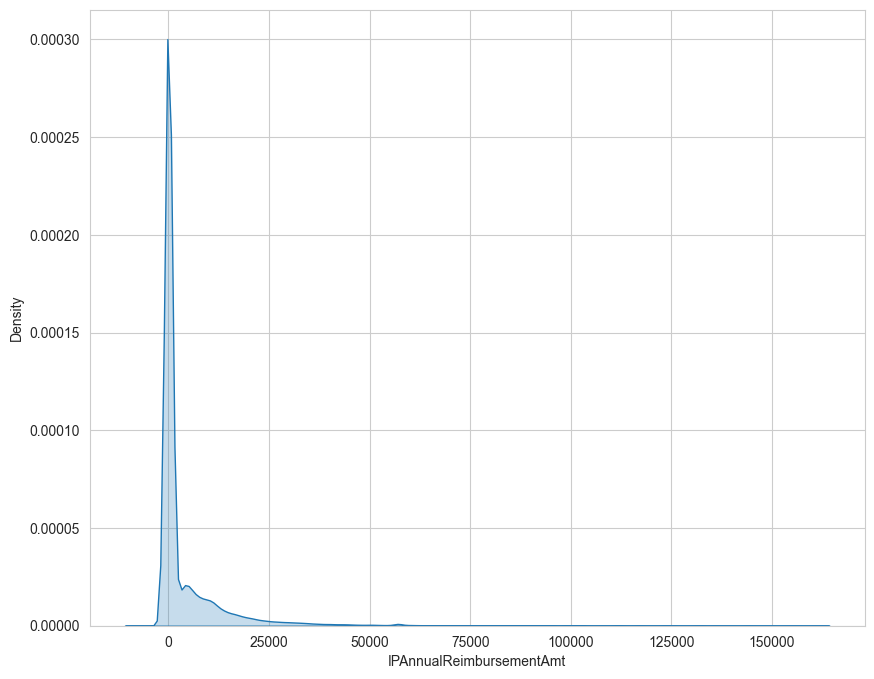

mean               419.962992
std                981.561530
median               0.000000
mode                 0.000000
mad                  0.000000
kurtosis           262.361489
excess kurtosis    259.361489
skewness            10.290568
Name: IPAnnualDeductibleAmt, dtype: float64


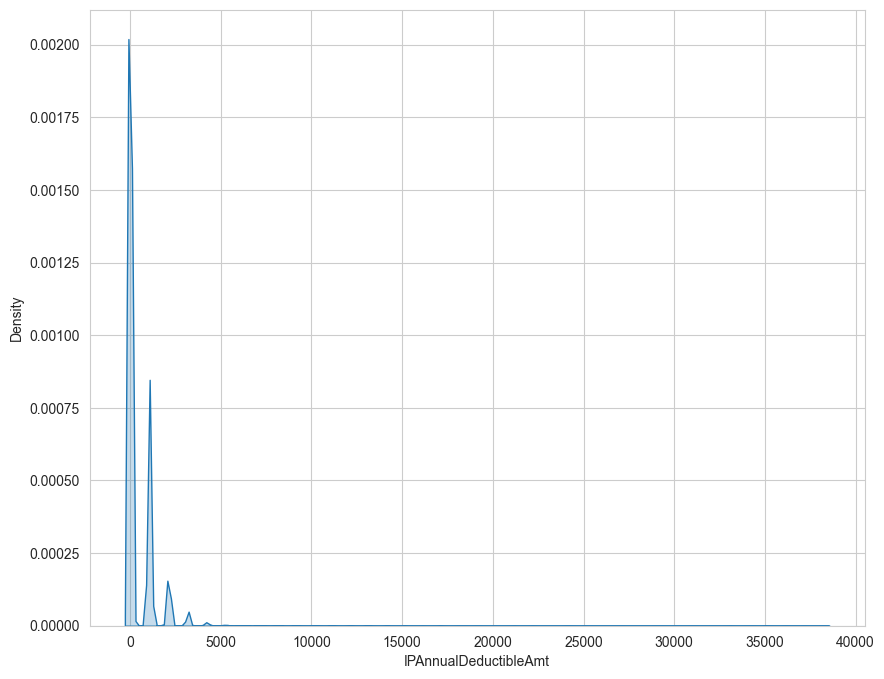

mean               1364.255324
std                2572.342280
median              610.000000
mode                  0.000000
mad                 510.000000
kurtosis            156.827525
excess kurtosis     153.827525
skewness              8.464913
Name: OPAnnualReimbursementAmt, dtype: float64


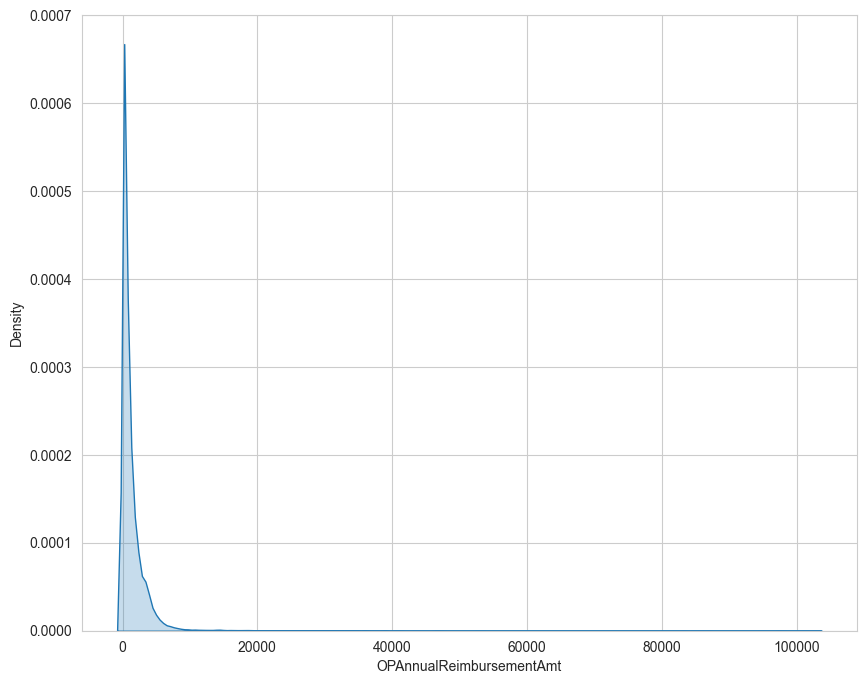

mean               396.415383
std                664.352340
median             190.000000
mode                 0.000000
mad                170.000000
kurtosis            48.545971
excess kurtosis     45.545971
skewness             5.327465
Name: OPAnnualDeductibleAmt, dtype: float64


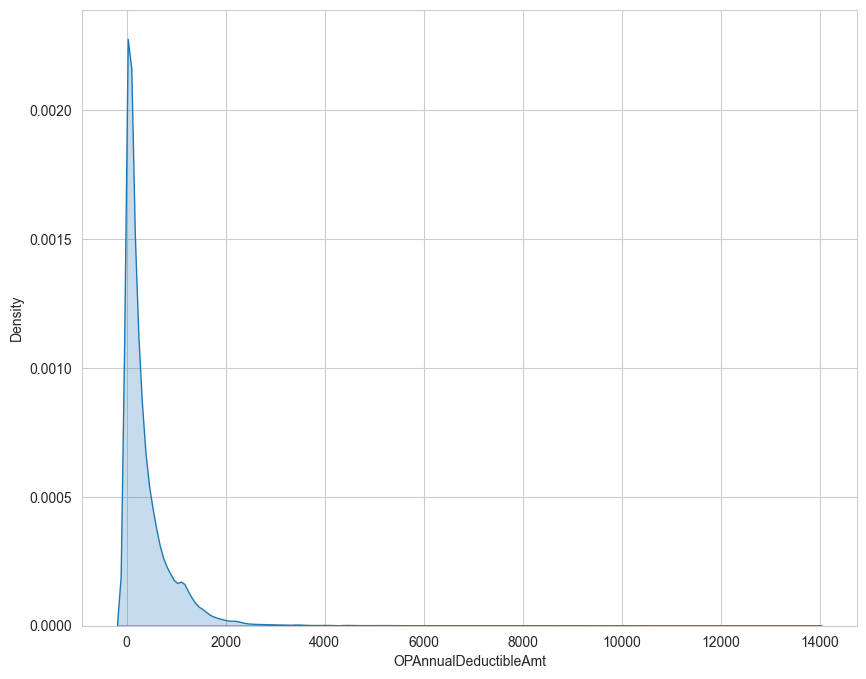

In [43]:
for var in numerical_variables:
  fig = plt.figure(figsize = (10, 8))
  print (descriptive_stats.loc[var])
  sns.kdeplot(df_beneficiary[var], fill=True)
  plt.show()

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\2211057208.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes[index] = plt.subplot(2, 2, index+1, label=str(index))


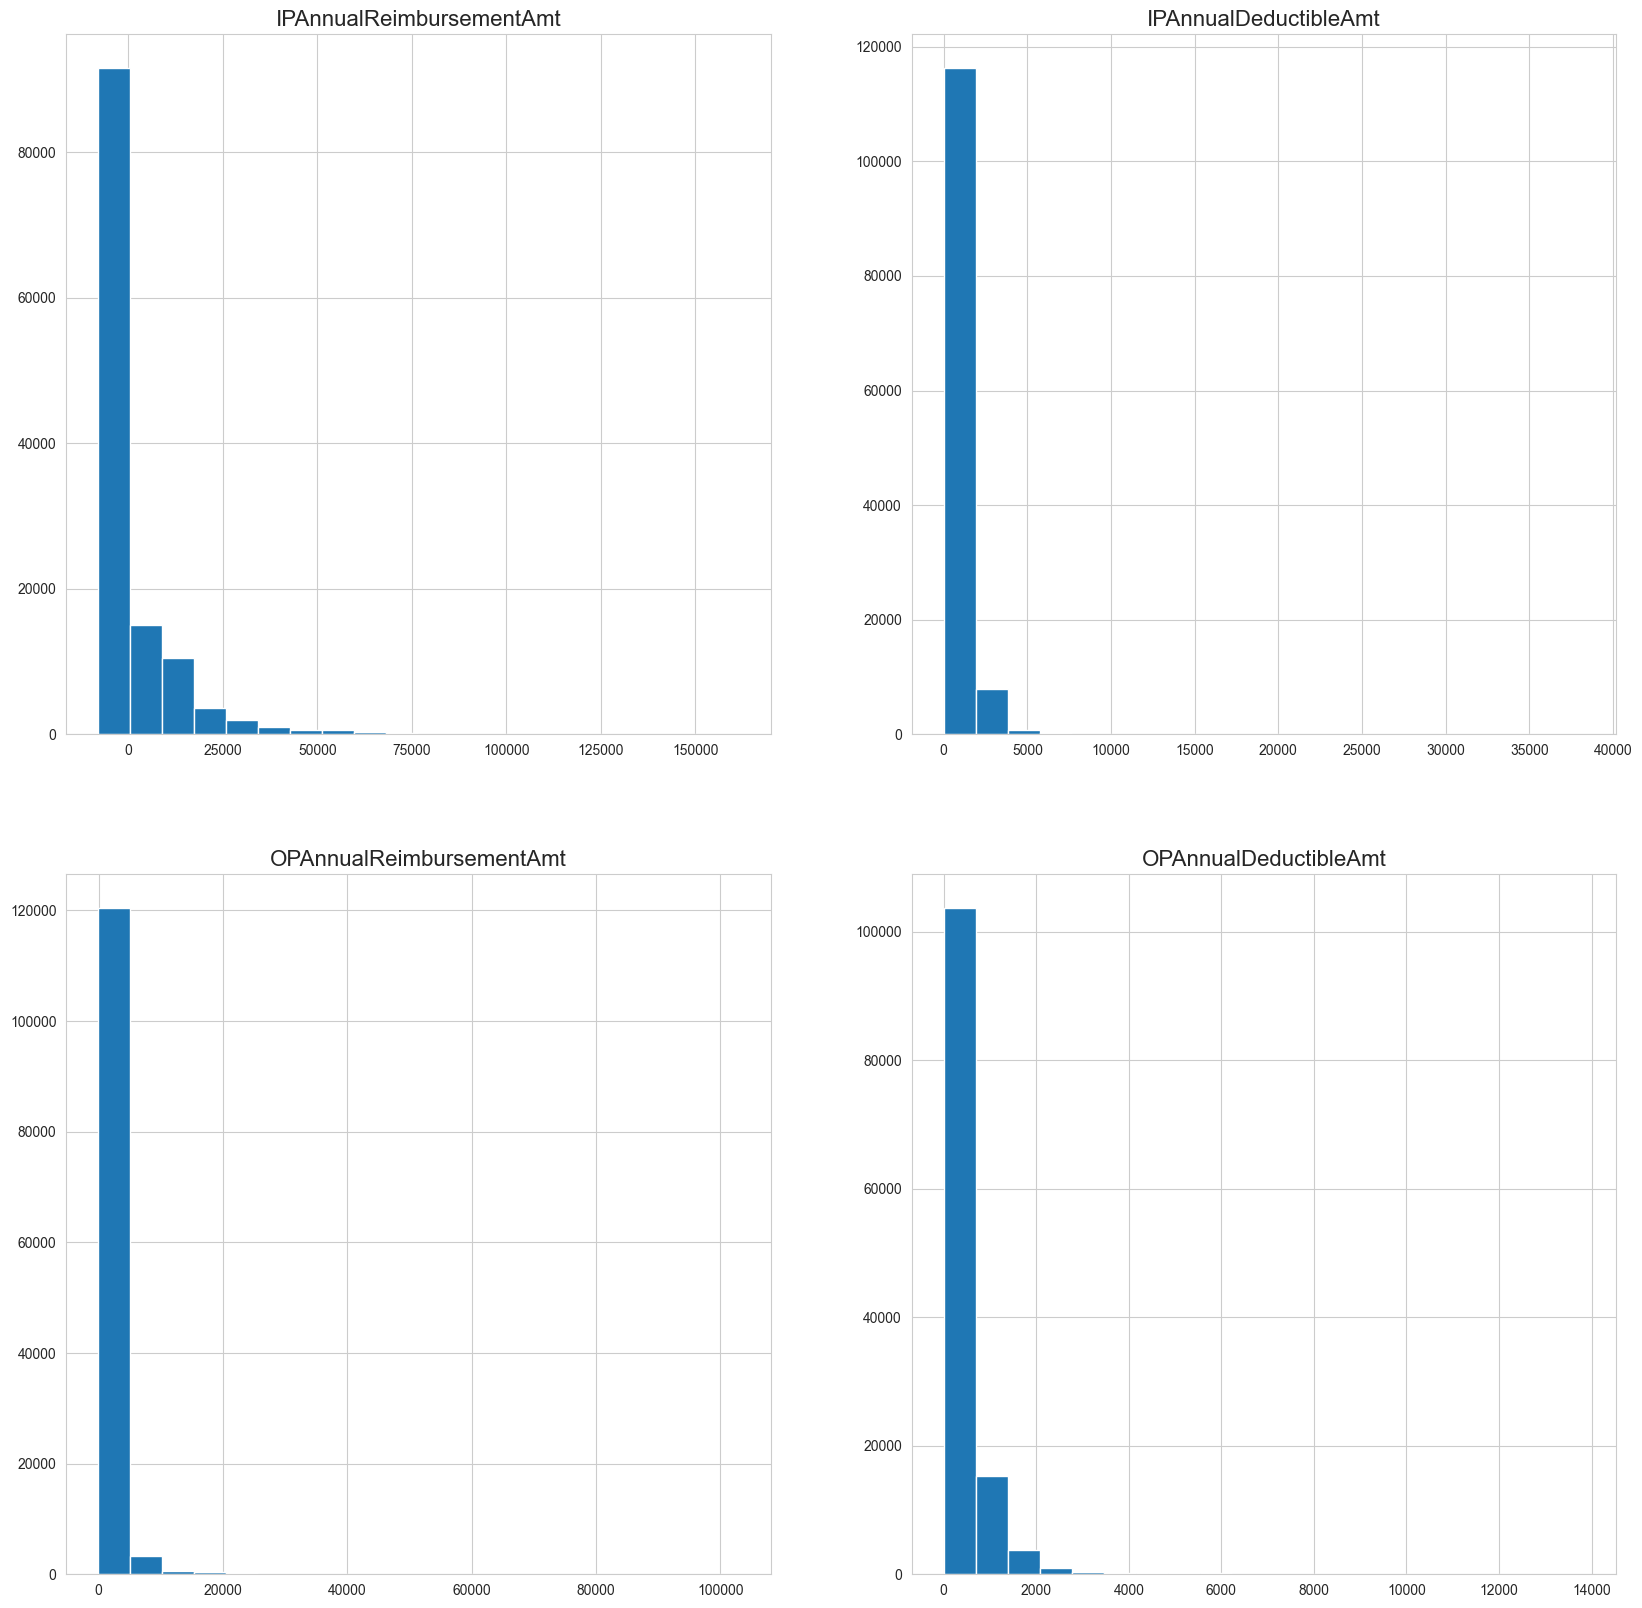

In [44]:
plt.figure(figsize=(20,20))
plt.subplot(321)

axes = [None] * len(numerical_variables)

for index, name in enumerate(df[numerical_variables].columns):
    axes[index] = plt.subplot(2, 2, index+1, label=str(index))
    df_beneficiary[name].hist(ax=axes[index], bins=20)
    axes[index].set_title(name, fontsize=16)

In [45]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\2936246840.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


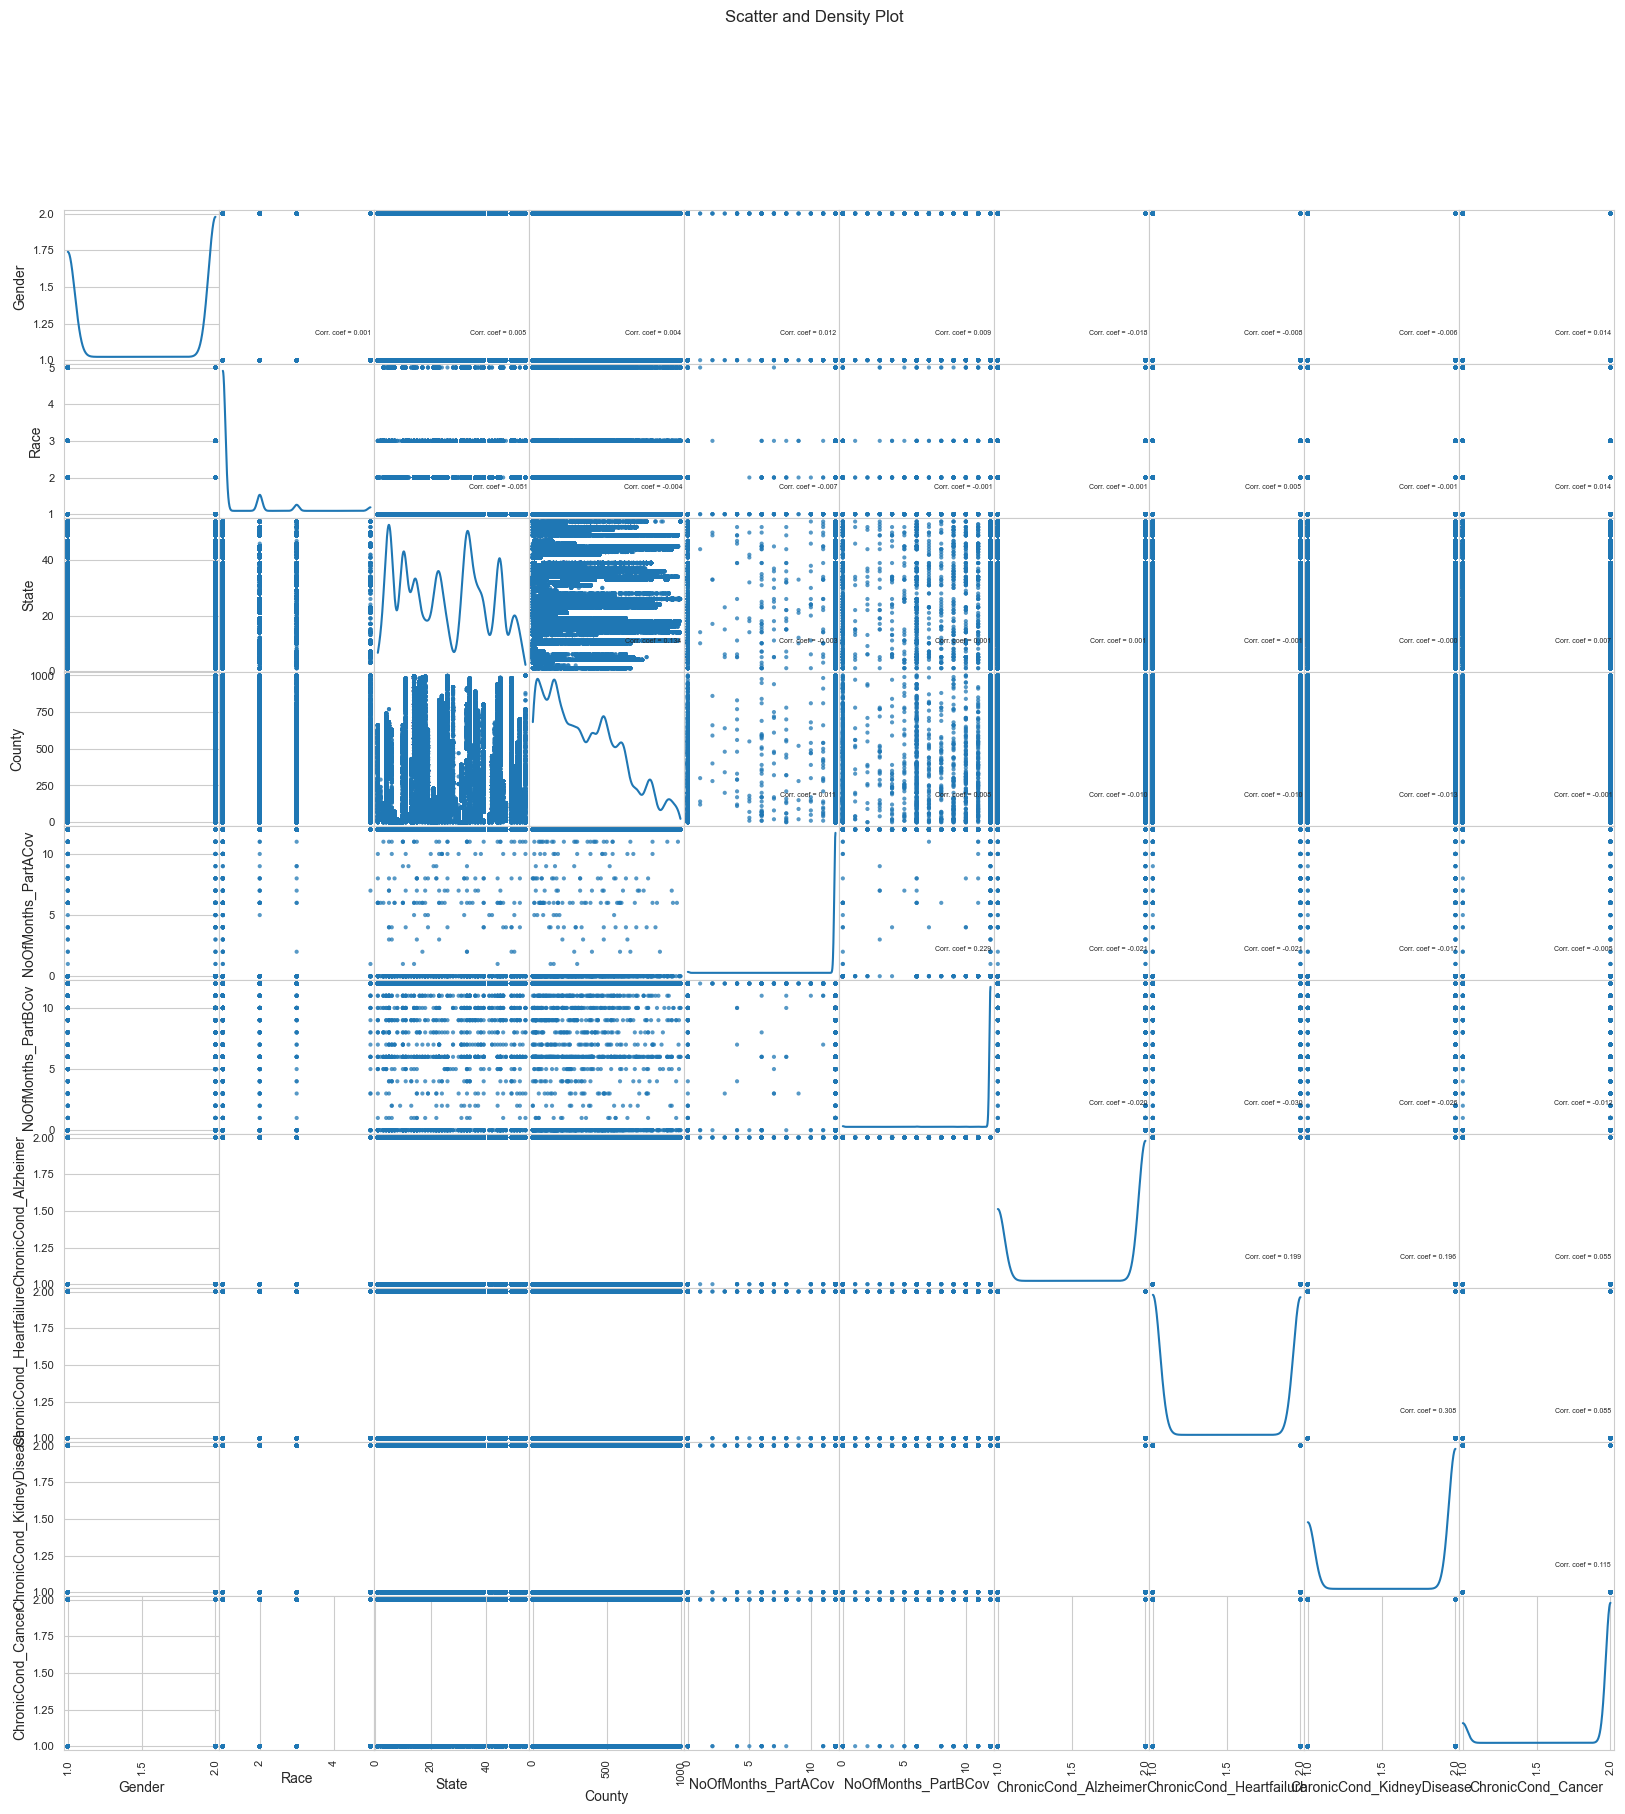

In [46]:
plotScatterMatrix(df_beneficiary, 20, 5)

#### Gender and Age

In [47]:
# Recode Gender
df_beneficiary['Gender'] = df_beneficiary['Gender'].apply(lambda val: 0 if val == 2 else 1)

zero = df_beneficiary['Gender'].value_counts()[0]
one = df_beneficiary['Gender'].value_counts()[1]
print("Split of '0': " + str(round(((zero/df_beneficiary['BeneID'].nunique())*100),2)) + "%")
print("Split of '1': " + str(round(((one/df_beneficiary['BeneID'].nunique())*100),2)) + "%")

Split of '0': 57.15%
Split of '1': 42.85%


We can assume that 0 represents Males and 1 represents Females as it is statistically proven that there are more males than females in the world population.

In [48]:
# Creating 'Alive' dummy variable for beneficiaries
df_beneficiary['Alive'] = df_beneficiary['DOD'].apply(lambda val: 1 if val != val else 0)
df_beneficiary['Alive'].value_counts()

# Most beneficiaries are alive.
# 1: Alive, 0: Dead

1    124060
0      1263
Name: Alive, dtype: int64

In [49]:
# This is the last DOD recorded so we will use this date as the reference to calculate age.
max(df_beneficiary['DOD'].unique()[1:])

'2009-12-01'

<AxesSubplot: ylabel='Frequency'>

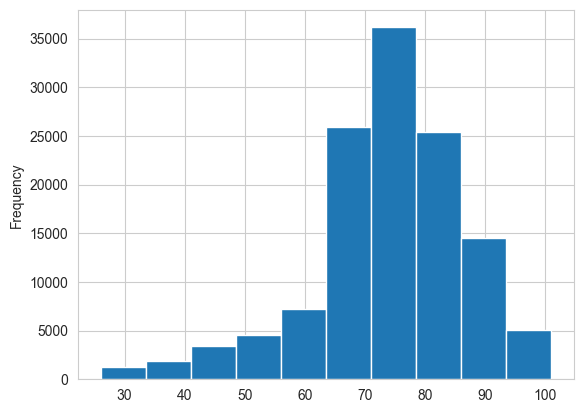

In [50]:
# Creating 'Age' variable
##### btw in the reference notebook, they created new columns for year of birth and month of birth to verify against when the beneficiary submits the claim 
##### but here we dh the data so can just mention this as an initial assessment criteria as the insurer pov?? correct me if im wrong

df_beneficiary['DOB'] = pd.to_datetime(df_beneficiary['DOB'] , format = '%Y-%m-%d')
df_beneficiary['DOD'] = pd.to_datetime(df_beneficiary['DOD'],format = '%Y-%m-%d',errors='ignore')
df_beneficiary['Age'] = round(((df_beneficiary['DOD'] - df_beneficiary['DOB']).dt.days)/365,0)

df_beneficiary.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - df_beneficiary['DOB']).dt.days)/365,0), inplace=True)

df_beneficiary['Age'].plot(kind = 'hist')


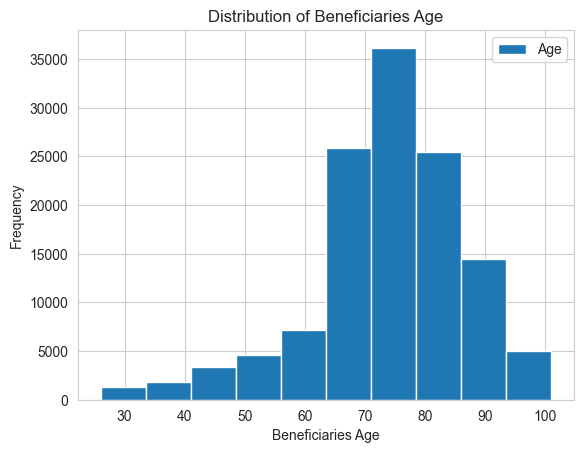

In [51]:
# Plotting Age Distribution
df_beneficiary['Age'].plot(kind = 'hist')
plt.xlabel("Beneficiaries Age")
plt.title("Distribution of Beneficiaries Age")
plt.legend()

In [52]:
df_beneficiary['Age'].describe()

count    125323.000000
mean         73.664738
std          12.755090
min          26.000000
25%          68.000000
50%          74.000000
75%          82.000000
max         101.000000
Name: Age, dtype: float64

Entropy based binning for our continuous features

In [53]:
# Article for reference: https://natmeurer.com/a-simple-guide-to-entropy-based-discretization/

def calculate_entropy(df:pd.DataFrame) -> float:
  total = len(df.index)
  positive = df['PotentialFraud'].sum()
  negative = total - positive
  
  if (total == 0):
      entropy = 0
  elif (positive == 0):
      n_offenders_entropy = (negative/total)*math.log(negative/total, 2)
      entropy = -(n_offenders_entropy)
  elif (negative == 0):
      offenders_entropy = (positive/total)*math.log(positive/total, 2)
      entropy = -(offenders_entropy)
  else:
      offenders_entropy = (positive/total)*math.log(positive/total, 2)
      n_offenders_entropy = (negative/total)*math.log(negative/total, 2)
      entropy = -(offenders_entropy + n_offenders_entropy)
  return entropy

def top_splits(df:pd.DataFrame, split:int) -> list:
  col_of_interest = df.columns.tolist()
  col_of_interest.remove('PotentialFraud') # this is to obtain col of interest for dynamic usage
  col_of_interest = col_of_interest[0]
  
  sorted_interest = np.sort(df[col_of_interest].unique())
  splits = (sorted_interest[1:] + sorted_interest[:-1]) / 2
  bin_threshold = split #user specifies how many splits they want to have 
  top_splits = []
  curr_df = pd.DataFrame()
  while len(top_splits) < bin_threshold:
      overall_entropy = calculate_entropy(df) #df here needs to be resetted after each split is confirmed
      highest_split = 0 #value of highest split
      highest_gain = 0 #highest value of information gain
      flag = ''
      # for loop to go through all splits and getting the best one
      for i in range(len(splits)):
          curr_split = splits[i]
          less_than_split_df, more_than_split_df = df[df[col_of_interest] <= curr_split], df[df[col_of_interest] > curr_split]
          less_length, more_length = len(less_than_split_df.index), len(more_than_split_df.index)
          less_than_split_entropy, more_than_split_entropy = calculate_entropy(less_than_split_df), calculate_entropy(more_than_split_df)
          net_entropy = (less_length/(less_length+more_length))*less_than_split_entropy + (more_length/(less_length+more_length))*more_than_split_entropy
          info_gain = overall_entropy - net_entropy
          if info_gain > highest_gain: 
              highest_gain = info_gain
              highest_split = curr_split
              #when df splits, the part of df with higher entropy = curr_df so as to split again afterwards
              if less_than_split_entropy > more_than_split_entropy:
                  curr_df = less_than_split_df
                  flag = 'more than'
              else:
                  curr_df = more_than_split_df
                  flag = 'less than'
      df = curr_df.copy()
      if flag == 'more than':
          splits = np.delete(splits, np.where(splits >=  highest_split))
          top_splits.append('> ' + str(highest_split))
      elif flag == 'less than':
          splits = np.delete(splits, np.where(splits <= highest_split))
          top_splits.append('<= ' + str(highest_split))
  return top_splits

In [54]:
test = df.copy()
test['PotentialFraud'] = test['PotentialFraud'].apply(lambda x: 1 if x=='Yes' else 0)
#top_splits(test[['Age','PotentialFraud']],4)

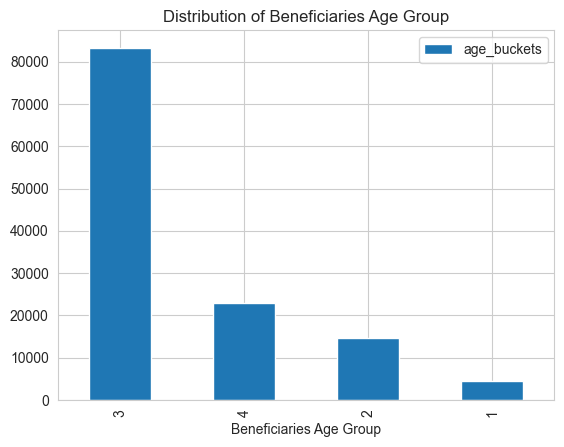

In [55]:
# Generate Age buckets according to 
# https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/NationalHealthExpendData/Age-and-Gender
# Group 1: 19 - 44
# Group 2: 45 - 64
# Group 3: 65 - 84
# Group 4: 85+

def age_buckets(x):
  if x <=44:
    return '1'
  elif x > 44 and x <=64:
    return '2'
  elif x > 64 and x <= 84:
    return '3'
  else:
    return '4'

df_beneficiary['age_buckets'] = df_beneficiary['Age'].apply(lambda x: age_buckets(x))

# Plotting Age Group Distribution
df_beneficiary['age_buckets'].value_counts().plot.bar()
plt.xlabel("Beneficiaries Age Group")
plt.title("Distribution of Beneficiaries Age Group")
plt.legend()

<AxesSubplot: xlabel='Gender'>

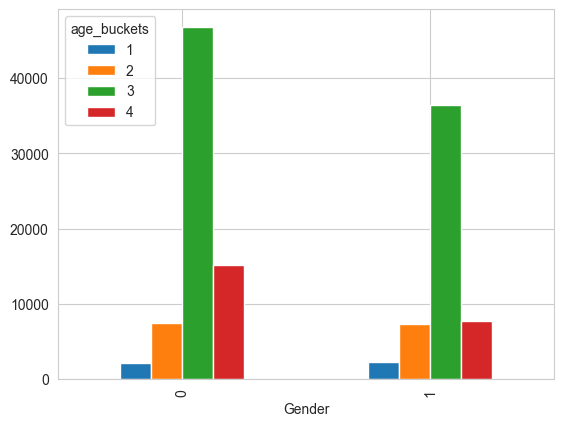

In [56]:
# Gender and Age Group
df_beneficiary.groupby('age_buckets').Gender.value_counts().unstack(0).plot.bar()

Conclusion: no difference in distribution

Text(0.5, 1.0, 'OPAnnualReimbursementAmt across age groups')

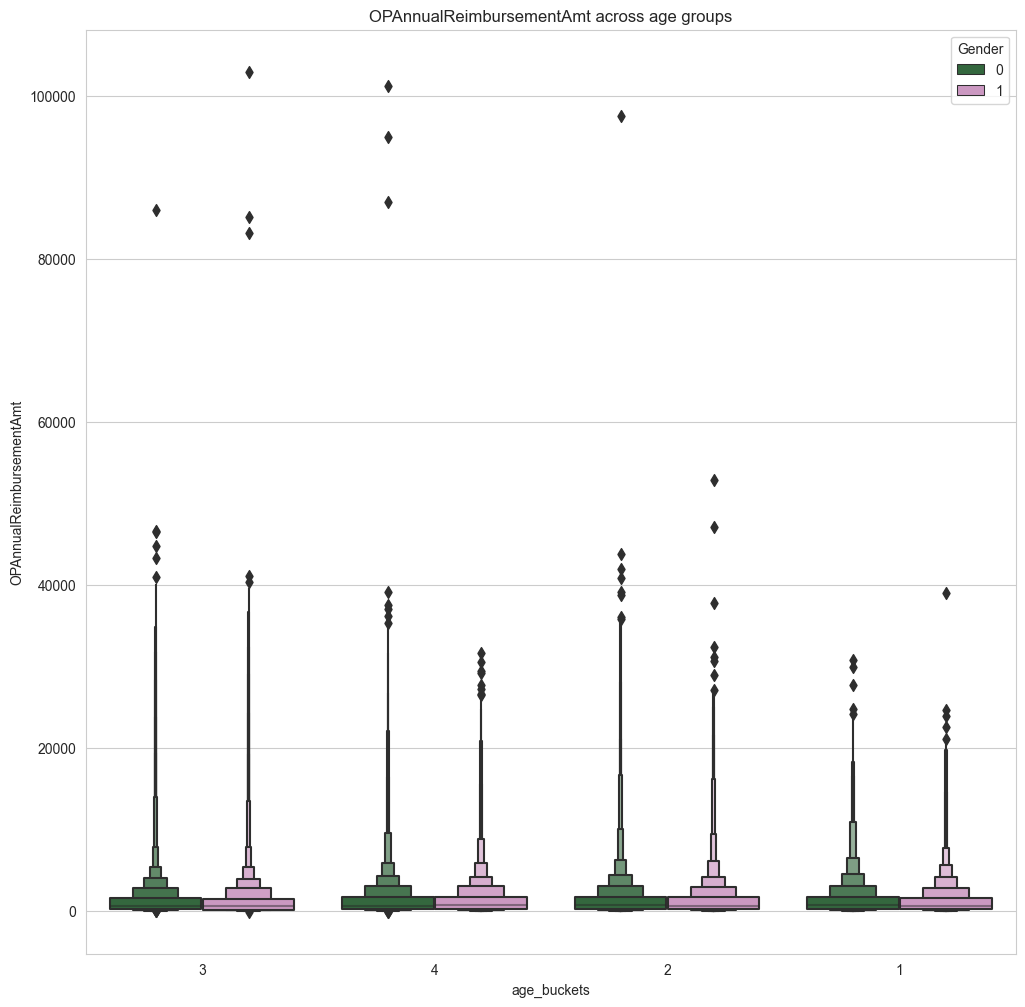

In [57]:
plt.figure(figsize=(12,12))
sns.boxenplot(data=df_beneficiary, x='age_buckets', y='OPAnnualReimbursementAmt', hue='Gender', palette='cubehelix')
plt.minorticks_on()
plt.title("OPAnnualReimbursementAmt across age groups")

Text(0.5, 1.0, 'IPAnnualReimbursementAmt across age groups')

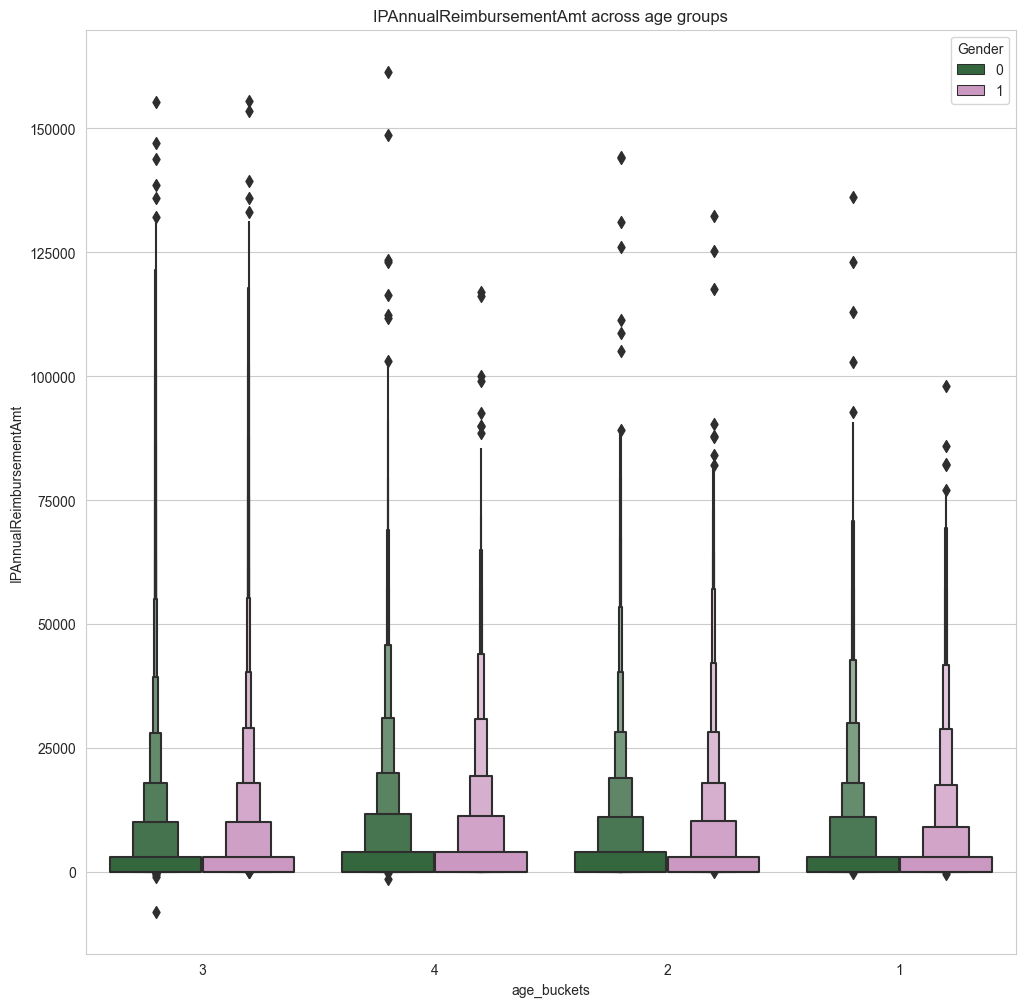

In [58]:
plt.figure(figsize=(12,12))
sns.boxenplot(data=df_beneficiary, x='age_buckets', y='IPAnnualReimbursementAmt', hue='Gender', palette='cubehelix')
plt.minorticks_on()
plt.title("IPAnnualReimbursementAmt across age groups")

#### Months Coverage

In [59]:
# Number of months coverage for each Part
print(df_beneficiary.columns)
df_beneficiary['NoOfMonths_PartACov'].value_counts()

Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'Alive', 'Age', 'age_buckets'],
      dtype='object')


12    124321
0        854
6         37
11        26
8         20
10        15
4         13
7         13
5          7
2          5
9          5
3          4
1          3
Name: NoOfMonths_PartACov, dtype: int64

In [60]:
df_beneficiary['NoOfMonths_PartBCov'].value_counts()

12    123898
0        588
6        239
10       128
11       127
9         99
8         59
7         57
5         42
4         31
3         24
1         16
2         15
Name: NoOfMonths_PartBCov, dtype: int64

More than 99% of the beneficiaries have 12 months coverage for both Part A and Part B.

#### States and County

<AxesSubplot: >

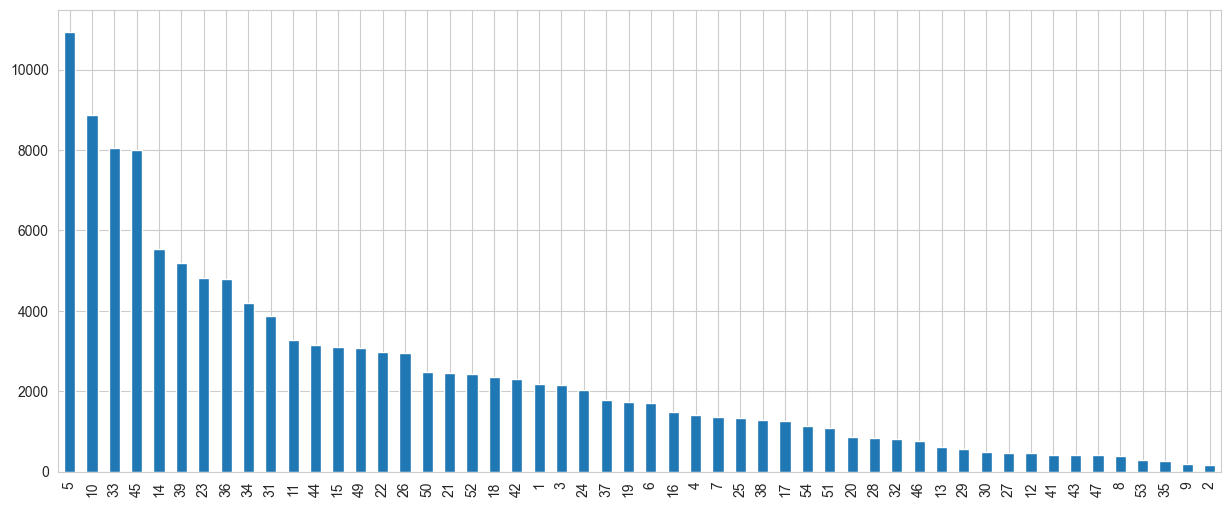

In [61]:
plt.figure(figsize=(15,6))
df_beneficiary['State'].value_counts().plot(kind='bar')

# Top 4 states: 5 (Arkansas), 10 (Delaware), 33 (New Hampshire), 45 (South Carolina)
# https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm 

In [62]:
# Top 3 conditions in each state
state_condition = df_beneficiary.groupby(['State'])[conditions].sum().reset_index()
states = df_beneficiary['State'].unique()
state_condition.head()

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\3812522283.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  state_condition = df_beneficiary.groupby(['State'])[conditions].sum().reset_index()


State  ChronicCond_Alzheimer  ChronicCond_Heartfailure  \
0      1                   3617                      3221   
1      2                    297                       275   
2      3                   3649                      3311   
3      4                   2339                      2100   
4      5                  18286                     16572   

   ChronicCond_KidneyDisease  ChronicCond_Cancer  ChronicCond_ObstrPulmonary  \
0                       3590                4086                        3793   
1                        309                 336                         314   
2                       3702                4072                        3836   
3                       2385                2649                        2444   
4                      18466               20604                       19379   

   ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  \
0                    3552                  2971                       2843   
1                     290                   253                        243   
2                    3623                  3086                       2893   
3                    2291                  1970                       1864   
4                   17919                 15210                      14568   

   ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis  \
0                      3727                             3794   
1                       324                              323   
2                      3732                             3782   
3                      2432                             2451   
4                     18806                            19042   

   ChronicCond_stroke  
0                4171  
1                 338  
2                4166  
3                2714  
4               21027

In [63]:
top_3_conditions_state = state_condition.set_index('State')
top_3_conditions_state = pd.DataFrame(state_condition.columns.values[np.argsort(-state_condition.values, axis=1)[:, :3]], 
                  index=state_condition.index,
                  columns = ['1st Max','2nd Max','3rd Max']).reset_index()
top_3_conditions_state
# Stroke and Cancer are prevalent

index             1st Max             2nd Max  \
0       0  ChronicCond_stroke  ChronicCond_Cancer   
1       1  ChronicCond_stroke  ChronicCond_Cancer   
2       2  ChronicCond_stroke  ChronicCond_Cancer   
3       3  ChronicCond_stroke  ChronicCond_Cancer   
4       4  ChronicCond_stroke  ChronicCond_Cancer   
5       5  ChronicCond_stroke  ChronicCond_Cancer   
6       6  ChronicCond_stroke  ChronicCond_Cancer   
7       7  ChronicCond_stroke  ChronicCond_Cancer   
8       8  ChronicCond_stroke  ChronicCond_Cancer   
9       9  ChronicCond_stroke  ChronicCond_Cancer   
10     10  ChronicCond_stroke  ChronicCond_Cancer   
11     11  ChronicCond_stroke  ChronicCond_Cancer   
12     12  ChronicCond_stroke  ChronicCond_Cancer   
13     13  ChronicCond_stroke  ChronicCond_Cancer   
14     14  ChronicCond_stroke  ChronicCond_Cancer   
15     15  ChronicCond_stroke  ChronicCond_Cancer   
16     16  ChronicCond_stroke  ChronicCond_Cancer   
17     17  ChronicCond_stroke  ChronicCond_Cancer   
18     18  ChronicCond_stroke  ChronicCond_Cancer   
19     19  ChronicCond_stroke  ChronicCond_Cancer   
20     20  ChronicCond_stroke  ChronicCond_Cancer   
21     21  ChronicCond_stroke  ChronicCond_Cancer   
22     22  ChronicCond_stroke  ChronicCond_Cancer   
23     23  ChronicCond_stroke  ChronicCond_Cancer   
24     24  ChronicCond_stroke  ChronicCond_Cancer   
25     25  ChronicCond_stroke  ChronicCond_Cancer   
26     26  ChronicCond_stroke  ChronicCond_Cancer   
27     27  ChronicCond_stroke  ChronicCond_Cancer   
28     28  ChronicCond_stroke  ChronicCond_Cancer   
29     29  ChronicCond_stroke  ChronicCond_Cancer   
30     30  ChronicCond_stroke  ChronicCond_Cancer   
31     31  ChronicCond_stroke  ChronicCond_Cancer   
32     32  ChronicCond_stroke  ChronicCond_Cancer   
33     33  ChronicCond_stroke  ChronicCond_Cancer   
34     34  ChronicCond_stroke  ChronicCond_Cancer   
35     35  ChronicCond_stroke  ChronicCond_Cancer   
36     36  ChronicCond_stroke  ChronicCond_Cancer   
37     37  ChronicCond_stroke  ChronicCond_Cancer   
38     38  ChronicCond_stroke  ChronicCond_Cancer   
39     39  ChronicCond_stroke  ChronicCond_Cancer   
40     40  ChronicCond_stroke  ChronicCond_Cancer   
41     41  ChronicCond_stroke  ChronicCond_Cancer   
42     42  ChronicCond_stroke  ChronicCond_Cancer   
43     43  ChronicCond_stroke  ChronicCond_Cancer   
44     44  ChronicCond_stroke  ChronicCond_Cancer   
45     45  ChronicCond_stroke  ChronicCond_Cancer   
46     46  ChronicCond_stroke  ChronicCond_Cancer   
47     47  ChronicCond_stroke  ChronicCond_Cancer   
48     48  ChronicCond_stroke  ChronicCond_Cancer   
49     49  ChronicCond_stroke  ChronicCond_Cancer   
50     50  ChronicCond_stroke  ChronicCond_Cancer   
51     51  ChronicCond_stroke  ChronicCond_Cancer   

                            3rd Max  
0   ChronicCond_rheumatoidarthritis  
1          ChronicCond_Osteoporasis  
2        ChronicCond_ObstrPulmonary  
3   ChronicCond_rheumatoidarthritis  
4        ChronicCond_ObstrPulmonary  
5        ChronicCond_ObstrPulmonary  
6        ChronicCond_ObstrPulmonary  
7        ChronicCond_ObstrPulmonary  
8        ChronicCond_ObstrPulmonary  
9        ChronicCond_ObstrPulmonary  
10       ChronicCond_ObstrPulmonary  
11       ChronicCond_ObstrPulmonary  
12       ChronicCond_ObstrPulmonary  
13       ChronicCond_ObstrPulmonary  
14       ChronicCond_ObstrPulmonary  
15       ChronicCond_ObstrPulmonary  
16       ChronicCond_ObstrPulmonary  
17       ChronicCond_ObstrPulmonary  
18  ChronicCond_rheumatoidarthritis  
19       ChronicCond_ObstrPulmonary  
20       ChronicCond_ObstrPulmonary  
21       ChronicCond_ObstrPulmonary  
22       ChronicCond_ObstrPulmonary  
23       ChronicCond_ObstrPulmonary  
24  ChronicCond_rheumatoidarthritis  
25       ChronicCond_ObstrPulmonary  
26       ChronicCond_ObstrPulmonary  
27       ChronicCond_ObstrPulmonary  
28  ChronicCond_rheumatoidarthritis  
29       ChronicCond_ObstrPulmonary  
30       Chronic

In [64]:
df_beneficiary.groupby(['State'])['IPAnnualReimbursementAmt'].sum()

# VARIBALES:
#1. inpatient/outpatient
#2. reimbursement/deductible
#3. condition

State
1      8135710
2       620010
3      8217860
4      5344030
5     40297850
6      5786010
7      6338850
8      1370870
9       723480
10    34312180
11    14746320
12     1604740
13     1962240
14    21270460
15    12347470
16     5874860
17     5031430
18     9045820
19     7545080
20     2496680
21     9571180
22    11336220
23    17425540
24     7622900
25     5782820
26    11451210
27     1805990
28     3708390
29     2655930
30     2160530
31    15613260
32     2622070
33    31714260
34    15951120
35     1193090
36    21315380
37     6350650
38     4515840
39    21341130
41     1361700
42     7805480
43     1292330
44    10671930
45    31981690
46     2829630
47     1459360
49    11597210
50     9015150
51     3878350
52     8513740
53      787570
54     3600970
Name: IPAnnualReimbursementAmt, dtype: int64

In [65]:
#state_condition.iloc[1].plot(kind='bar')
#state_condition.iloc[2].plot(kind='bar')

Conditions:


1.   Renal Disease
2.   Alzheimer
3.   Heart Failure
4.   Kidney Disease
5.   Cancer
6.   ObstrPulmonary
7.   Depression
8.   Diabetes
9.   Ischemic Heart
10.   Osteoporasis
11.   Rheumatoidarthritis
12.   Stroke


### Feature Engineering

#### Chronic and Renal Conditions Exploration

In [66]:
#extract renal and chronic columns
for i in df_beneficiary.columns:
    if 'Chronic' in i or 'Renal' in i:
      print(f"{i} : {df_beneficiary[i].unique()}")
      print(f"{df_beneficiary[i].value_counts()} \n")

RenalDiseaseIndicator : ['0' 'Y']
0    107096
Y     18227
Name: RenalDiseaseIndicator, dtype: int64 

ChronicCond_Alzheimer : [1 2]
2    82835
1    42488
Name: ChronicCond_Alzheimer, dtype: int64 

ChronicCond_Heartfailure : [2 1]
1    63188
2    62135
Name: ChronicCond_Heartfailure, dtype: int64 

ChronicCond_KidneyDisease : [1 2]
2    84925
1    40398
Name: ChronicCond_KidneyDisease, dtype: int64 

ChronicCond_Cancer : [2 1]
2    109879
1     15444
Name: ChronicCond_Cancer, dtype: int64 

ChronicCond_ObstrPulmonary : [2 1]
2    94560
1    30763
Name: ChronicCond_ObstrPulmonary, dtype: int64 

ChronicCond_Depression : [1 2]
2    79777
1    45546
Name: ChronicCond_Depression, dtype: int64 

ChronicCond_Diabetes : [1 2]
1    76891
2    48432
Name: ChronicCond_Diabetes, dtype: int64 

ChronicCond_IschemicHeart : [1 2]
1    85946
2    39377
Name: ChronicCond_IschemicHeart, dtype: int64 

ChronicCond_Osteoporasis : [2 1]
2    90254
1    35069
Name: ChronicCond_Osteoporasis, dtype: int64 



With these columns, we can use the chronic conditions and renal disease indicator as a proxy to map the overall health of the patient. There is no clear indication of what the values mean, however we can apply some handling to assume 1 means yes. Thus, we replace all the 2's with 0 and Y's with 1 then convert `RenalDiseaseIndicator` to a numeric column

In [67]:
for i in df_beneficiary.columns:
    if 'Chronic' in i:
      df_beneficiary[i].replace(2,0,inplace=True)
    elif 'Renal' in i:
      df_beneficiary[i].replace('Y',1,inplace=True)
      df_beneficiary[i] = pd.to_numeric(df_beneficiary[i])
df_beneficiary.dtypes

BeneID                                     object
DOB                                datetime64[ns]
DOD                                datetime64[ns]
Gender                                      int64
Race                                        int64
RenalDiseaseIndicator                       int64
State                                       int64
County                                      int64
NoOfMonths_PartACov                         int64
NoOfMonths_PartBCov                         int64
ChronicCond_Alzheimer                       int64
ChronicCond_Heartfailure                    int64
ChronicCond_KidneyDisease                   int64
ChronicCond_Cancer                          int64
ChronicCond_ObstrPulmonary                  int64
ChronicCond_Depression                      int64
ChronicCond_Diabetes                        int64
ChronicCond_IschemicHeart                   int64
ChronicCond_Osteoporasis                    int64
ChronicCond_rheumatoidarthritis             int64


In [68]:
# Correlation matrix

conditions_corr = df_beneficiary[conditions]
corr = conditions_corr.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\1805969144.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


In [69]:
# Chronic Kidney Disease and Renal Disease
have_renal_no_kidney = sum((df_beneficiary.RenalDiseaseIndicator == 1) & (df_beneficiary.ChronicCond_KidneyDisease == 0))
have_renal_have_kidney = sum((df_beneficiary.RenalDiseaseIndicator == 1) & (df_beneficiary.ChronicCond_KidneyDisease == 1))
no_renal_have_kidney = sum((df_beneficiary.RenalDiseaseIndicator == 0) & (df_beneficiary.ChronicCond_KidneyDisease == 1))
no_renal_no_kidney = sum((df_beneficiary.RenalDiseaseIndicator == 0) & (df_beneficiary.ChronicCond_KidneyDisease == 0))
no_renal = [no_renal_no_kidney, no_renal_have_kidney]
have_renal = [have_renal_no_kidney,have_renal_have_kidney]
pd.DataFrame(list(zip(no_renal, have_renal)), columns=['no_renal','have_renal'])

# End-stage renal disease, also called end-stage kidney disease or kidney failure.
# The 3062 beneficiaries with no chronic kidney disease but with renal disease are suspicious.

no_renal  have_renal
0     81264        3661
1     25832       14566

In [70]:
have_renal_no_kidney

3661

#### Creating Patient Health Score Proxy

We can get a proxy for the patient's health by summing up all the chronic / renal conditions. A higher score indicates that the patient is less healthy.

In [71]:
# calculate patient risk score by summing up all the chronic conditions.
# The higher risk score indicates the health of the patient is not good

df_beneficiary['Health_Score'] = df_beneficiary['ChronicCond_Alzheimer'] + df_beneficiary['ChronicCond_Heartfailure'] + \
                                        df_beneficiary['ChronicCond_KidneyDisease'] + df_beneficiary['ChronicCond_Cancer'] +\
                                        df_beneficiary['ChronicCond_ObstrPulmonary'] + df_beneficiary['ChronicCond_Depression'] +\
                                    df_beneficiary['ChronicCond_Diabetes'] + df_beneficiary['ChronicCond_IschemicHeart'] +\
                                    df_beneficiary['ChronicCond_Osteoporasis'] + df_beneficiary['ChronicCond_rheumatoidarthritis'] +\
                                    df_beneficiary['ChronicCond_stroke'] + df_beneficiary['RenalDiseaseIndicator'] 

In [72]:
df_beneficiary['Health_Score'].describe()

count    125323.000000
mean          3.967045
std           2.474997
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          12.000000
Name: Health_Score, dtype: float64

#### Plot Health Score Distribution

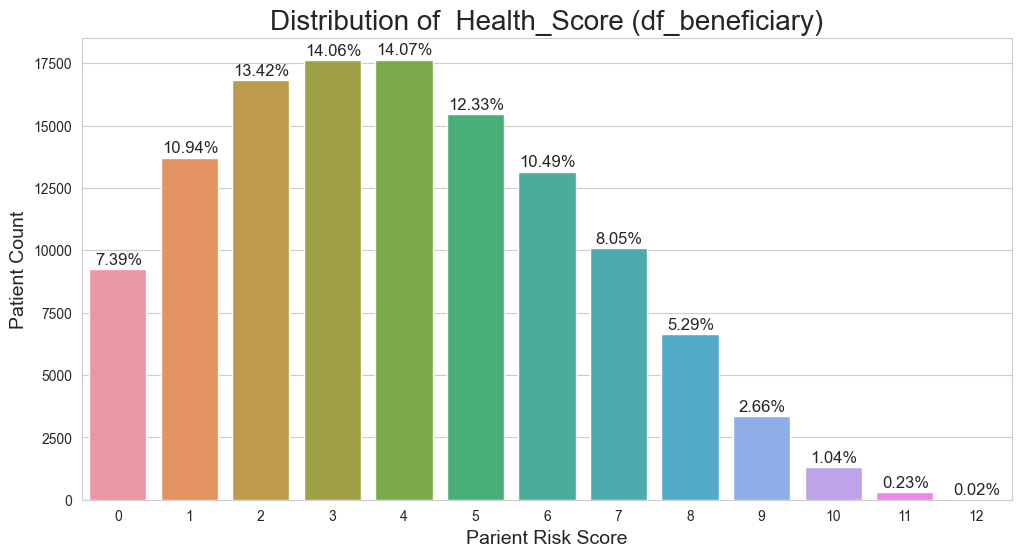

In [73]:
# Distribition of patient risk score
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Health_Score',y=None, data=df_beneficiary, orient ="v")
plt.title('Distribution of  Health_Score (df_beneficiary)', fontsize=20)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Parient Risk Score', size = 14)
plt.ylabel('Patient Count', size = 14)
percentage_without_hue(ax, df_beneficiary['Health_Score'], 0.01, 200,12)

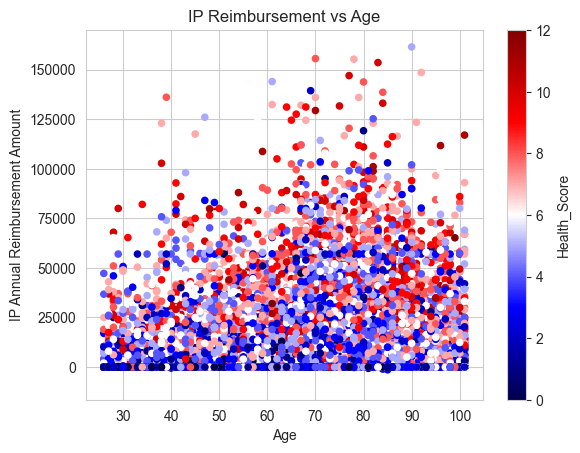

In [74]:
df_beneficiary.plot(kind = 'scatter',x = 'Age', y = 'IPAnnualReimbursementAmt',c = 'Health_Score', cmap='seismic')
# chose this colour to compare those below 6 vs above 6 --> can see that generally those above 6 have higher amounts
plt.title('IP Reimbursement vs Age')
plt.xlabel('Age')
plt.ylabel('IP Annual Reimbursement Amount')
plt.show()

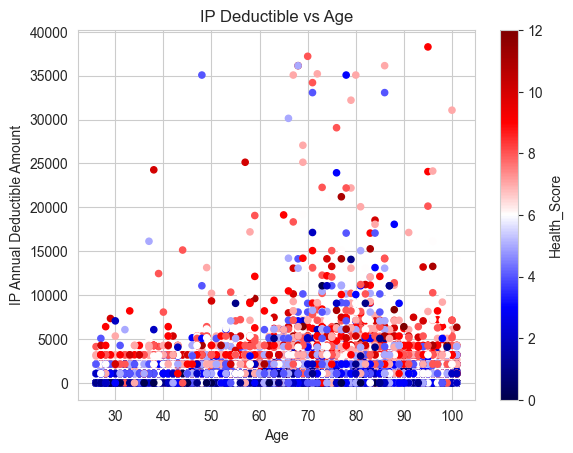

In [75]:
df_beneficiary.plot(kind = 'scatter',x = 'Age', y = 'IPAnnualDeductibleAmt', c = 'Health_Score', cmap='seismic')
# chose this colour to compare those below 6 vs above 6 --> can see that generally those above 6 have higher amounts
plt.title('IP Deductible vs Age')
plt.xlabel('Age')
plt.ylabel('IP Annual Deductible Amount')
plt.show()

# Some suspiciously high amounts.

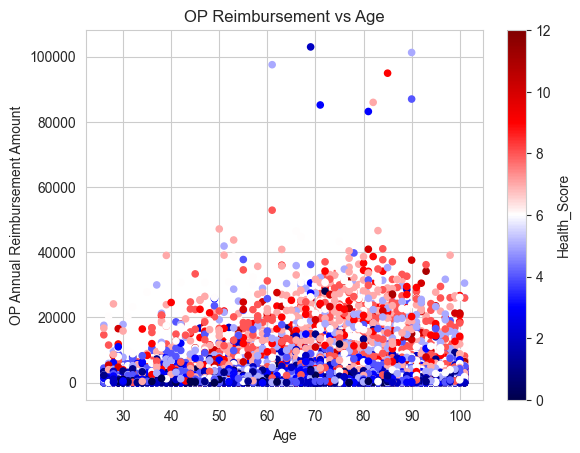

In [76]:
df_beneficiary.plot(kind = 'scatter',x = 'Age', y = 'OPAnnualReimbursementAmt', c = 'Health_Score', cmap='seismic')
# chose this colour to compare those below 6 vs above 6 --> can see that generally those above 6 have higher amounts
plt.title('OP Reimbursement vs Age')
plt.xlabel('Age')
plt.ylabel('OP Annual Reimbursement Amount')
plt.show()

# There are some suspiciously high amounts which could be fruad, especially since they have lower health scores.

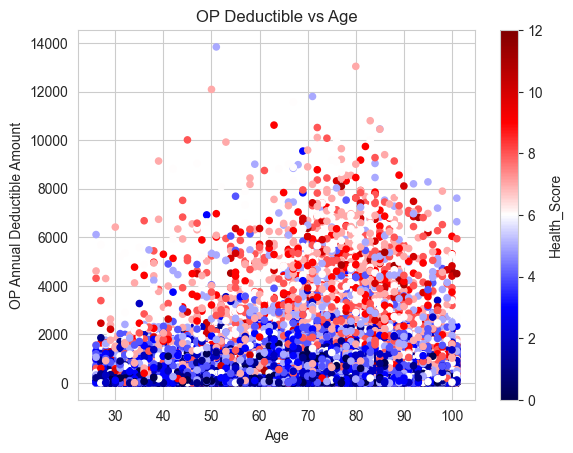

In [77]:
df_beneficiary.plot(kind = 'scatter',x = 'Age', y = 'OPAnnualDeductibleAmt', c = 'Health_Score', cmap='seismic')
# chose this colour to compare those below 6 vs above 6 --> can see that generally those above 6 have higher amounts
plt.title('OP Deductible vs Age')
plt.xlabel('Age')
plt.ylabel('OP Annual Deductible Amount')
plt.show()

Generally, beneficiaries with higher health scores receive larger amounts.

## Label Dataset (df_label)

#### Plot to check the distribution between potential fraud 1/0 flags

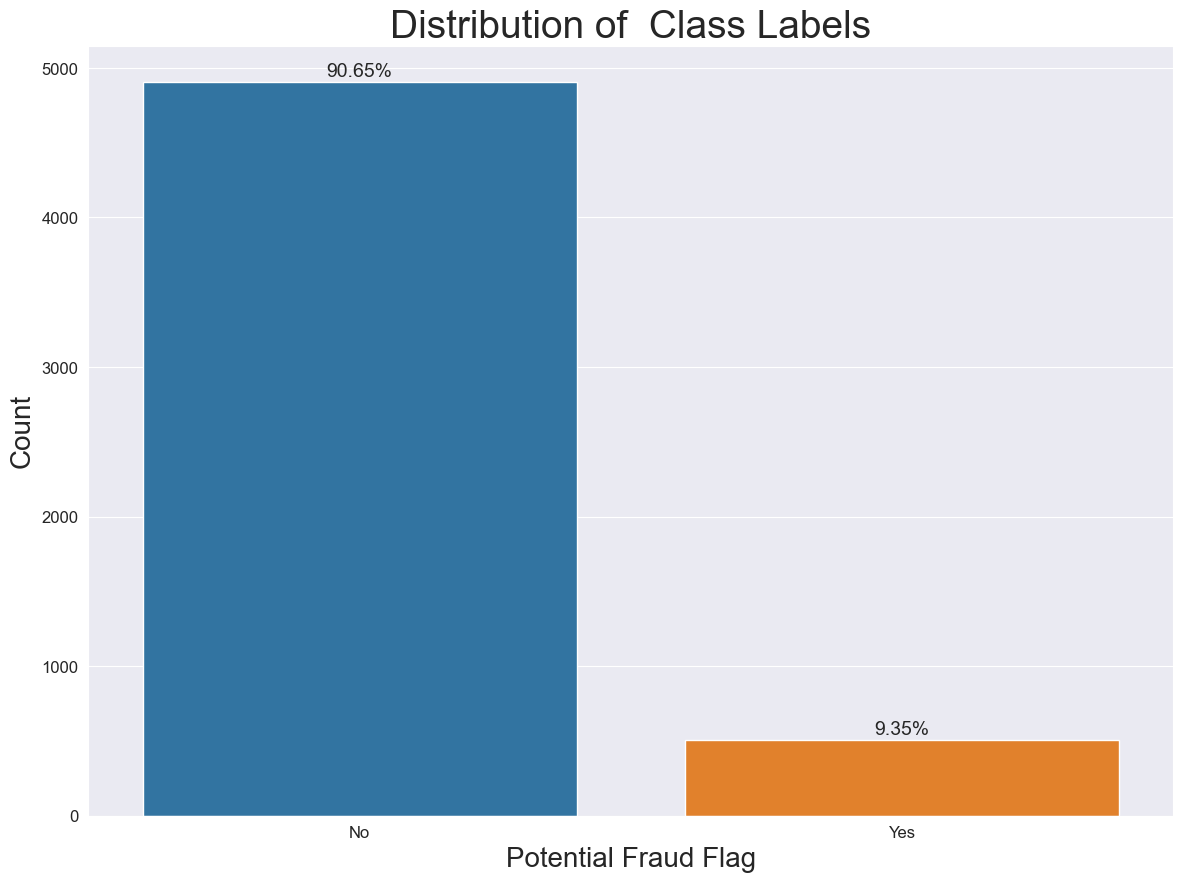

In [78]:
plt.figure(figsize=(14,10))
sns.set_style('darkgrid')
ax = sns.countplot(x='PotentialFraud',data=train)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title('Distribution of  Class Labels', fontsize=28)
plt.xlabel('Potential Fraud Flag', size = 20)
plt.ylabel('Count', size = 20)
percentage_without_hue(ax, train['PotentialFraud'], 0,40,14)

The data is currently highly imbalanced, with roughly 10% fraudulent cases and 90% non-fraudulent cases

### Other Variables Exploration

##### Combining Inpatient and Outpatient Data

In [79]:
# common and unique columns of the inpatient and outpatient datasets
# the unique columns are: 'AdmissionDt', 'DiagnosisGroupCode', 'DischargeDt', all 3 from inpatient
common = train_inpatient.columns.intersection(train_outpatient.columns) 
unique = train_inpatient.columns.symmetric_difference(train_outpatient.columns) 

In [80]:
# create source column for each dataset before appending
# appending both into one dataset allows us to analyze for any behavioural differences between inpatient and outpatient customers
train_inpatient['source'] = "inpatient"
train_outpatient['source'] = "outpatient"

train_allpatient = train_inpatient.copy()
train_allpatient = train_allpatient.append(train_outpatient)

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\2919345358.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_allpatient = train_allpatient.append(train_outpatient)


In [81]:
# look for duplicates
duplicate = train_allpatient[train_allpatient.duplicated(subset = common)]
len(duplicate)

0

## Patient Data (df_patient)

##### Trying Benford's Law on Insurance Claim Amount

Text(0.5, 1.0, 'Frequency of first digit of Insurance Claim Amount Reimbursed')

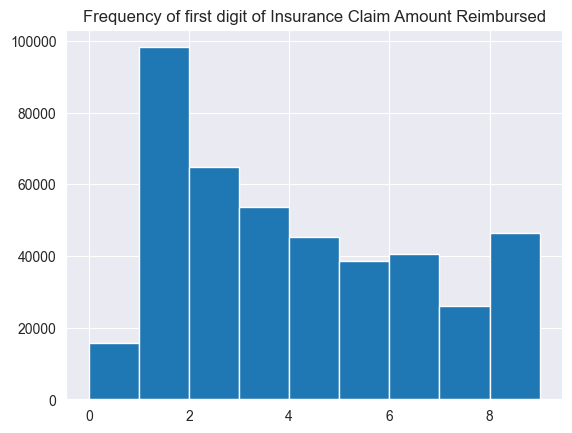

In [82]:
test = pd.DataFrame(df_patient['InscClaimAmtReimbursed'])
test['firstdigit'] = test.InscClaimAmtReimbursed.astype(str).str[:1]
test = test.astype({'firstdigit':'int'})
plt.hist(test['firstdigit'],bins=[0,1,2,3,4,5,6,7,8,9])
plt.title('Frequency of first digit of Insurance Claim Amount Reimbursed')

The last bin of 8 - 9 looks suspicious as it is supposed to be the least frequent according to Benford's Law, yet it is greater than 4 other bars.

##### Correlated Physician and Beneficiary

If a patient has a chronic illness, you can expect him/her to return to the same physician for treatment over the long term. This is an opportunity for both parties to develop a close relationship and even commit fruad together for each other.

We can identify if there are any high occurrences of Physician-Beneficiary pair to take note of/ flag out when we are feature engineering later.

In [83]:
df_patient['DiagnosisCount'] = df_patient[['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 
                           'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 
                           'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10']].notna().sum(axis = 1)

df_patient['ProcedureCount'] = df_patient[['ClmProcedureCode_1', 'ClmProcedureCode_2', 
                                           'ClmProcedureCode_3', 'ClmProcedureCode_4', 
                           'ClmProcedureCode_5', 'ClmProcedureCode_6']].notna().sum(axis = 1)

fraud_patient = df_patient.copy().loc[df_patient['PotentialFraud'] == "Yes"]
nonfraud_patient = df_patient.copy().loc[df_patient['PotentialFraud'] == "No"]

all_patient = df_patient.copy()

#to include NAs in the counts as well
for i in ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 
          'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmProcedureCode_1', 
          'ClmProcedureCode_2']:

  fraud_patient.loc[fraud_patient[i].isna(), i] = "NA"
  nonfraud_patient.loc[nonfraud_patient[i].isna(), i] = "NA"
  all_patient.loc[all_patient[i].isna(), i] = "NA"

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\879911776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['DiagnosisCount'] = df_patient[['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\879911776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['ProcedureCount'] = df_patient[['ClmProcedureCode_1', 'ClmProcedureCode_2',


We decided to include NAs in the distribution as it may be an indicator for fraud. For example many fraud cases have no attending physicians while for non-fraud cases there may not have this observation.

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\3976509834.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


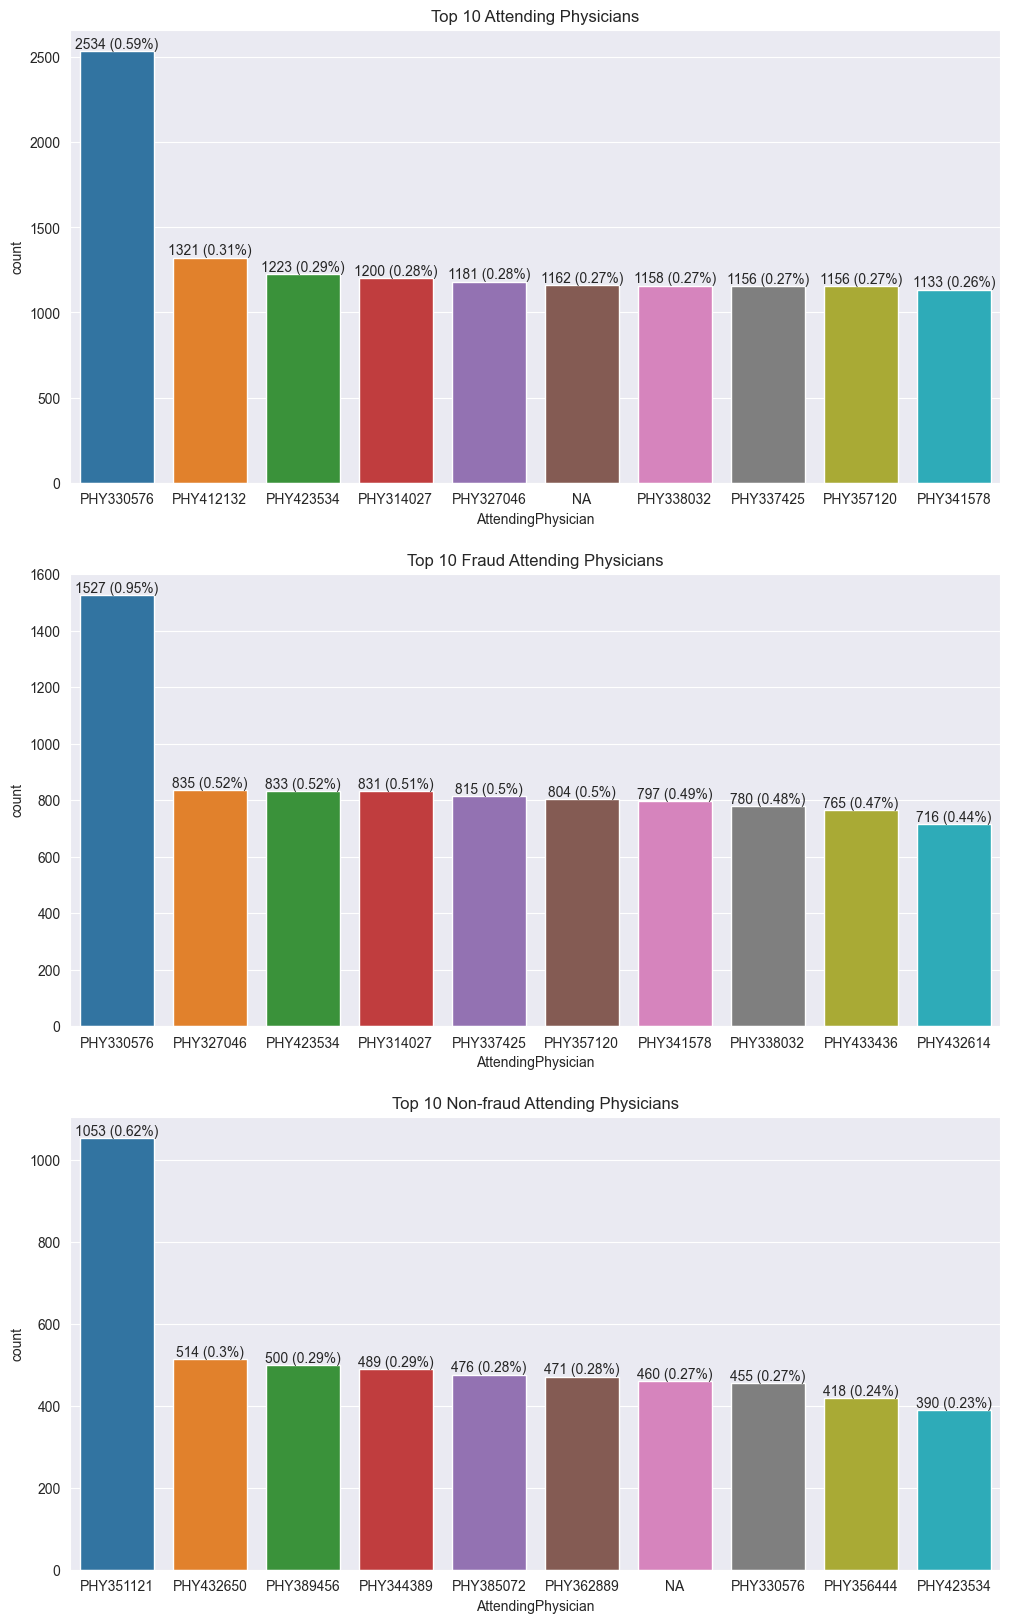

In [84]:
fig, (ax1, ax2, ax3) = pyplot.subplots(3,1,figsize=(12, 20))

sns.countplot(ax = ax1, x = all_patient['AttendingPhysician'], order=all_patient.AttendingPhysician.value_counts().iloc[:10].index)
ax1.set_title("Top 10 Attending Physicians")
abs_values = all_patient['AttendingPhysician'].value_counts(ascending=False).iloc[:10].values
lab = []
for h in abs_values:
  percent = str(round((h/all_patient.shape[0])*100,2)) + "%"
  label = str(h) + " (" + percent + ")"
  lab.append(label)
ax1.bar_label(container=ax1.containers[0], labels=lab)

sns.countplot(ax = ax2, x = fraud_patient['AttendingPhysician'], order=fraud_patient.AttendingPhysician.value_counts().iloc[:10].index)
ax2.set_title("Top 10 Fraud Attending Physicians")
abs_values = fraud_patient['AttendingPhysician'].value_counts(ascending=False).iloc[:10].values
lab = []
for i in abs_values:
  percent = str(round((i/fraud_patient.shape[0])*100,2)) + "%"
  label = str(i) + " (" + percent + ")"
  lab.append(label)
ax2.bar_label(container=ax2.containers[0], labels=lab)

sns.countplot(ax = ax3, x = nonfraud_patient['AttendingPhysician'], order=nonfraud_patient.AttendingPhysician.value_counts().iloc[:10].index)
ax3.set_title("Top 10 Non-fraud Attending Physicians")
abs_values = nonfraud_patient['AttendingPhysician'].value_counts(ascending=False).iloc[:10].values
lab = []
for j in abs_values:
  percent = str(round((j/nonfraud_patient.shape[0])*100,2)) + "%"
  label = str(j) + " (" + percent + ")"
  lab.append(label)
ax3.bar_label(container=ax3.containers[0], labels=lab)
fig.show()

We can see that out of the top 10 physicians among all patients, 9 of them are in the top 10 fraud physicians and the number of sessions they have are the same. This means that all the sessions of these 9 phyisicians are fraud sessions. Therefore the physician ID may be a good indicator as IDs like PHY330576 are all fraud cases. However as this is user specific data, it does not help us to predict future cases and therefore we won't include it in the model. Instead this can be used through an expert based approach where if a physician ID is in the list of fraud then they will be flagged out.

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\1184566053.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


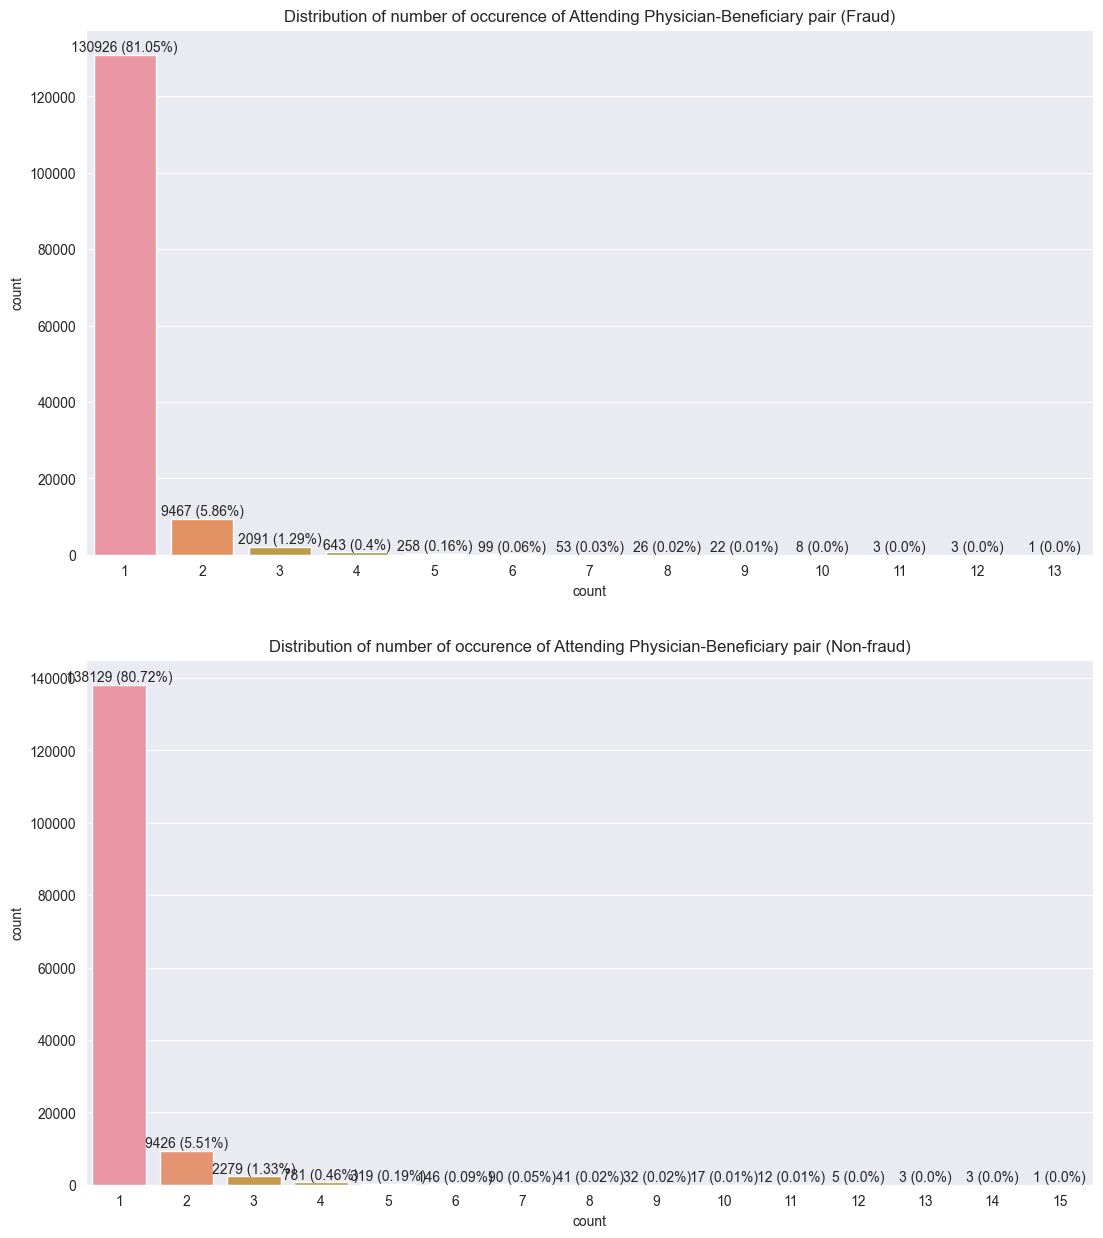

In [85]:
fraud_attendingphysician_pair = fraud_patient.groupby(['BeneID', 'AttendingPhysician']).size()
fraud_attendingphysician_pair = fraud_attendingphysician_pair.to_frame(name='count').reset_index()

nonfraud_attendingphysician_pair = nonfraud_patient.groupby(['BeneID', 'AttendingPhysician']).size()
nonfraud_attendingphysician_pair = nonfraud_attendingphysician_pair.to_frame(name='count').reset_index()

fig, (ax1, ax2) = pyplot.subplots(2, 1, figsize=(13,15))
sns.countplot(ax = ax1, x = fraud_attendingphysician_pair['count'])
ax1.set_title("Distribution of number of occurence of Attending Physician-Beneficiary pair (Fraud)")
abs_values = fraud_attendingphysician_pair['count'].value_counts(ascending=False).values
lab = []
for h in abs_values:
  percent = str(round((h/fraud_patient.shape[0])*100,2)) + "%"
  label = str(h) + " (" + percent + ")"
  lab.append(label)
ax1.bar_label(container=ax1.containers[0], labels=lab)

sns.countplot(ax = ax2, x = nonfraud_attendingphysician_pair['count'])
ax2.set_title("Distribution of number of occurence of Attending Physician-Beneficiary pair (Non-fraud)")
abs_values = nonfraud_attendingphysician_pair['count'].value_counts(ascending=False).values
lab = []
for i in abs_values:
  percent = str(round((i/nonfraud_patient.shape[0])*100,2)) + "%"
  label = str(i) + " (" + percent + ")"
  lab.append(label)
ax2.bar_label(container=ax2.containers[0], labels=lab)

# Show plot
fig.show()



We plot the distribution of the number of sessions between each physician and beneficiary pair for both fraud and non-fraud cases. We can see that there is not obvious trend between the number of session of 2 specific individuals and the potential of fraud.

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\1131272327.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


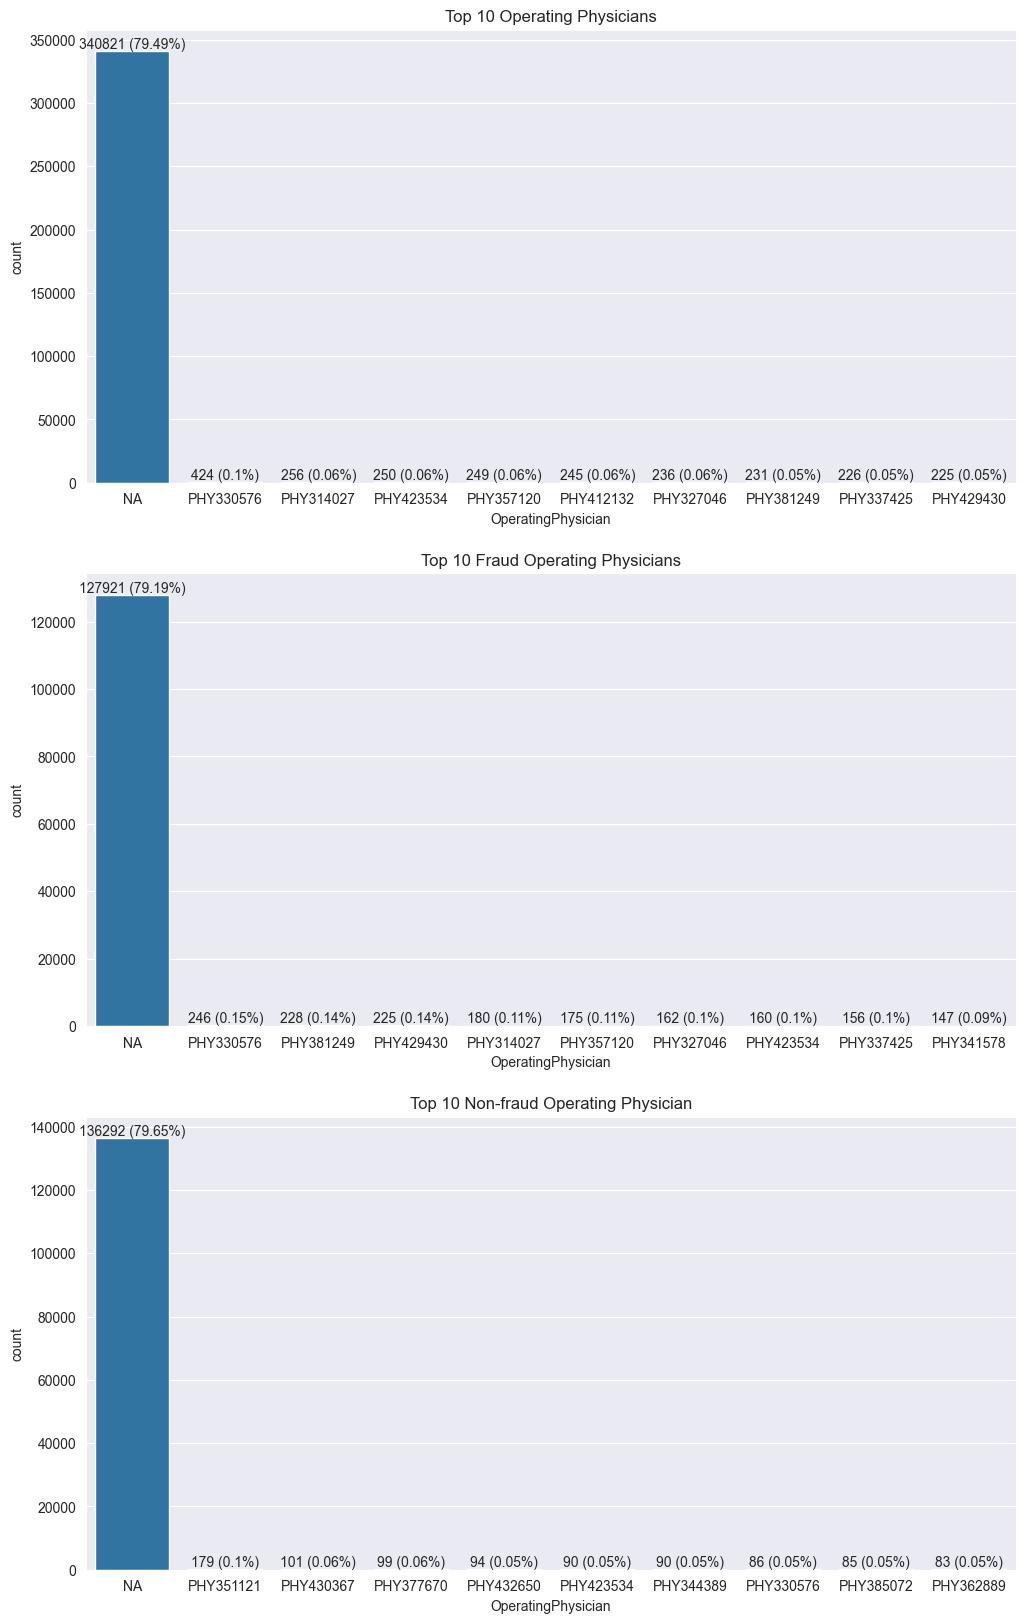

In [86]:
fig, (ax1, ax2, ax3) = pyplot.subplots(3,1,figsize=(12, 20))

sns.countplot(ax = ax1, x = all_patient['OperatingPhysician'], order=all_patient.OperatingPhysician.value_counts().iloc[:10].index)
ax1.set_title("Top 10 Operating Physicians")
abs_values = all_patient['OperatingPhysician'].value_counts(ascending=False).iloc[:10].values
lab = []
for h in abs_values:
  percent = str(round((h/all_patient.shape[0])*100,2)) + "%"
  label = str(h) + " (" + percent + ")"
  lab.append(label)
ax1.bar_label(container=ax1.containers[0], labels=lab)

sns.countplot(ax = ax2, x = fraud_patient['OperatingPhysician'], order=fraud_patient.OperatingPhysician.value_counts().iloc[:10].index)
ax2.set_title("Top 10 Fraud Operating Physicians")
abs_values = fraud_patient['OperatingPhysician'].value_counts(ascending=False).iloc[:10].values
lab = []
for i in abs_values:
  percent = str(round((i/fraud_patient.shape[0])*100,2)) + "%"
  label = str(i) + " (" + percent + ")"
  lab.append(label)
ax2.bar_label(container=ax2.containers[0], labels=lab)

sns.countplot(ax = ax3, x = nonfraud_patient['OperatingPhysician'], order=nonfraud_patient.OperatingPhysician.value_counts().iloc[:10].index)
ax3.set_title("Top 10 Non-fraud Operating Physician")
abs_values = nonfraud_patient['OperatingPhysician'].value_counts(ascending=False).iloc[:10].values
lab = []
for j in abs_values:
  percent = str(round((j/nonfraud_patient.shape[0])*100,2)) + "%"
  label = str(j) + " (" + percent + ")"
  lab.append(label)
ax3.bar_label(container=ax3.containers[0], labels=lab)
fig.show()

Similar to attending physicians, the top 10 fraud cases include 9 of the same Physician IDs. Likewise, this is user specific information and therefore will not help to predict future cases.

In [87]:
X_train_final = X_train.copy().drop(['Provider', 'ClaimID', 'BeneID', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician'], axis = 1)
X_test_final = X_test.copy().drop(['Provider', 'ClaimID', 'BeneID', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician'], axis = 1)
for i in X_train.columns:
    if 'Chronic' in i:
      X_train_final[i].replace(2,0,inplace=True)
      X_test_final[i].replace(2,0,inplace=True)
    elif 'Renal' in i:
      X_train_final[i].replace('Y',1,inplace=True)
      X_train_final[i] = pd.to_numeric(X_train_final[i])
      X_test_final[i].replace('Y',1,inplace=True)
      X_test_final[i] = pd.to_numeric(X_test_final[i])


C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\4106698915.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


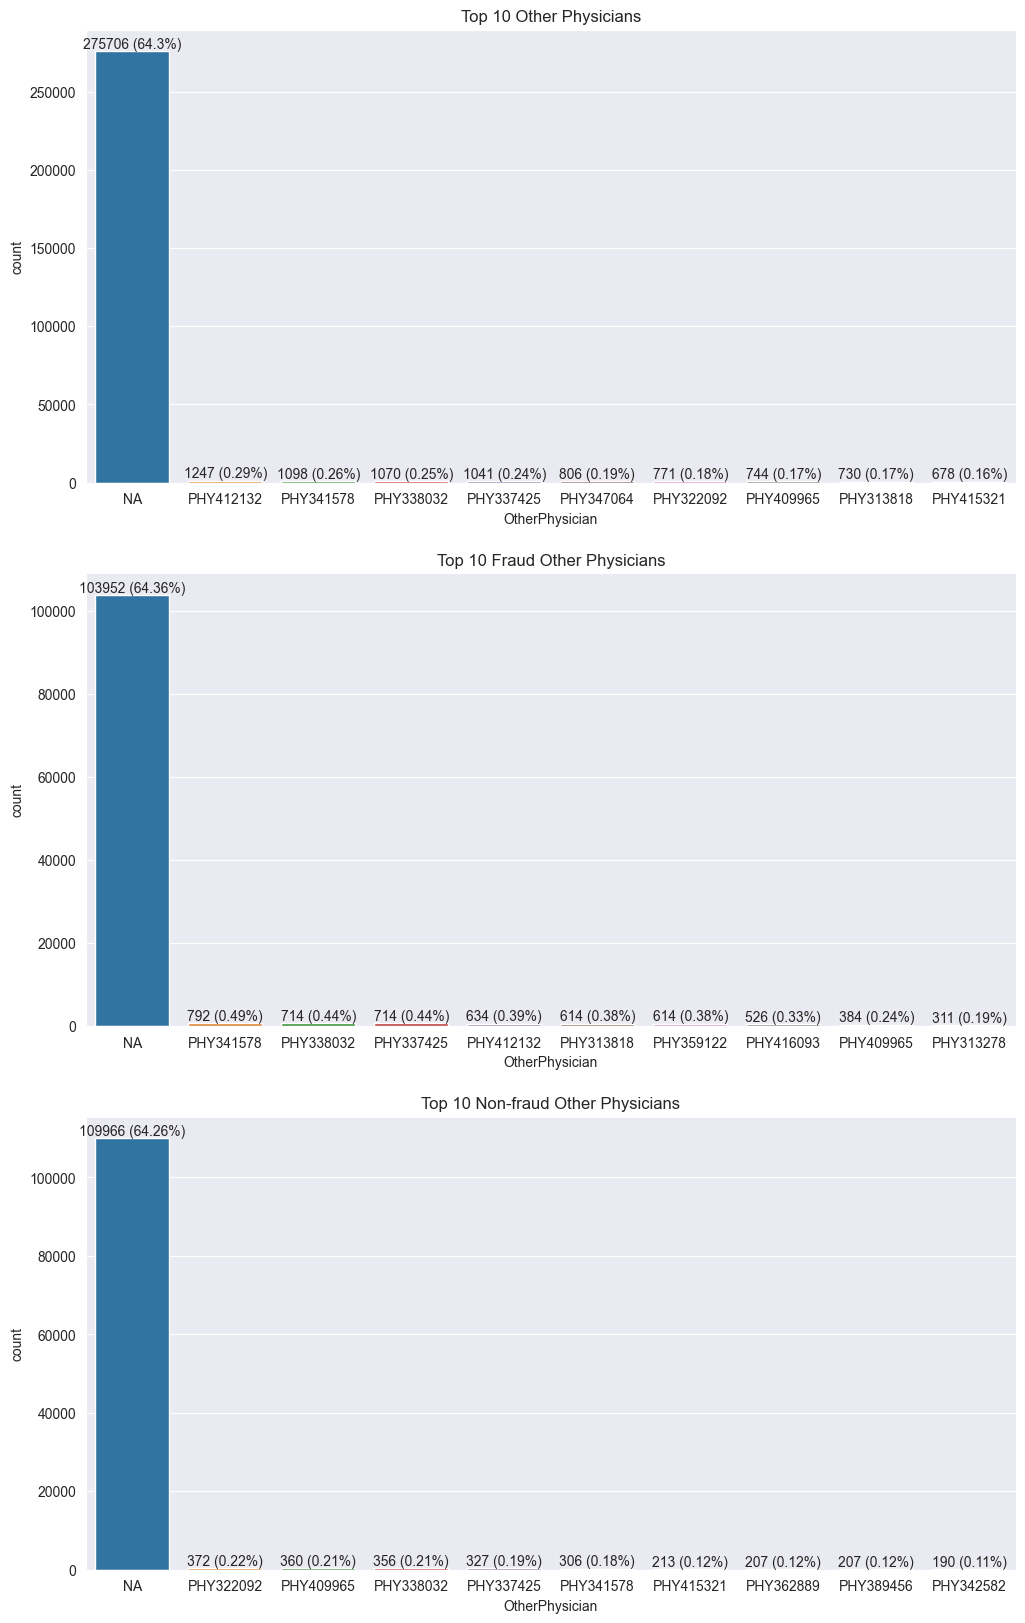

In [88]:
fig, (ax1, ax2, ax3) = pyplot.subplots(3,1,figsize=(12, 20))

sns.countplot(ax = ax1, x = all_patient['OtherPhysician'], order=all_patient.OtherPhysician.value_counts().iloc[:10].index)
ax1.set_title("Top 10 Other Physicians")
abs_values = all_patient['OtherPhysician'].value_counts(ascending=False).iloc[:10].values
lab = []
for h in abs_values:
  percent = str(round((h/all_patient.shape[0])*100,2)) + "%"
  label = str(h) + " (" + percent + ")"
  lab.append(label)
ax1.bar_label(container=ax1.containers[0], labels=lab)

sns.countplot(ax = ax2, x = fraud_patient['OtherPhysician'], order=fraud_patient.OtherPhysician.value_counts().iloc[:10].index)
ax2.set_title("Top 10 Fraud Other Physicians")
abs_values = fraud_patient['OtherPhysician'].value_counts(ascending=False).iloc[:10].values
lab = []
for i in abs_values:
  percent = str(round((i/fraud_patient.shape[0])*100,2)) + "%"
  label = str(i) + " (" + percent + ")"
  lab.append(label)
ax2.bar_label(container=ax2.containers[0], labels=lab)

sns.countplot(ax = ax3, x = nonfraud_patient['OtherPhysician'], order=nonfraud_patient.OtherPhysician.value_counts().iloc[:10].index)
ax3.set_title("Top 10 Non-fraud Other Physicians")
abs_values = nonfraud_patient['OtherPhysician'].value_counts(ascending=False).iloc[:10].values
lab = []
for j in abs_values:
  percent = str(round((j/nonfraud_patient.shape[0])*100,2)) + "%"
  label = str(j) + " (" + percent + ")"
  lab.append(label)
ax3.bar_label(container=ax3.containers[0], labels=lab)
fig.show()

For other physicians, we observe the same pattern where the top 10 physicians among all cases (excluding NA) are also the top 10 fraud physicians. This could mean that there are certain physicians that commit fraud for all their cases therefore resulting in the following distribution. Likewise, as this variable is a physician's ID, it will not be helpful to predict future cases.

### CLM Diagnosis Code Analysis

Now we try to study if there is any trend between specific diagnosis codes and potential fraud.

In [89]:
clmcode = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10']

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\4197551822.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\4197551822.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\4197551822.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\4197551822.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\4197551822.py:37: UserWarning: Matplotlib is currently using m

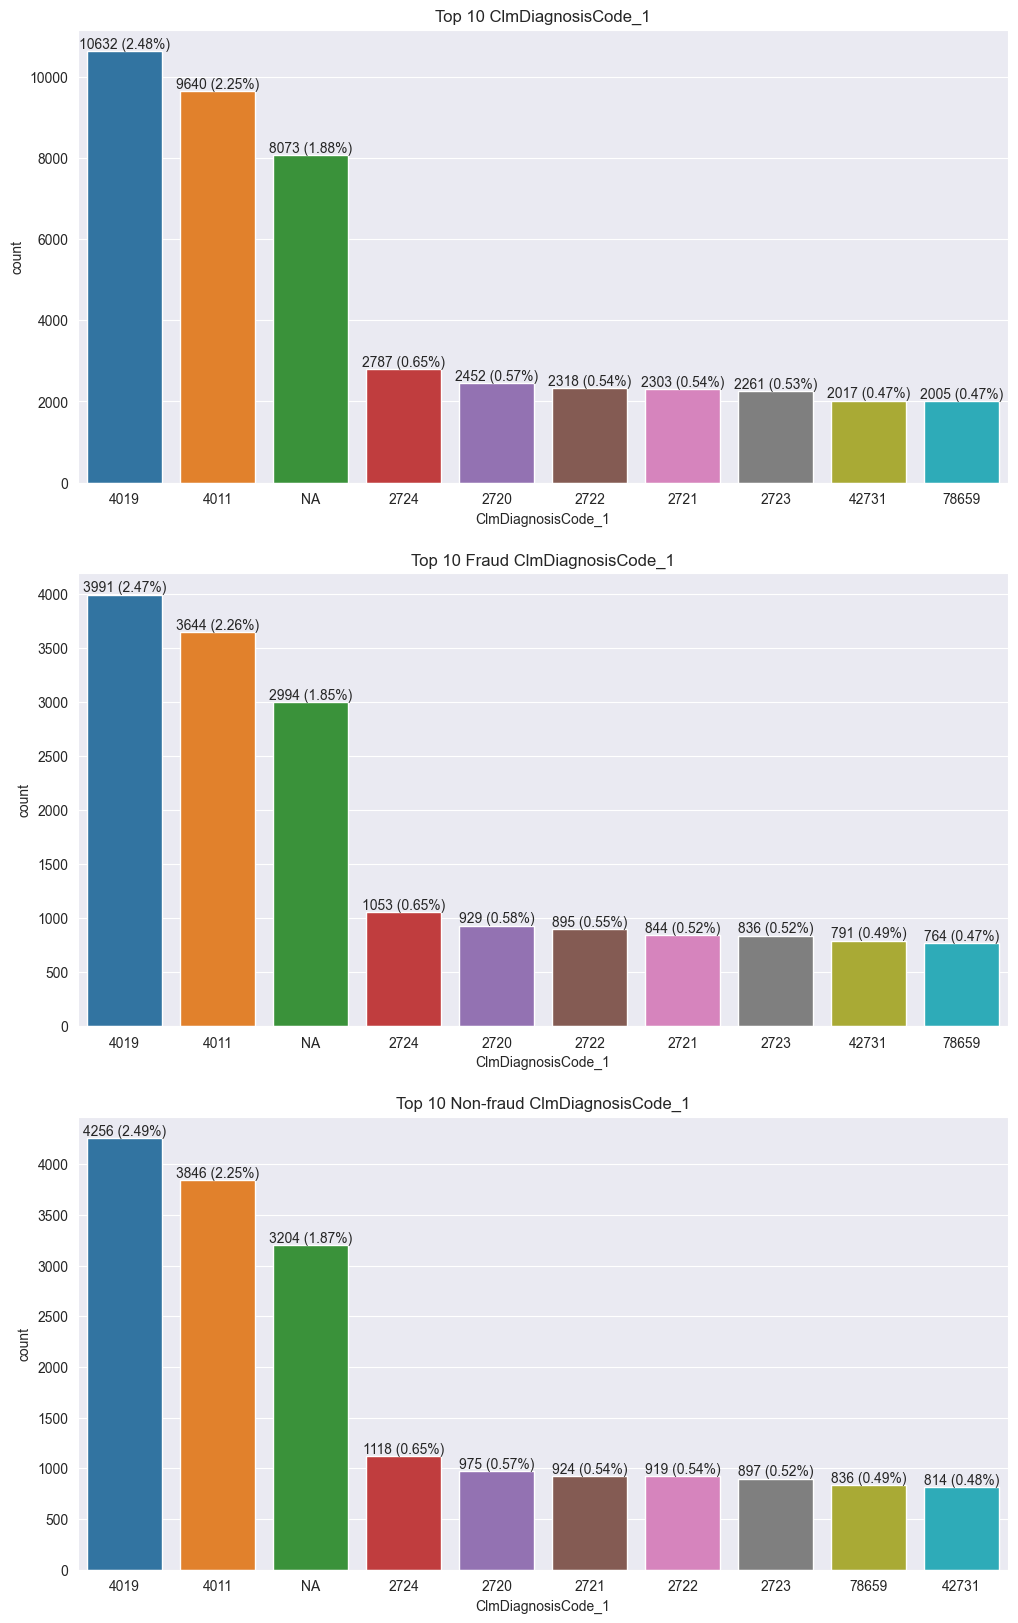

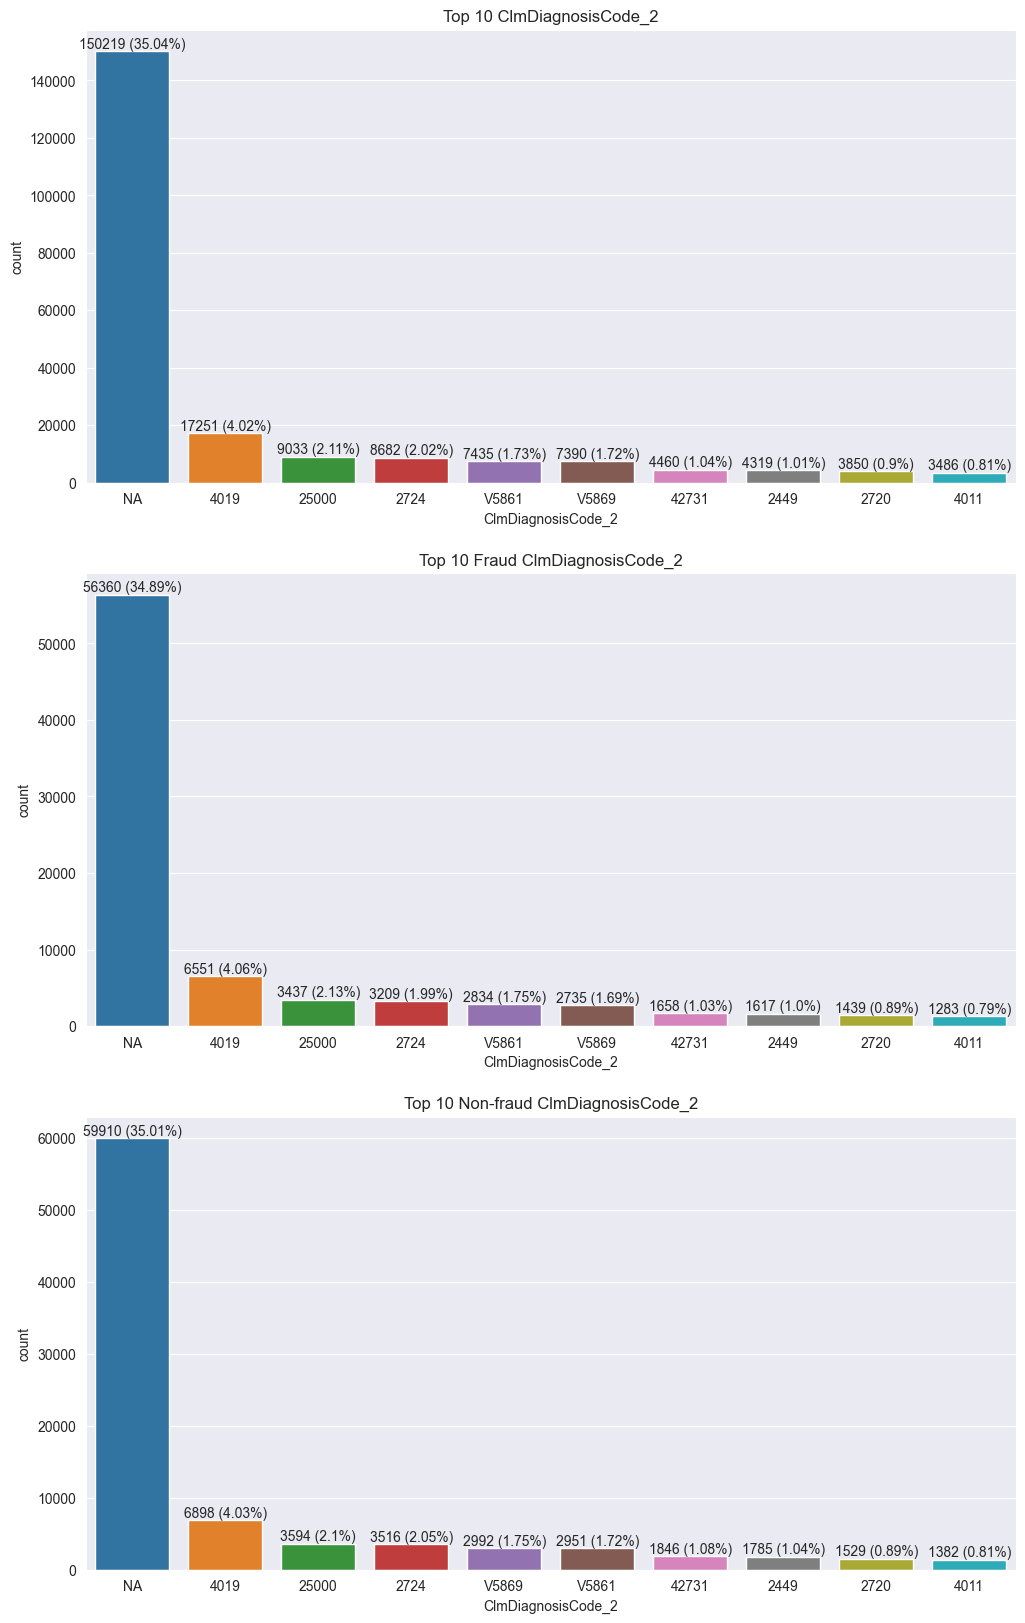

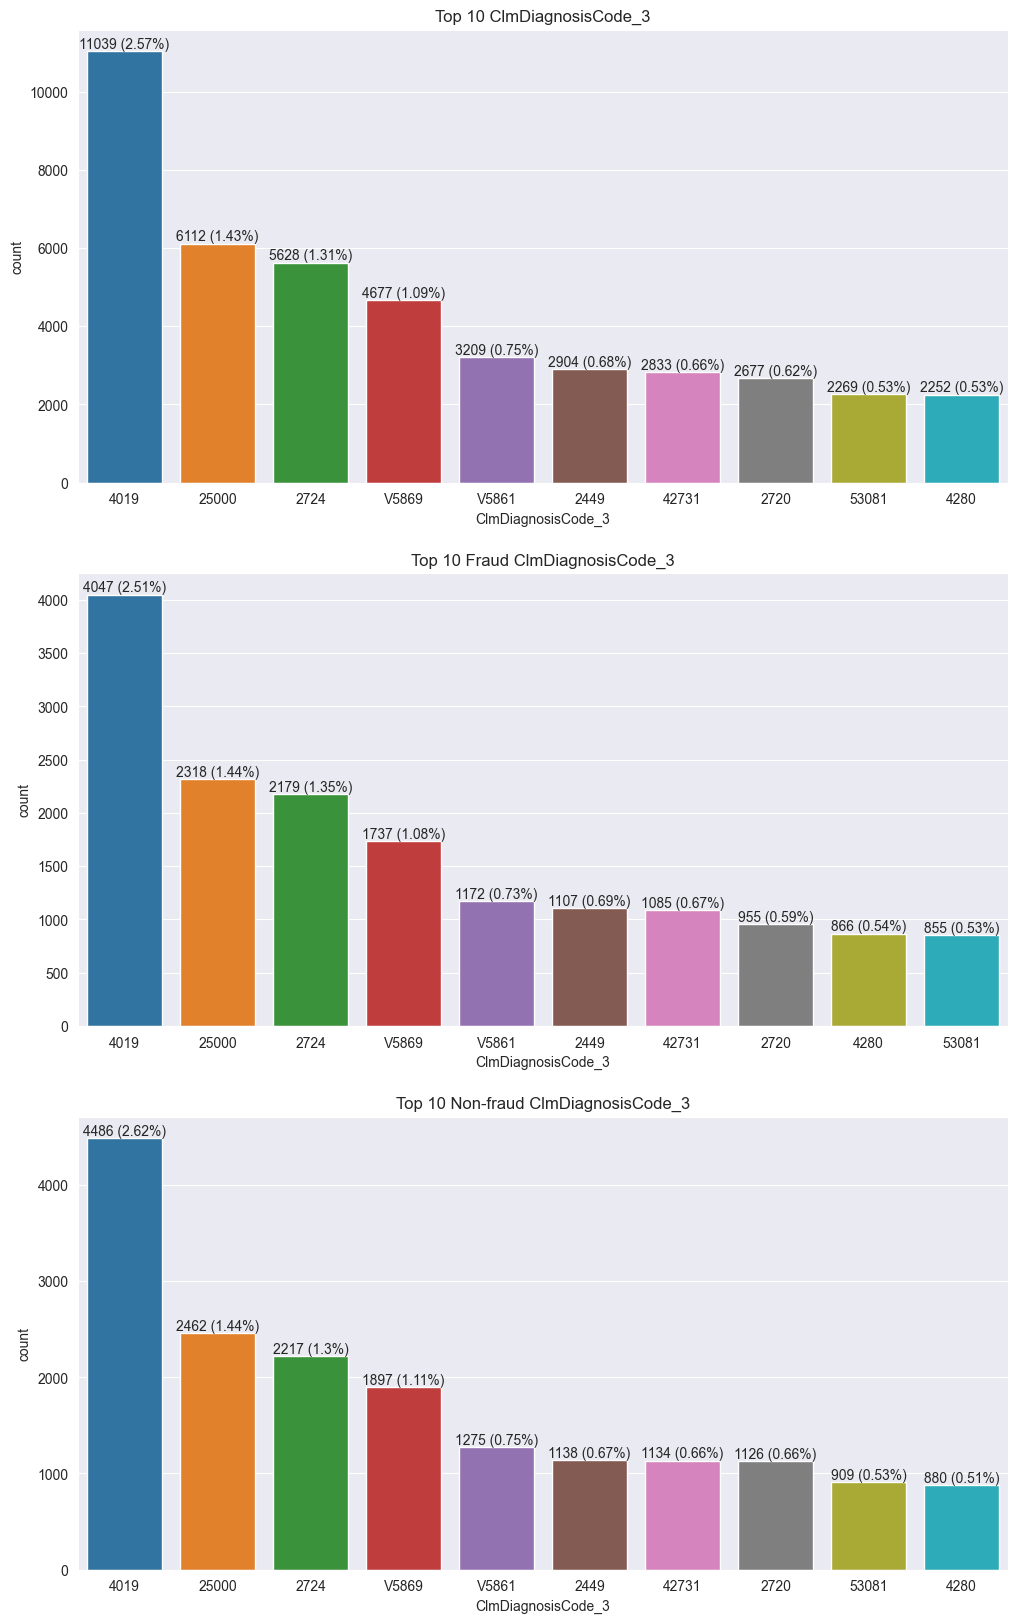

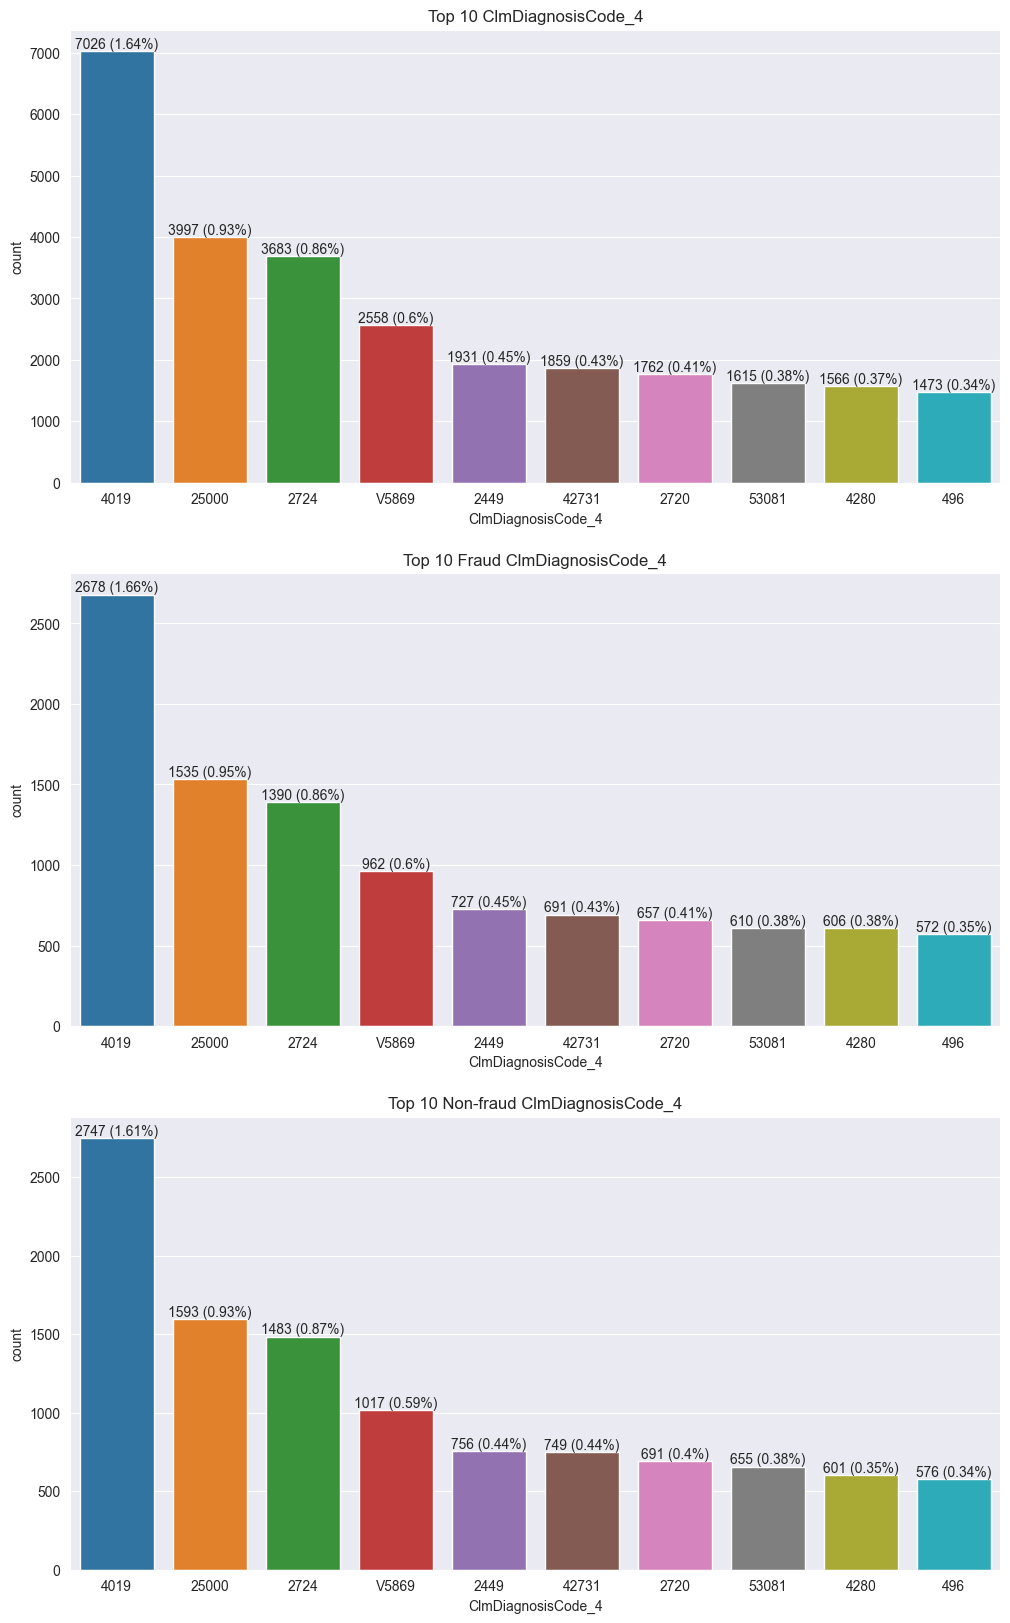

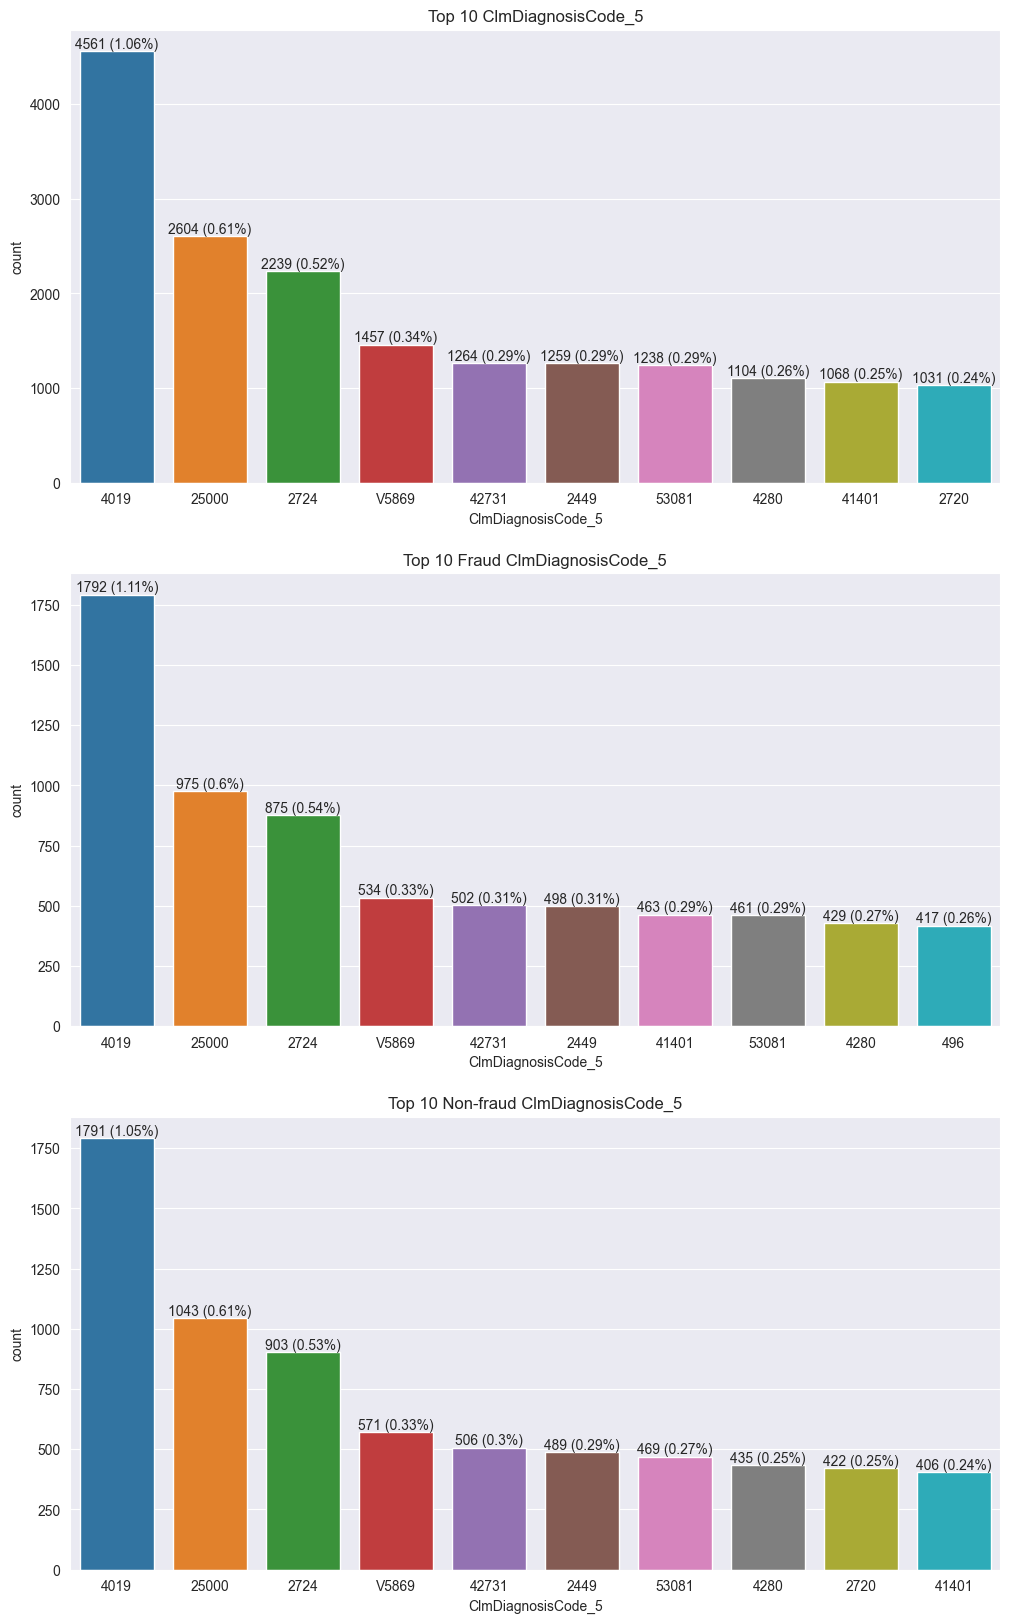

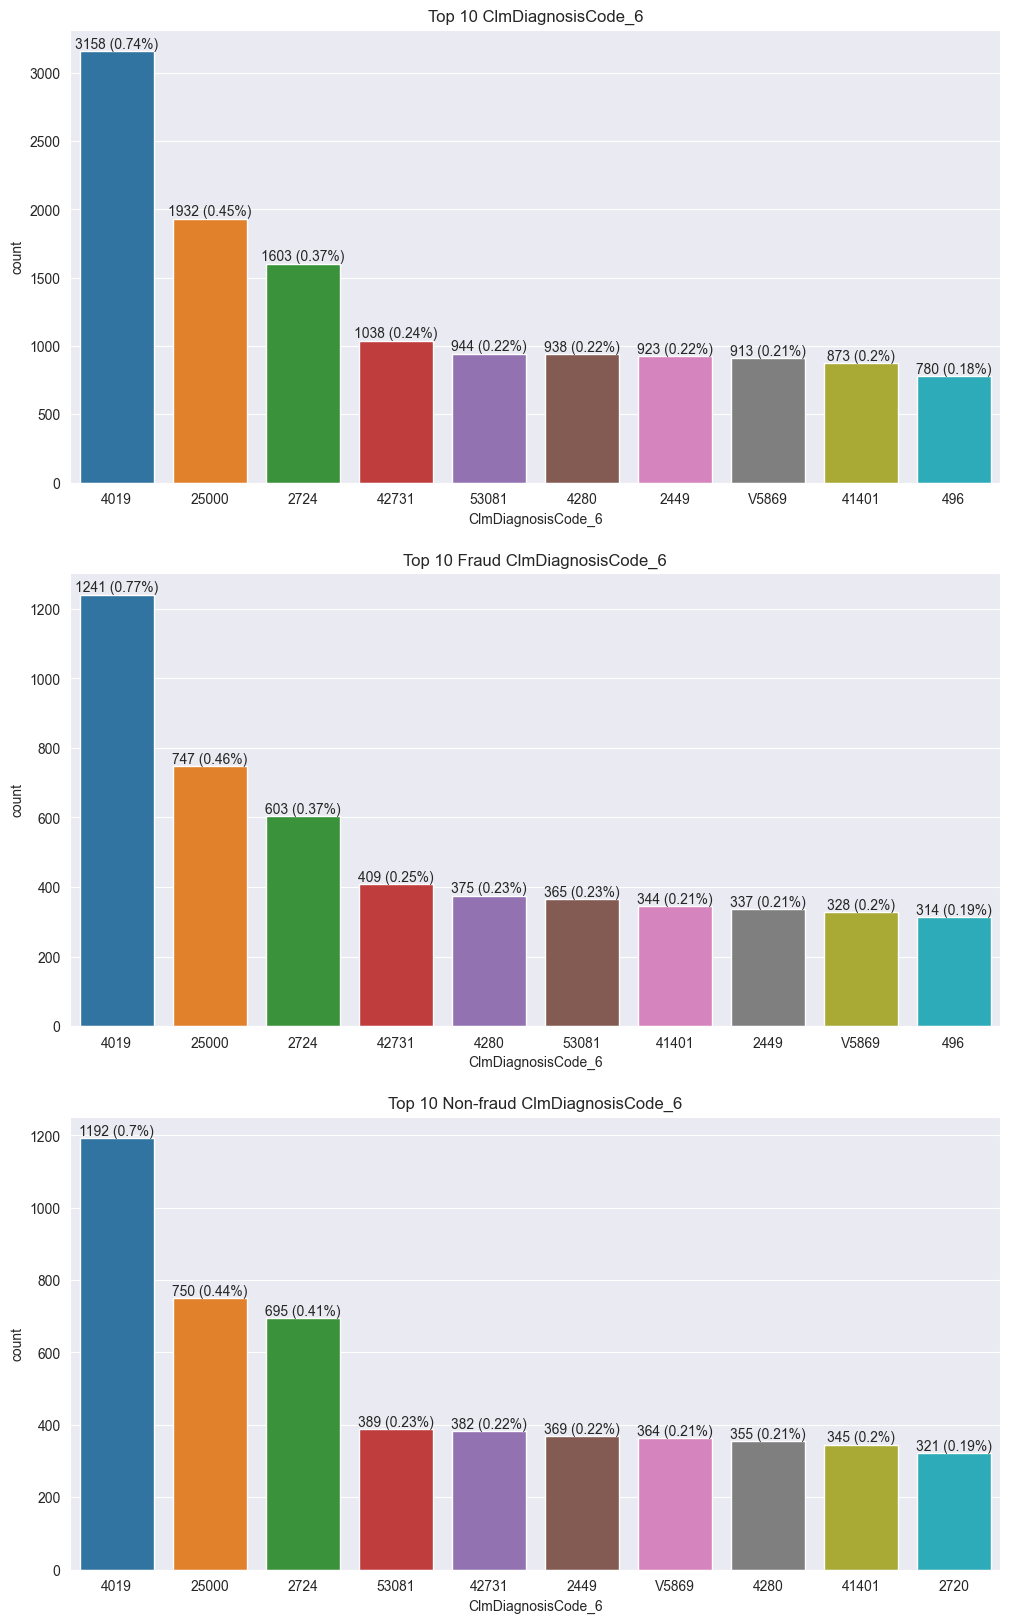

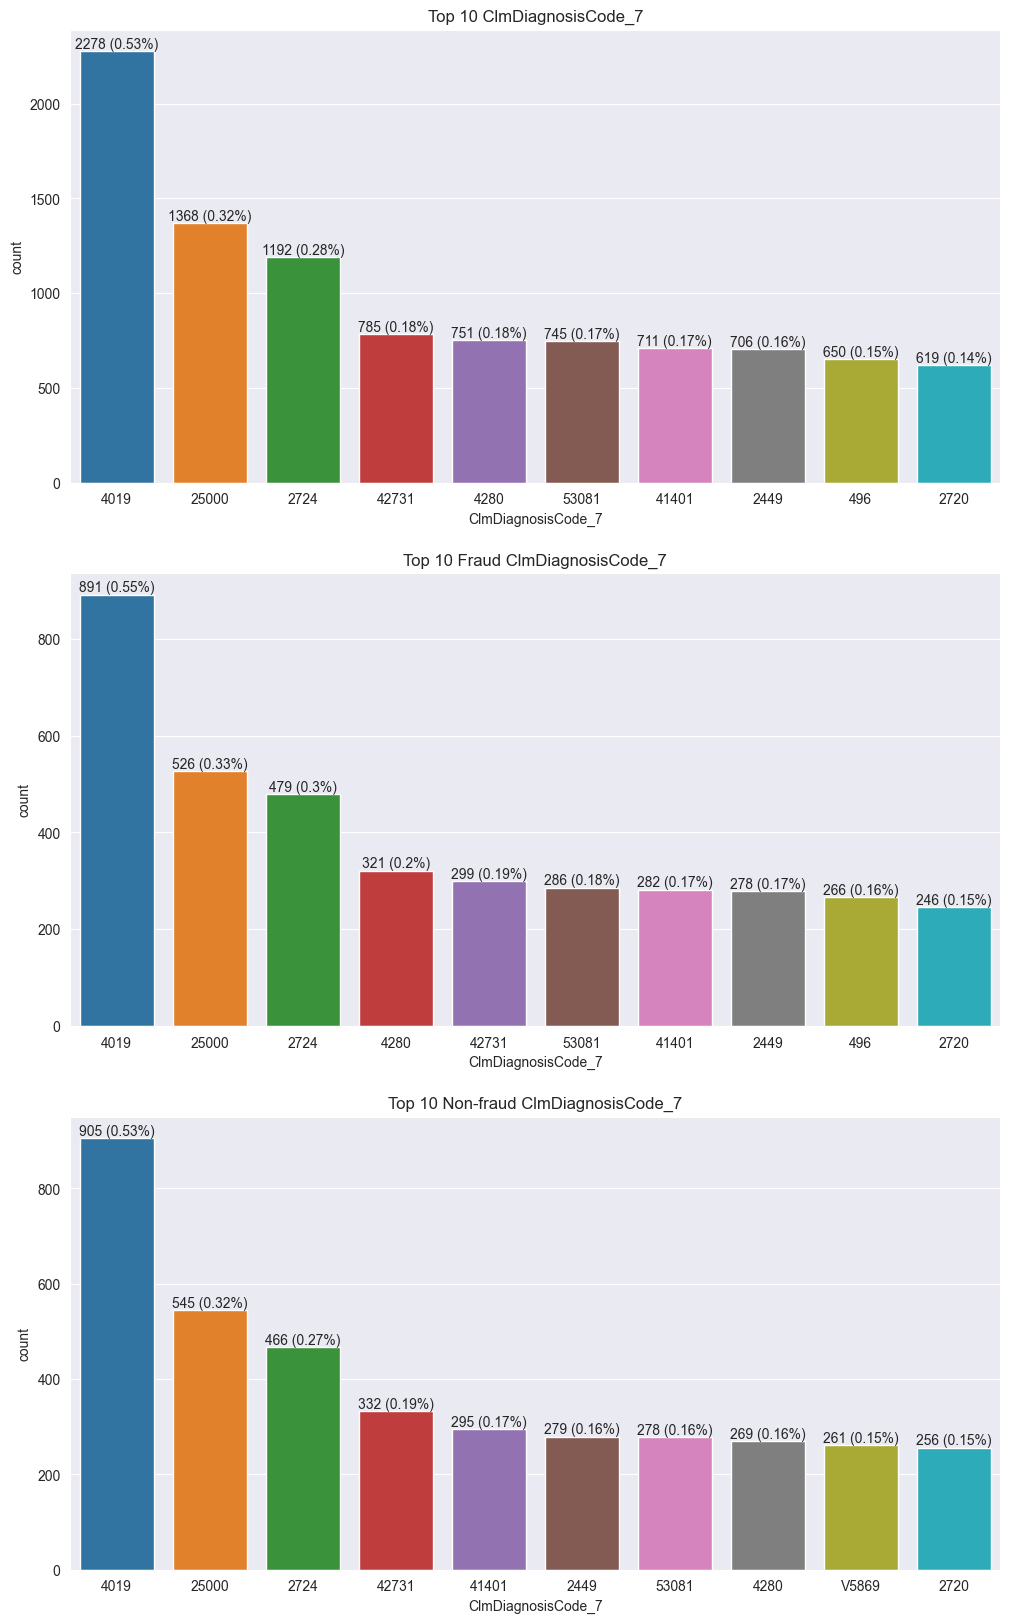

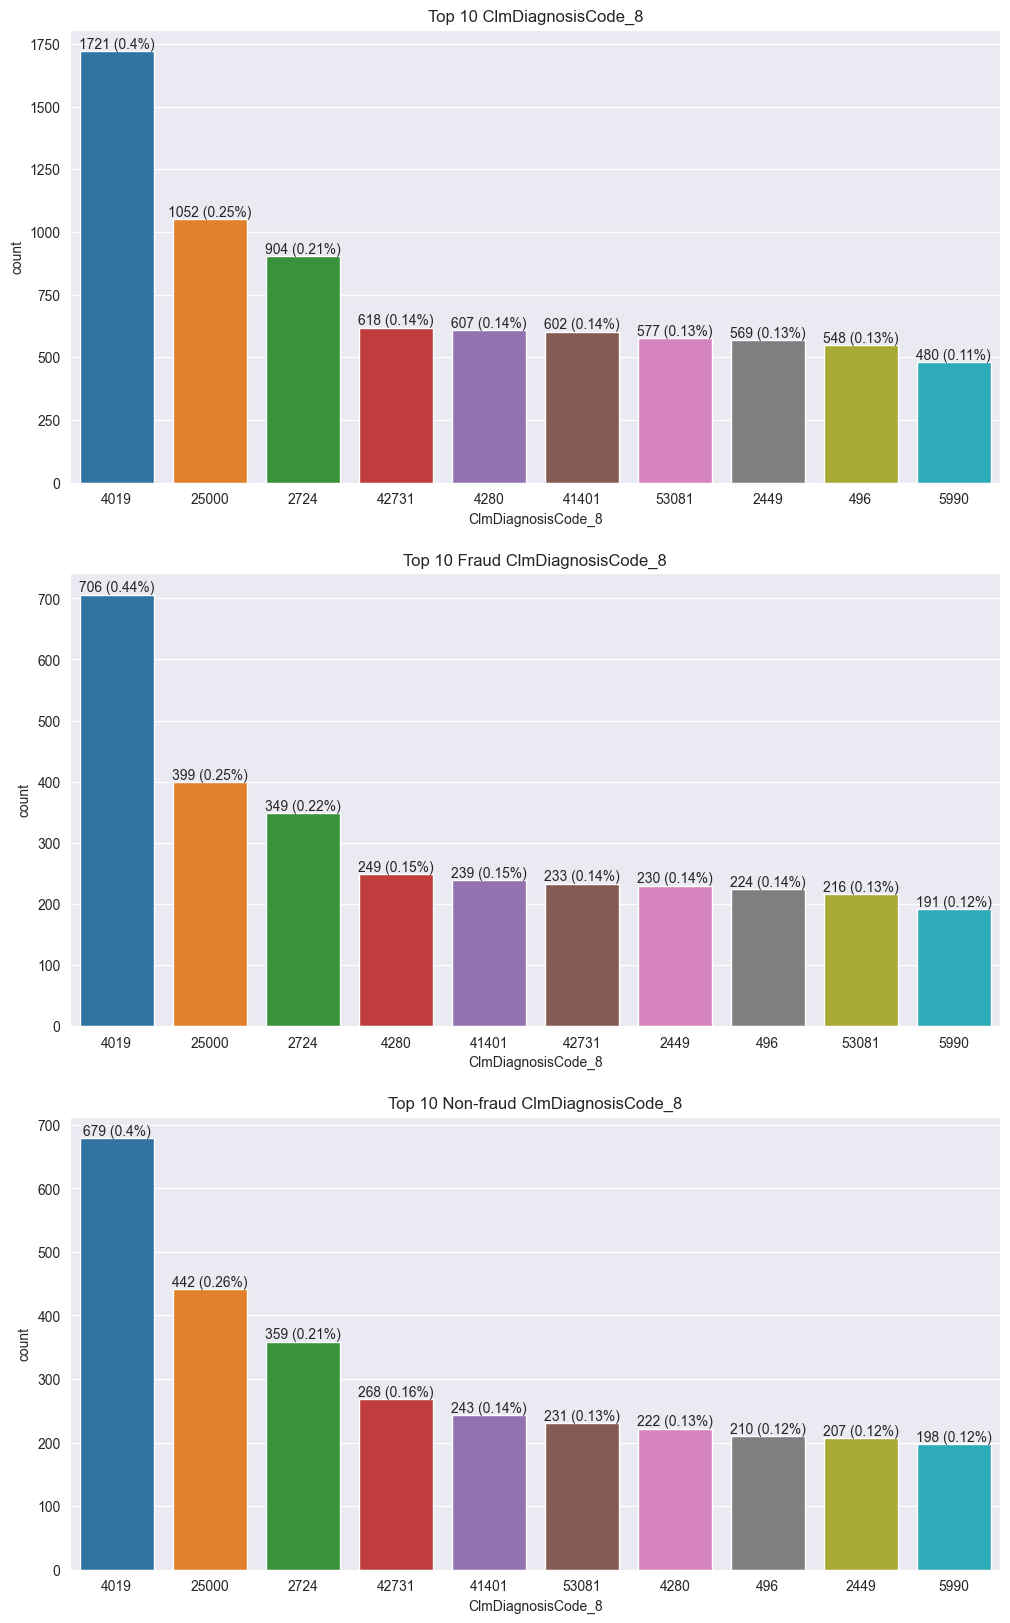

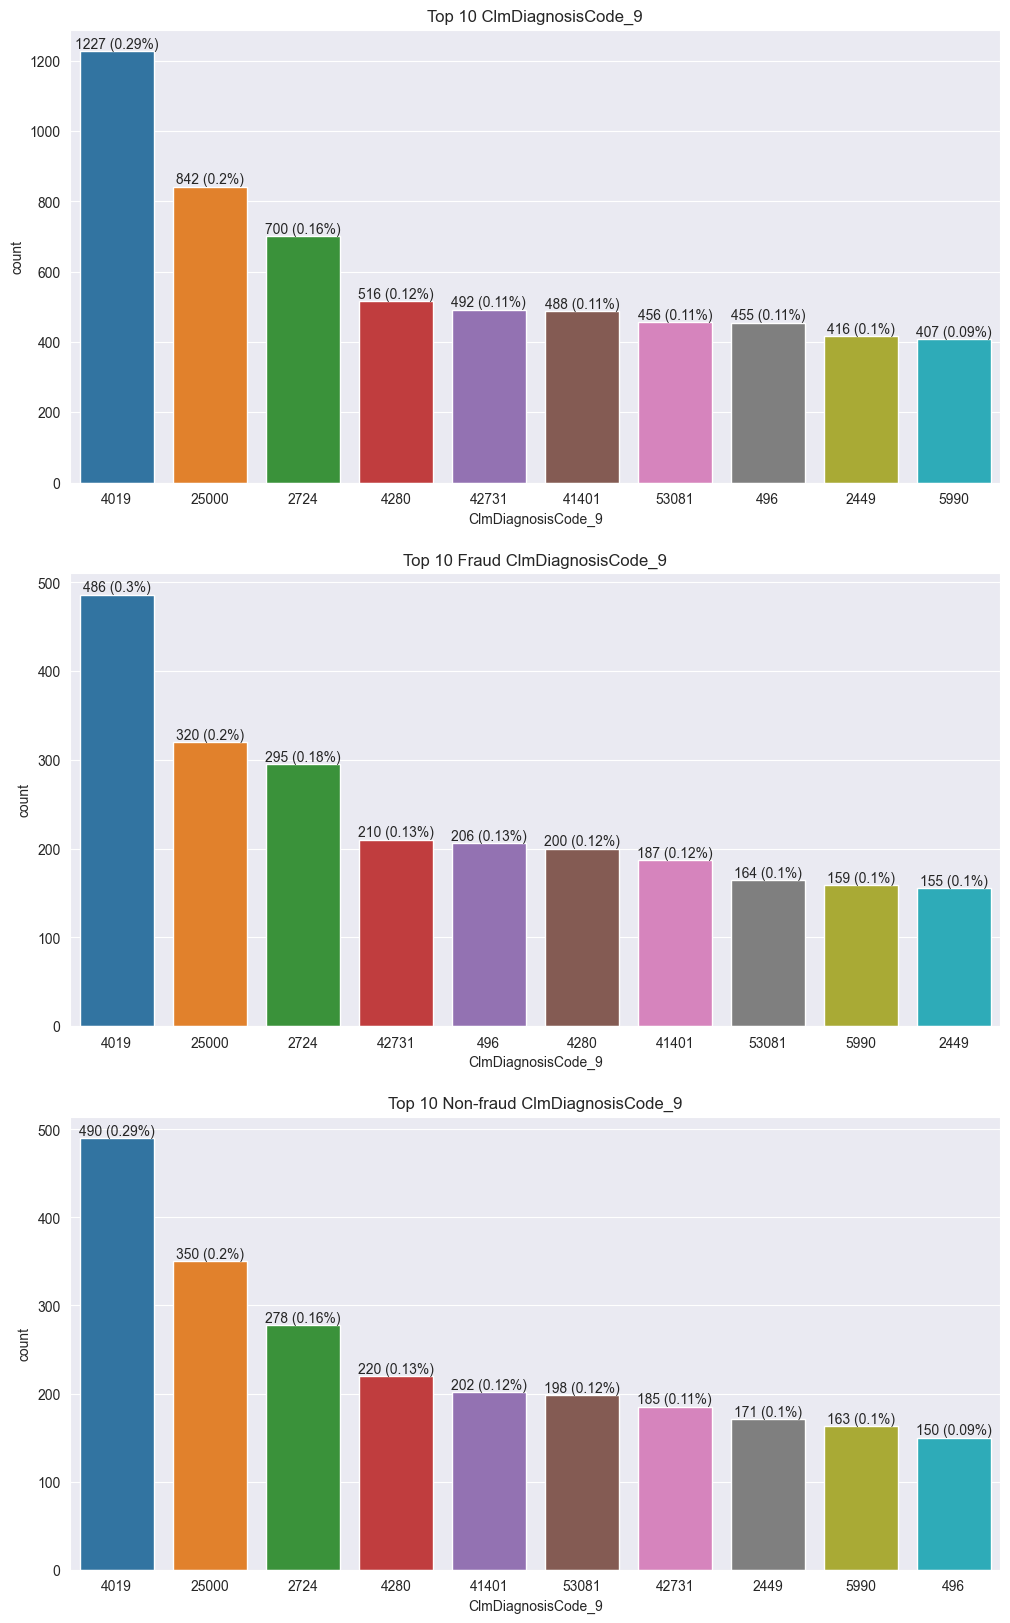

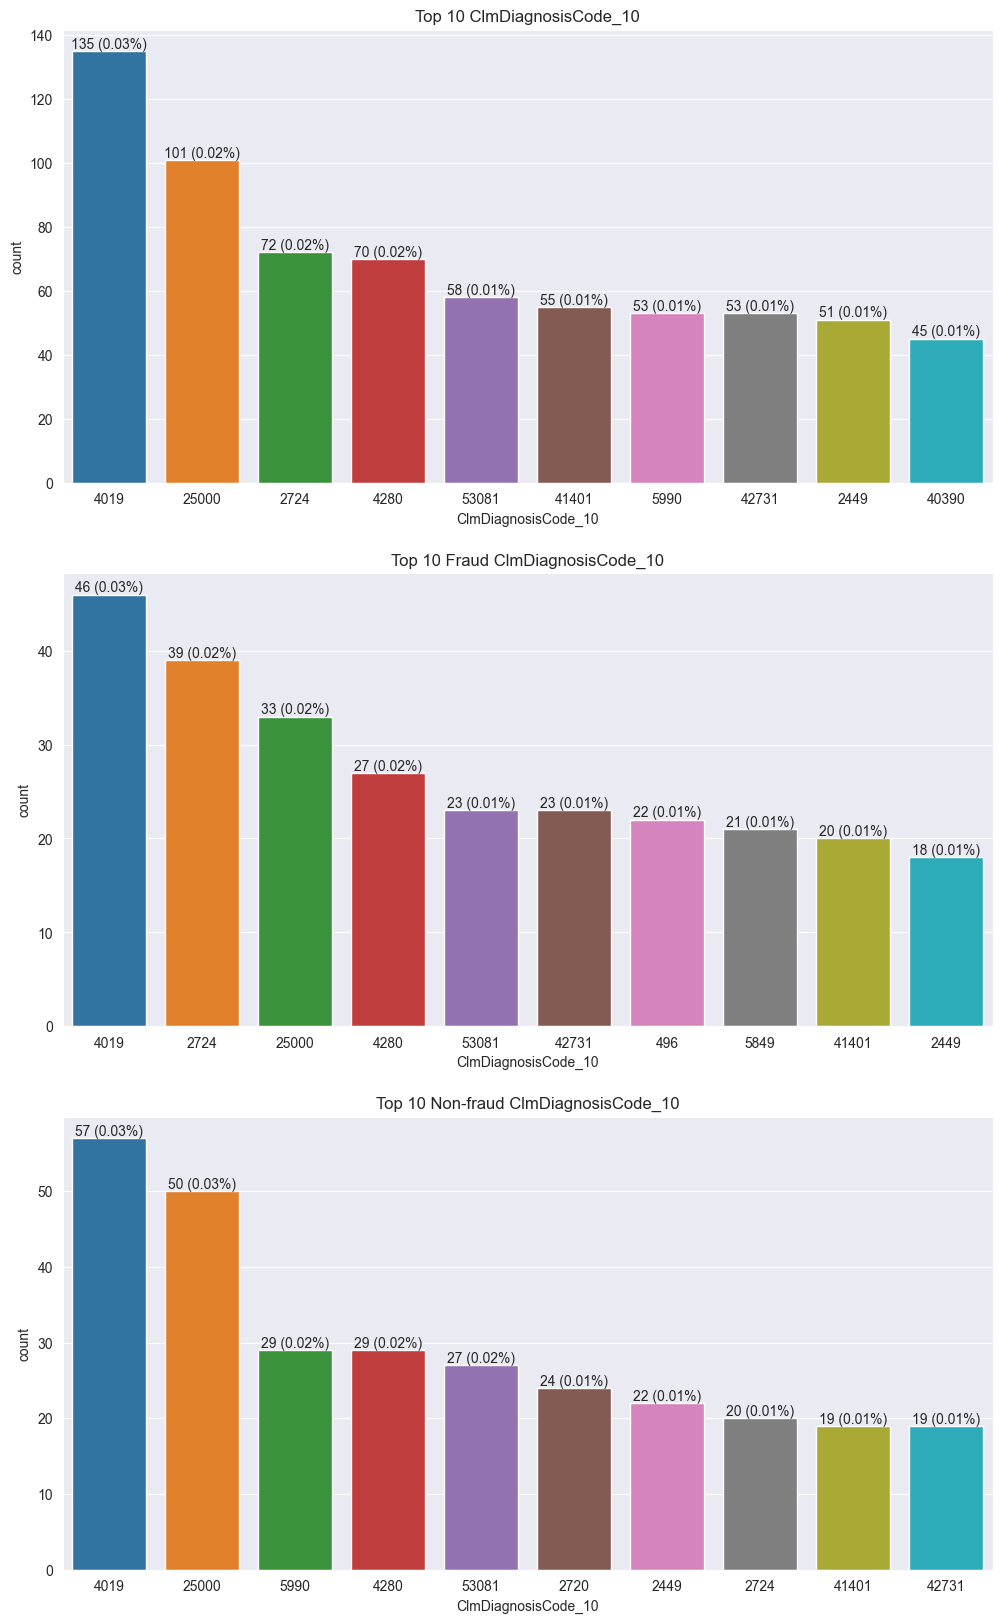

In [90]:
for i in clmcode:
    code = i
    fig, (ax1, ax2, ax3) = pyplot.subplots(3,1,figsize=(12, 20))

    sns.countplot(ax = ax1, x = all_patient[code], order=all_patient[code].value_counts().iloc[:10].index)
    title = "Top 10 " + code
    ax1.set_title(title)
    abs_values = all_patient[code].value_counts(ascending=False).iloc[:10].values
    lab = []
    for h in abs_values:
        percent = str(round((h/all_patient.shape[0])*100,2)) + "%"
        label = str(h) + " (" + percent + ")"
        lab.append(label)
    ax1.bar_label(container=ax1.containers[0], labels=lab)

    sns.countplot(ax = ax2, x = fraud_patient[code], order=fraud_patient[code].value_counts().iloc[:10].index)
    title2 = "Top 10 Fraud " + code
    ax2.set_title(title2)
    abs_values = fraud_patient[code].value_counts(ascending=False).iloc[:10].values
    lab = []
    for i in abs_values:
        percent = str(round((i/fraud_patient.shape[0])*100,2)) + "%"
        label = str(i) + " (" + percent + ")"
        lab.append(label)
    ax2.bar_label(container=ax2.containers[0], labels=lab)

    sns.countplot(ax = ax3, x = nonfraud_patient[code], order=nonfraud_patient[code].value_counts().iloc[:10].index)
    title3 = "Top 10 Non-fraud " + code
    ax3.set_title(title3)
    abs_values = nonfraud_patient[code].value_counts(ascending=False).iloc[:10].values
    lab = []
    for j in abs_values:
        percent = str(round((j/nonfraud_patient.shape[0])*100,2)) + "%"
        label = str(j) + " (" + percent + ")"
        lab.append(label)
    ax3.bar_label(container=ax3.containers[0], labels=lab)
    fig.show()

In [91]:
f = fraud_patient[clmcode].count()
nf = all_patient[clmcode].count()
f_df = pd.DataFrame({'label':f.index, 'values':f.values})
nf_df = pd.DataFrame({'label':nf.index, 'values':nf.values})

<AxesSubplot: >

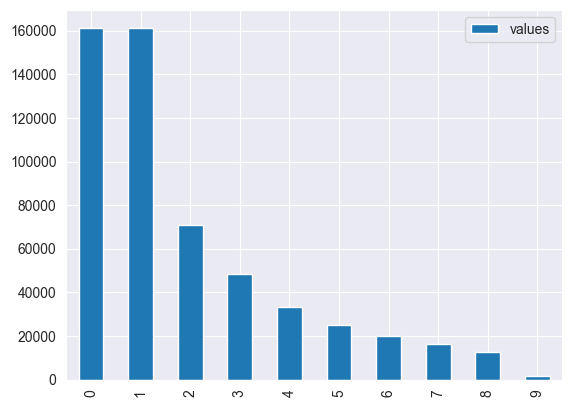

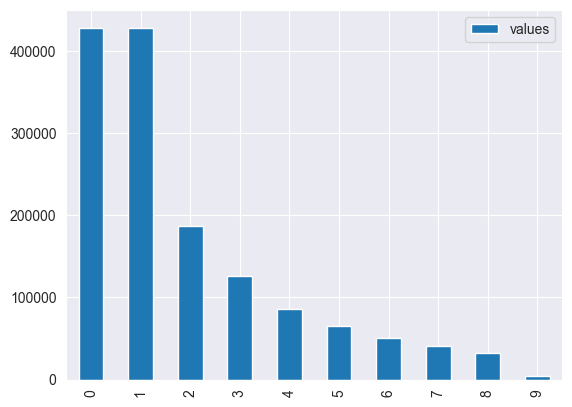

In [92]:
f_df.plot.bar()
nf_df.plot.bar()

The distribution of Claim Dianogsis code is similar for fraud and non-fraud, where majority is code 1, 2 and 3. Let's explore them further below.

From the initial analysis of the top 10 CLM Dianosis Code 1 for all patients, fraud patients and non-fraud patients, we can see that there is not obvious difference between the distribution. Likewise for CLM Diagnosis Code 2-10, there is no obvious distinction between fraud and non-fraud distribution.

Now we want to check if there is any trend between the number of CLM Diagnosis Codes and fraud.

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\1396495270.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


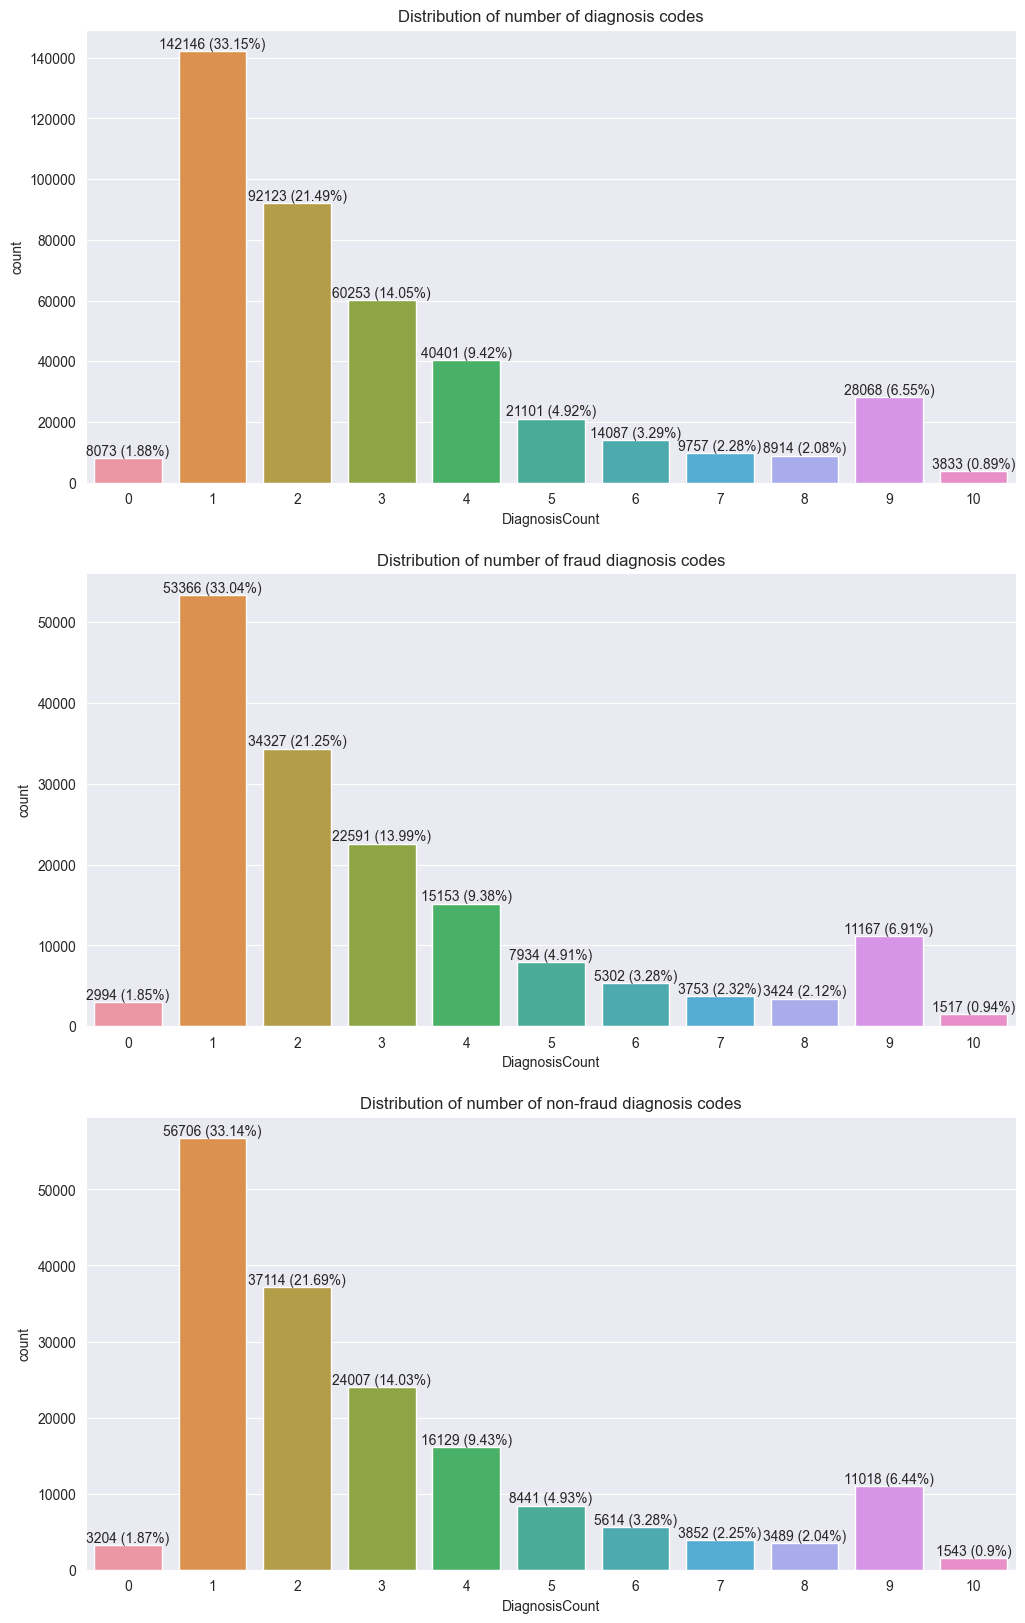

In [93]:
fig, (ax1, ax2, ax3) = pyplot.subplots(3,1,figsize=(12, 20))
sns.countplot(ax = ax1, x = all_patient['DiagnosisCount'], order=all_patient.DiagnosisCount.value_counts().sort_index().index)
ax1.set_title("Distribution of number of diagnosis codes")
abs_values = all_patient['DiagnosisCount'].value_counts().sort_index().values
lab = []
for h in abs_values:
  percent = str(round((h/all_patient.shape[0])*100,2)) + "%"
  label = str(h) + " (" + percent + ")"
  lab.append(label)
ax1.bar_label(container=ax1.containers[0], labels=lab)

sns.countplot(ax = ax2, x = fraud_patient['DiagnosisCount'], order=fraud_patient.DiagnosisCount.value_counts().sort_index().index)
ax2.set_title("Distribution of number of fraud diagnosis codes")
abs_values = fraud_patient['DiagnosisCount'].value_counts().sort_index().values
lab = []
for i in abs_values:
  percent = str(round((i/fraud_patient.shape[0])*100,2)) + "%"
  label = str(i) + " (" + percent + ")"
  lab.append(label)
ax2.bar_label(container=ax2.containers[0], labels=lab)

sns.countplot(ax = ax3, x = nonfraud_patient['DiagnosisCount'], order=nonfraud_patient.DiagnosisCount.value_counts().sort_index().index)
ax3.set_title("Distribution of number of non-fraud diagnosis codes")
abs_values = nonfraud_patient['DiagnosisCount'].value_counts().sort_index().values
lab = []
for j in abs_values:
  percent = str(round((j/nonfraud_patient.shape[0])*100,2)) + "%"
  label = str(j) + " (" + percent + ")"
  lab.append(label)
ax3.bar_label(container=ax3.containers[0], labels=lab)
fig.show()

From the distributions above, we can see that for both fraud and non-fraud cases, the distribution of the number of diagnosis codes are similar. Therefore, there is no obvious trend between the number of diagnosis codes and whether the case is fraud or not.

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\2684435528.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


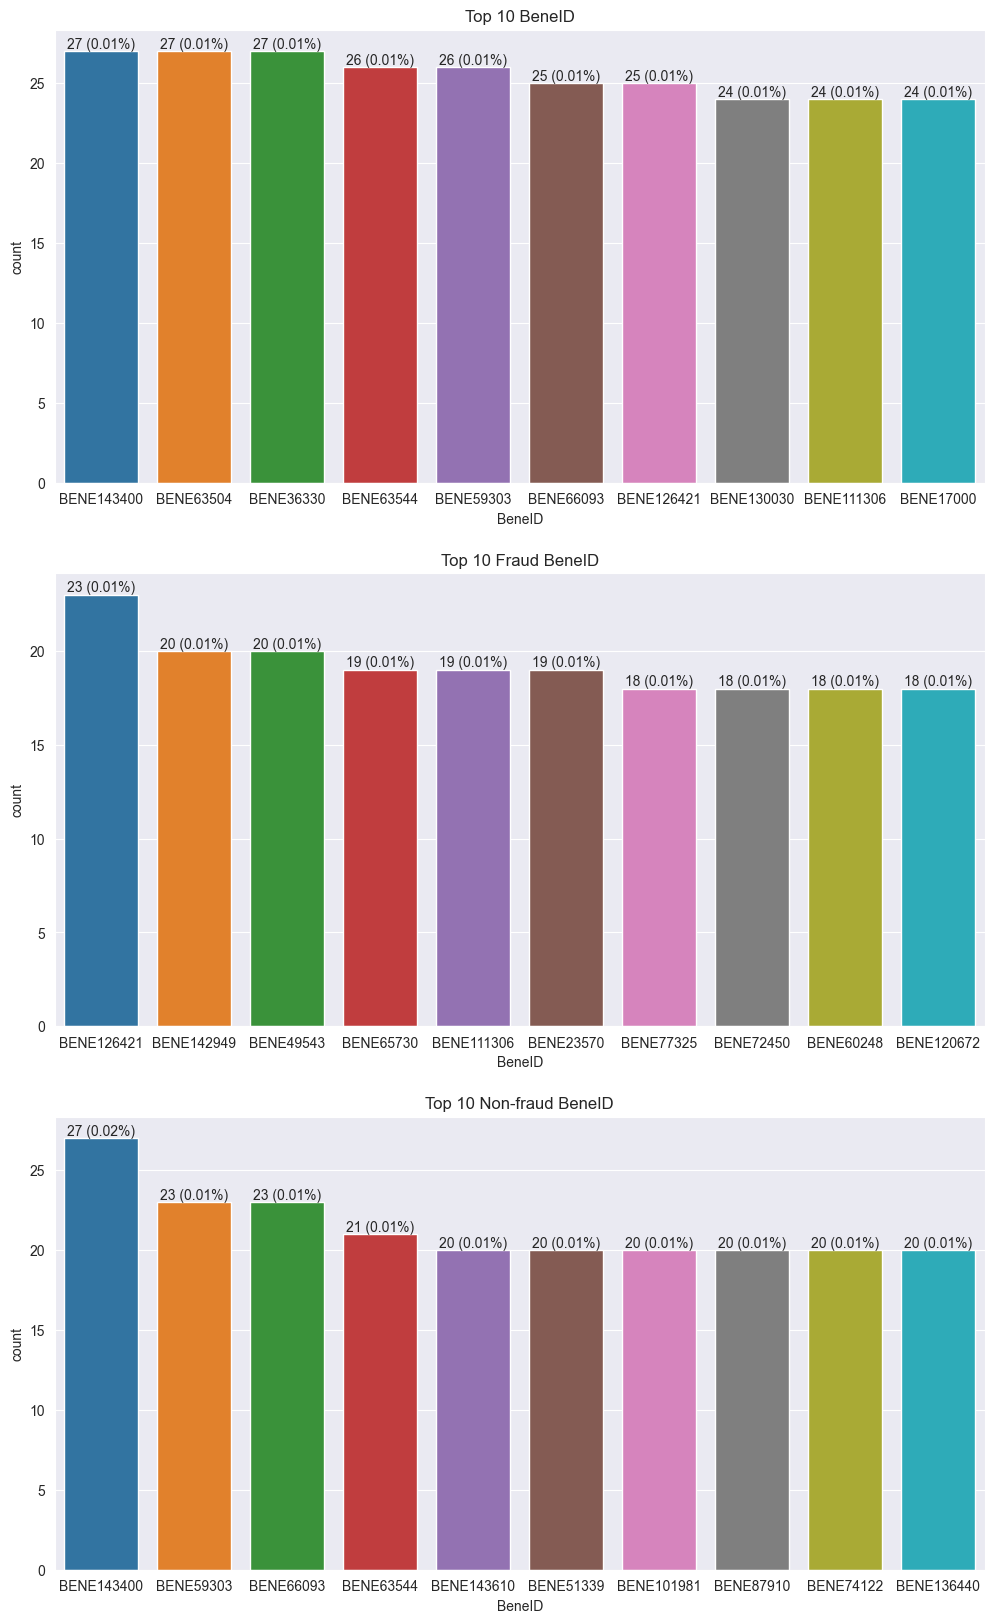

In [94]:
fig, (ax1, ax2, ax3) = pyplot.subplots(3,1,figsize=(12, 20))

sns.countplot(ax = ax1, x = all_patient['BeneID'], order=all_patient.BeneID.value_counts().iloc[:10].index)
ax1.set_title("Top 10 BeneID")
abs_values = all_patient['BeneID'].value_counts(ascending=False).iloc[:10].values
lab = []
for h in abs_values:
  percent = str(round((h/all_patient.shape[0])*100,2)) + "%"
  label = str(h) + " (" + percent + ")"
  lab.append(label)
ax1.bar_label(container=ax1.containers[0], labels=lab)

sns.countplot(ax = ax2, x = fraud_patient['BeneID'], order=fraud_patient.BeneID.value_counts().iloc[:10].index)
ax2.set_title("Top 10 Fraud BeneID")
abs_values = fraud_patient['BeneID'].value_counts(ascending=False).iloc[:10].values
lab = []
for i in abs_values:
  percent = str(round((i/fraud_patient.shape[0])*100,2)) + "%"
  label = str(i) + " (" + percent + ")"
  lab.append(label)
ax2.bar_label(container=ax2.containers[0], labels=lab)

sns.countplot(ax = ax3, x = nonfraud_patient['BeneID'], order=nonfraud_patient.BeneID.value_counts().iloc[:10].index)
ax3.set_title("Top 10 Non-fraud BeneID")
abs_values = nonfraud_patient['BeneID'].value_counts(ascending=False).iloc[:10].values
lab = []
for j in abs_values:
  percent = str(round((j/nonfraud_patient.shape[0])*100,2)) + "%"
  label = str(j) + " (" + percent + ")"
  lab.append(label)
ax3.bar_label(container=ax3.containers[0], labels=lab)
fig.show()


### CLM Procedure Code Analysis

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\2690986591.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


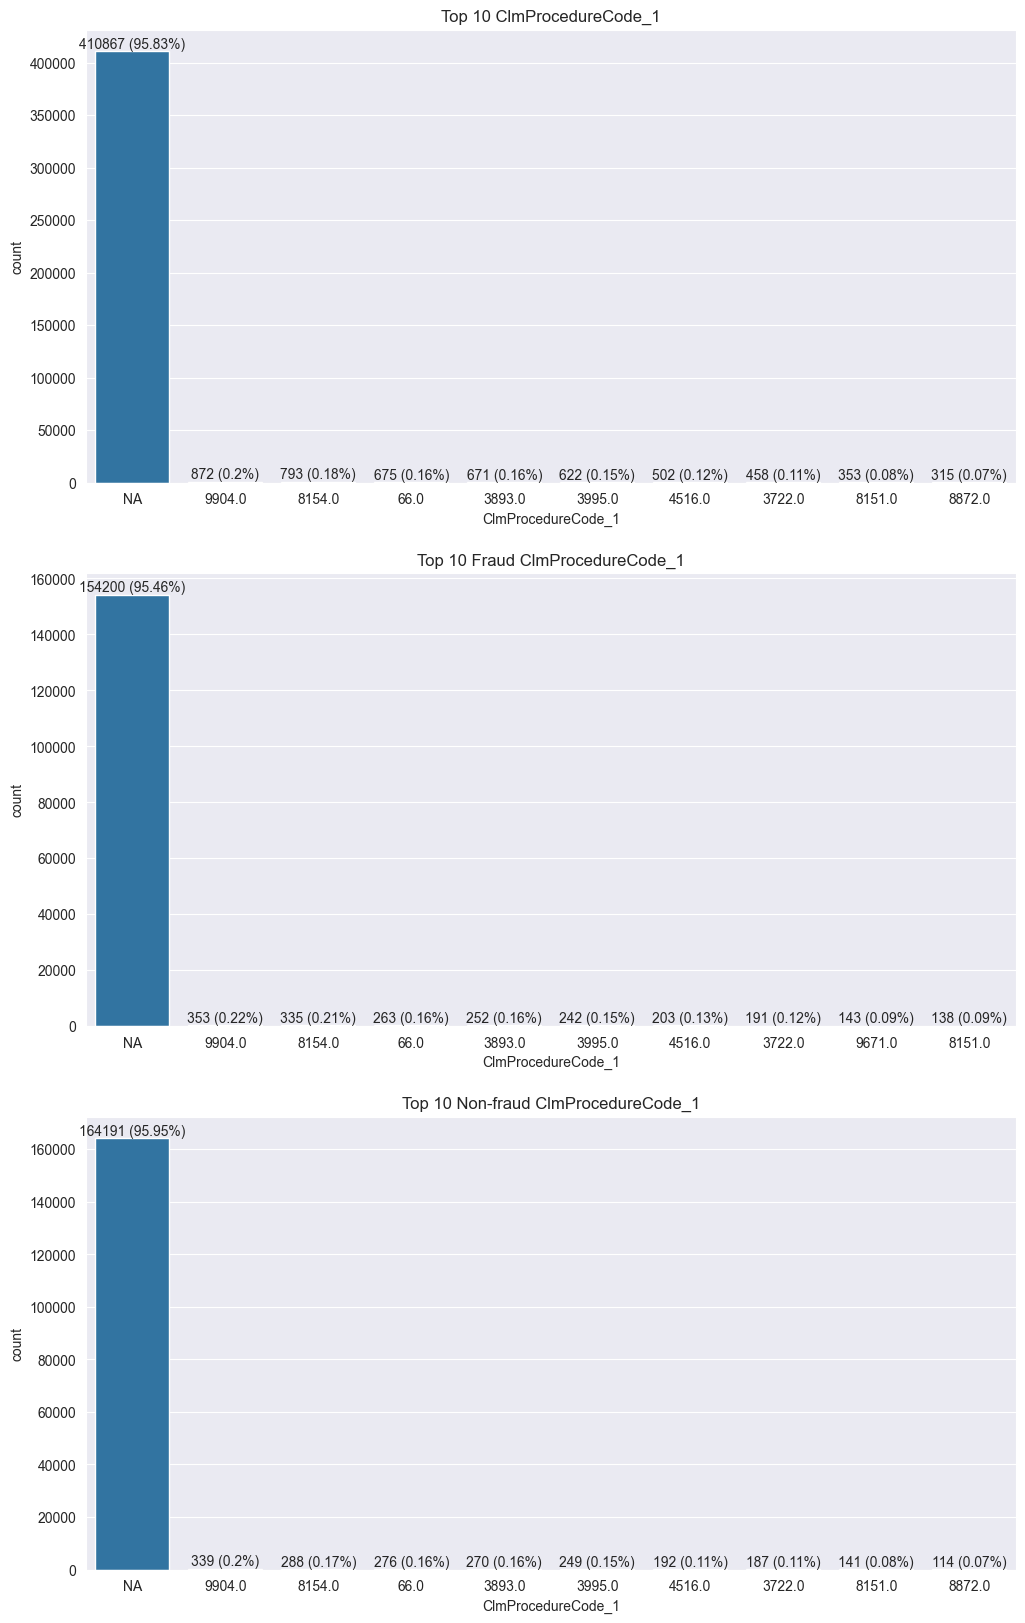

In [95]:
fig, (ax1, ax2, ax3) = pyplot.subplots(3,1,figsize=(12, 20))

sns.countplot(ax = ax1, x = all_patient['ClmProcedureCode_1'], order=all_patient.ClmProcedureCode_1.value_counts().iloc[:10].index)
ax1.set_title("Top 10 ClmProcedureCode_1")
abs_values = all_patient['ClmProcedureCode_1'].value_counts(ascending=False).iloc[:10].values
lab = []
for h in abs_values:
  percent = str(round((h/all_patient.shape[0])*100,2)) + "%"
  label = str(h) + " (" + percent + ")"
  lab.append(label)
ax1.bar_label(container=ax1.containers[0], labels=lab)

sns.countplot(ax = ax2, x = fraud_patient['ClmProcedureCode_1'], order=fraud_patient.ClmProcedureCode_1.value_counts().iloc[:10].index)
ax2.set_title("Top 10 Fraud ClmProcedureCode_1")
abs_values = fraud_patient['ClmProcedureCode_1'].value_counts(ascending=False).iloc[:10].values
lab = []
for i in abs_values:
  percent = str(round((i/fraud_patient.shape[0])*100,2)) + "%"
  label = str(i) + " (" + percent + ")"
  lab.append(label)
ax2.bar_label(container=ax2.containers[0], labels=lab)

sns.countplot(ax = ax3, x = nonfraud_patient['ClmProcedureCode_1'], order=nonfraud_patient.ClmProcedureCode_1.value_counts().iloc[:10].index)
ax3.set_title("Top 10 Non-fraud ClmProcedureCode_1")
abs_values = nonfraud_patient['ClmProcedureCode_1'].value_counts(ascending=False).iloc[:10].values
lab = []
for j in abs_values:
  percent = str(round((j/nonfraud_patient.shape[0])*100,2)) + "%"
  label = str(j) + " (" + percent + ")"
  lab.append(label)
ax3.bar_label(container=ax3.containers[0], labels=lab)
fig.show()

From the plot, we can see that the same few procude codes appear in all 3 graphs. This could mean that these procedures are more common and therefore conducted more.

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\740618156.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


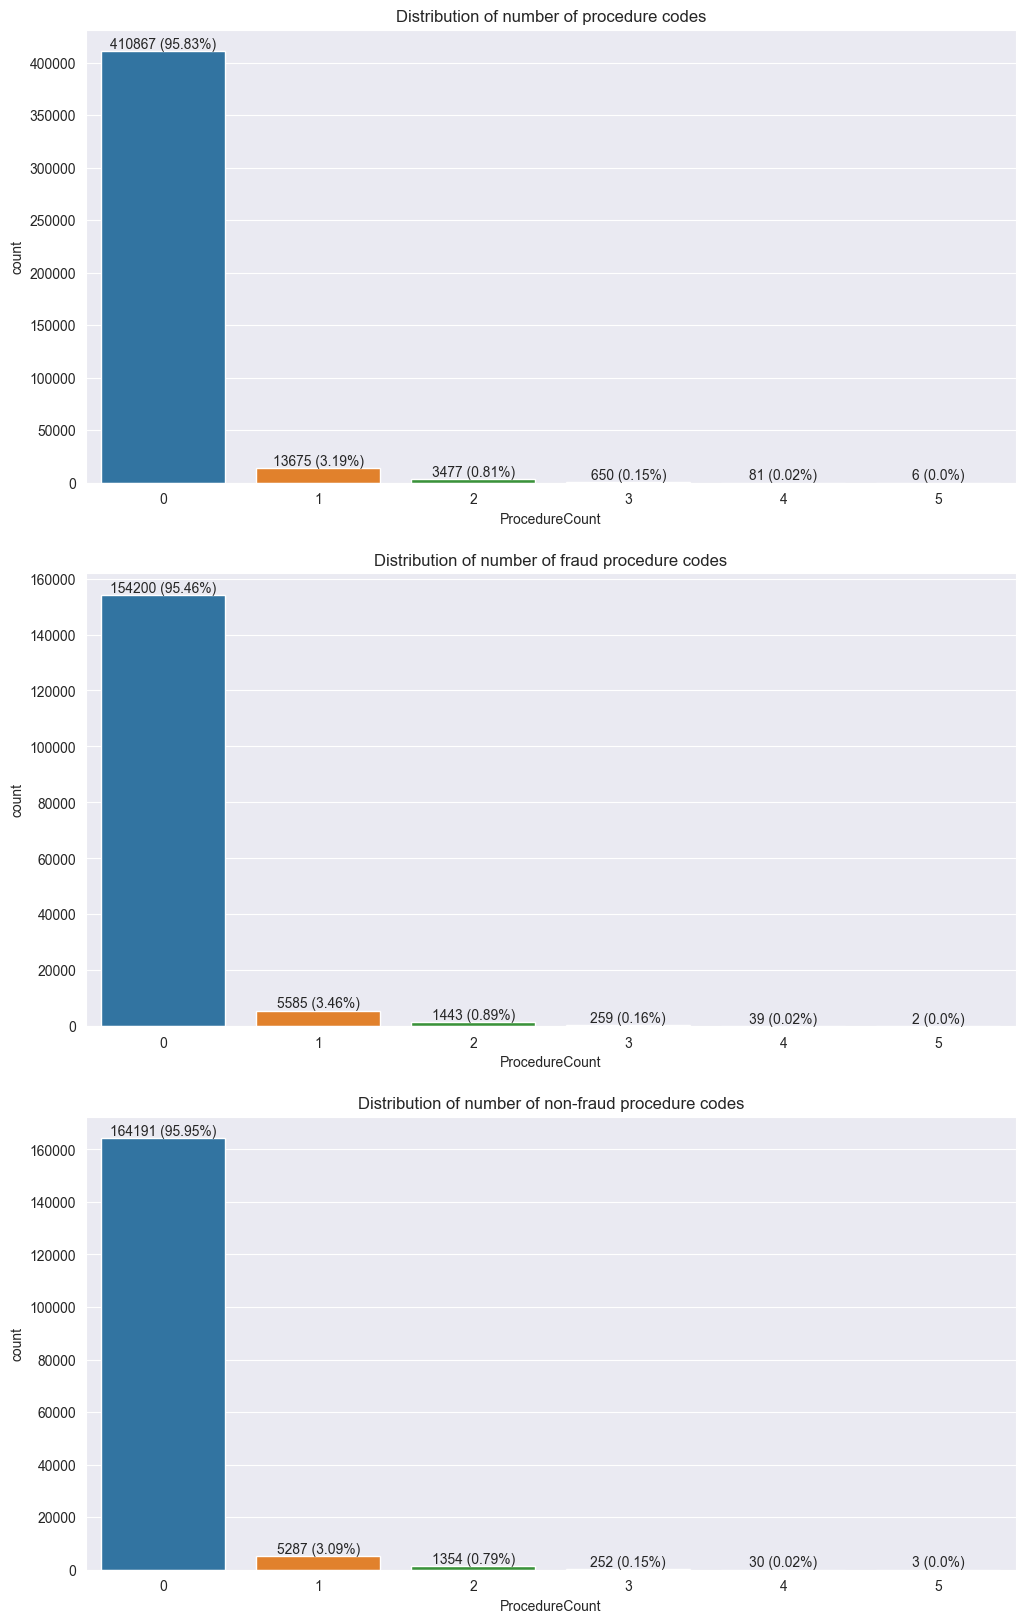

In [96]:
fig, (ax1, ax2, ax3) = pyplot.subplots(3,1,figsize=(12, 20))
sns.countplot(ax = ax1, x = all_patient['ProcedureCount'], order=all_patient.ProcedureCount.value_counts().sort_index().index)
ax1.set_title("Distribution of number of procedure codes")
abs_values = all_patient['ProcedureCount'].value_counts().sort_index().values
lab = []
for h in abs_values:
  percent = str(round((h/all_patient.shape[0])*100,2)) + "%"
  label = str(h) + " (" + percent + ")"
  lab.append(label)
ax1.bar_label(container=ax1.containers[0], labels=lab)

sns.countplot(ax = ax2, x = fraud_patient['ProcedureCount'], order=fraud_patient.ProcedureCount.value_counts().sort_index().index)
ax2.set_title("Distribution of number of fraud procedure codes")
abs_values = fraud_patient['ProcedureCount'].value_counts().sort_index().values
lab = []
for i in abs_values:
  percent = str(round((i/fraud_patient.shape[0])*100,2)) + "%"
  label = str(i) + " (" + percent + ")"
  lab.append(label)
ax2.bar_label(container=ax2.containers[0], labels=lab)

sns.countplot(ax = ax3, x = nonfraud_patient['ProcedureCount'], order=nonfraud_patient.ProcedureCount.value_counts().sort_index().index)
ax3.set_title("Distribution of number of non-fraud procedure codes")
abs_values = nonfraud_patient['ProcedureCount'].value_counts().sort_index().values
lab = []
for j in abs_values:
  percent = str(round((j/nonfraud_patient.shape[0])*100,2)) + "%"
  label = str(j) + " (" + percent + ")"
  lab.append(label)
ax3.bar_label(container=ax3.containers[0], labels=lab)
fig.show()

From the count of procedures, we can see that the distribution is similar for fraud and non-fraud cases. Therefore this may not be a good indicator of fraud.

### Claim Duration Analysis

In [97]:
# Create Claim Duration Column for Non-Fraud
all_patient['ClaimStartDt'] = pd.to_datetime(all_patient['ClaimStartDt'], format="%Y-%m-%d")
all_patient['ClaimEndDt'] = pd.to_datetime(all_patient['ClaimEndDt'], format="%Y-%m-%d")
all_patient['Claim_Duration'] = (all_patient['ClaimEndDt'] - all_patient['ClaimStartDt']).dt.days
all_patient['Claim_Duration'].describe()

count    428756.000000
mean          1.726548
std           4.904672
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          36.000000
Name: Claim_Duration, dtype: float64

[]

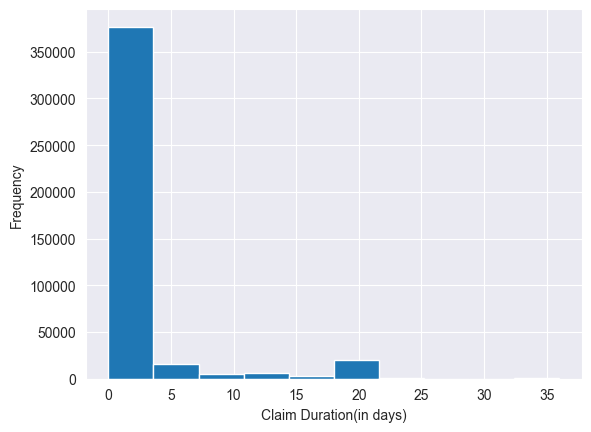

In [98]:
all_patient['Claim_Duration'].plot(kind='hist')
plt.xlabel("Claim Duration(in days)")
plt.plot()

In [99]:
# Create Claim Duration Column for Fraud
fraud_patient['ClaimStartDt'] = pd.to_datetime(fraud_patient['ClaimStartDt'], format="%Y-%m-%d")
fraud_patient['ClaimEndDt'] = pd.to_datetime(fraud_patient['ClaimEndDt'], format="%Y-%m-%d")
fraud_patient['Claim_Duration'] = (fraud_patient['ClaimEndDt'] - fraud_patient['ClaimStartDt']).dt.days
fraud_patient['Claim_Duration'].describe()

count    161528.000000
mean          1.744663
std           4.911310
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          36.000000
Name: Claim_Duration, dtype: float64

[]

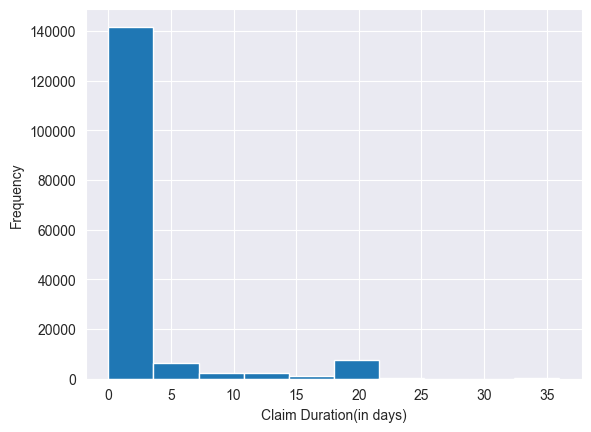

In [100]:
fraud_patient['Claim_Duration'].plot(kind='hist')
plt.xlabel("Claim Duration(in days)")
plt.plot()

From the plot, Claim Duration Distribution is similar for fraud and non fraud patients. Hence, Claim Duration is not significant for prediction and can be ommitted.

### Admitted Duration Analysis

In [101]:
# Create Admitted Duration Column for Non-Fraud
all_patient['AdmissionDt'] = pd.to_datetime(all_patient['AdmissionDt'], format="%Y-%m-%d")
all_patient['DischargeDt'] = pd.to_datetime(all_patient['DischargeDt'], format="%Y-%m-%d")
all_patient['Admission_Duration'] = (all_patient['DischargeDt'] - all_patient['AdmissionDt']).dt.days
all_patient['Admission_Duration'].describe()

count    30916.000000
mean         5.673470
std          5.644629
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         35.000000
Name: Admission_Duration, dtype: float64

[]

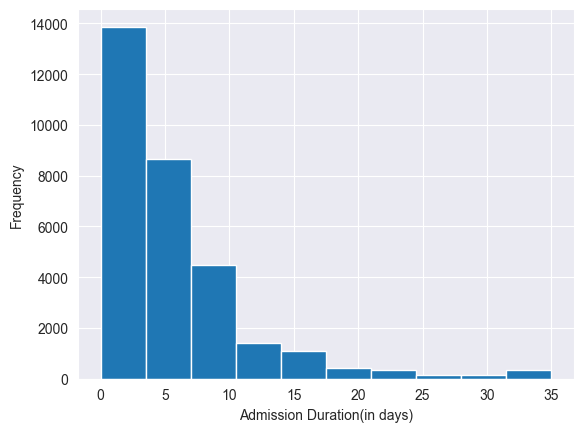

In [102]:
all_patient['Admission_Duration'].plot(kind='hist')
plt.xlabel("Admission Duration(in days)")
plt.plot()

In [103]:
# Create Admitted Duration Column for Non-Fraud
fraud_patient['AdmissionDt'] = pd.to_datetime(fraud_patient['AdmissionDt'], format="%Y-%m-%d")
fraud_patient['DischargeDt'] = pd.to_datetime(fraud_patient['DischargeDt'], format="%Y-%m-%d")
fraud_patient['Admission_Duration'] = (fraud_patient['DischargeDt'] - fraud_patient['AdmissionDt']).dt.days
fraud_patient['Admission_Duration'].describe()

count    12715.000000
mean         5.680613
std          5.653474
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         35.000000
Name: Admission_Duration, dtype: float64

[]

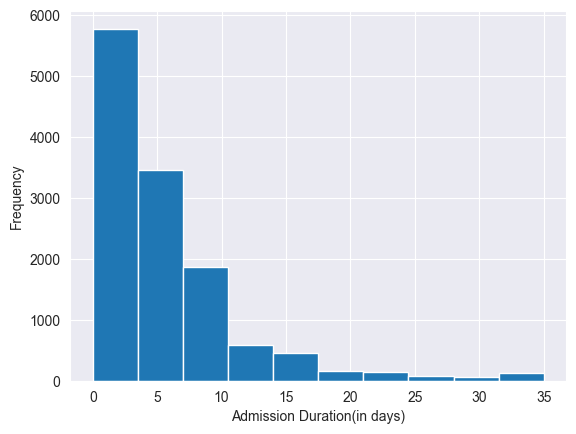

In [104]:
fraud_patient['Admission_Duration'].plot(kind='hist')
plt.xlabel("Admission Duration(in days)")
plt.plot()

In [105]:
# merge beneficiary data with inpatient and outpatient
new_all_patient = pd.merge(df_beneficiary, all_patient, on='BeneID')
new_all_patient['fraud?'] = 0
new_fraud_patient = pd.merge(df_beneficiary, fraud_patient, on='BeneID')
new_fraud_patient['fraud?'] = 1

In [106]:
new_all_patient = new_all_patient.append(new_fraud_patient)
new_all_patient.shape

C:\Users\Tarci\AppData\Local\Temp\ipykernel_14484\4198547678.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_all_patient = new_all_patient.append(new_fraud_patient)


(590284, 64)

<AxesSubplot: title={'center': 'Admission_Duration'}, xlabel='[fraud?, Gender]'>

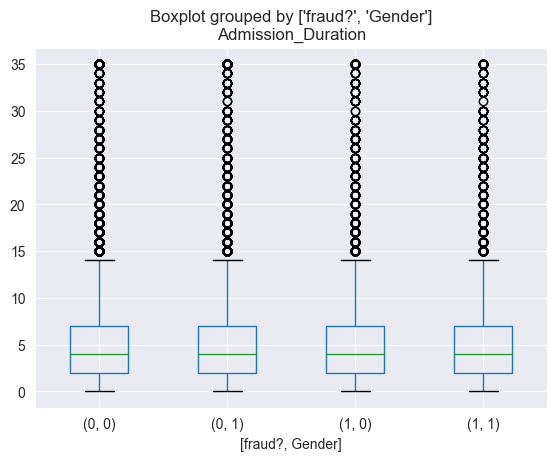

In [107]:
new_all_patient.boxplot(column = 'Admission_Duration', by=['fraud?','Gender'] )

From the plot, Admission Duration Distribution is similar for fraud and non fraud patients and also across gender. Hence, Admission Duration is not significant for prediction and can be ommitted.

# Perform Transformation on Entire Train and Test Data for Modelling



Drop Provider as it is directly related to fraud, ClaimID as it is unique for each row and BeneID as we are trying to predict if the physician will commit fraud. Convert Renal and Chronic Columns

Creating Age and Age buckets variables

In [108]:
X_train_final['DOB'] = pd.to_datetime(X_train_final['DOB'] , format = '%Y-%m-%d')
X_train_final['DOD'] = pd.to_datetime(X_train_final['DOD'],format = '%Y-%m-%d',errors='ignore')
X_train_final['Age'] = round(((X_train_final['DOD'] - X_train_final['DOB']).dt.days)/365,0)
X_train_final.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - X_train_final['DOB']).dt.days)/365,0), inplace=True)
X_train_final['age_buckets'] = X_train_final['Age'].apply(lambda x: age_buckets(x))
X_train_final = X_train_final.drop(['DOB', 'DOD'], axis=1)

X_test_final['DOB'] = pd.to_datetime(X_test_final['DOB'] , format = '%Y-%m-%d')
X_test_final['DOD'] = pd.to_datetime(X_test_final['DOD'],format = '%Y-%m-%d',errors='ignore')
X_test_final['Age'] = round(((X_test_final['DOD'] - X_test_final['DOB']).dt.days)/365,0)
X_test_final.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - X_test_final['DOB']).dt.days)/365,0), inplace=True)
X_test_final['age_buckets'] = X_test_final['Age'].apply(lambda x: age_buckets(x))
X_test_final = X_test_final.drop(['DOB', 'DOD'], axis=1)


Create variable to identify patients with no chronic kidney conditions but with renal disease which are suspicous

In [109]:
X_train_final['have_renal_no_kidney'] = np.where(np.logical_and(X_train_final.RenalDiseaseIndicator == 1, X_train_final.ChronicCond_KidneyDisease == 0), 1, 0)
X_test_final['have_renal_no_kidney'] = np.where(np.logical_and(X_test_final.RenalDiseaseIndicator == 1, X_test_final.ChronicCond_KidneyDisease == 0), 1, 0)

Calculate Health Score

In [110]:
X_train_final['Health_Score'] = X_train_final['ChronicCond_Alzheimer'] + X_train_final['ChronicCond_Heartfailure'] + \
                                        X_train_final['ChronicCond_KidneyDisease'] + X_train_final['ChronicCond_Cancer'] +\
                                        X_train_final['ChronicCond_ObstrPulmonary'] + X_train_final['ChronicCond_Depression'] +\
                                    X_train_final['ChronicCond_Diabetes'] + X_train_final['ChronicCond_IschemicHeart'] +\
                                    X_train_final['ChronicCond_Osteoporasis'] + X_train_final['ChronicCond_rheumatoidarthritis'] +\
                                    X_train_final['ChronicCond_stroke'] + X_train_final['RenalDiseaseIndicator'] 
X_train_final = X_train_final.drop(['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 
                          'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                          'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 
                          'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'RenalDiseaseIndicator'], axis=1)

X_test_final['Health_Score'] = X_test_final['ChronicCond_Alzheimer'] + X_test_final['ChronicCond_Heartfailure'] + \
                                        X_test_final['ChronicCond_KidneyDisease'] + X_test_final['ChronicCond_Cancer'] +\
                                        X_test_final['ChronicCond_ObstrPulmonary'] + X_test_final['ChronicCond_Depression'] +\
                                    X_test_final['ChronicCond_Diabetes'] + X_test_final['ChronicCond_IschemicHeart'] +\
                                    X_test_final['ChronicCond_Osteoporasis'] + X_test_final['ChronicCond_rheumatoidarthritis'] +\
                                    X_test_final['ChronicCond_stroke'] + X_test_final['RenalDiseaseIndicator'] 
X_test_final = X_test_final.drop(['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 
                          'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                          'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 
                          'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'RenalDiseaseIndicator'], axis=1)


Calculate Claim and Admission Duration

In [111]:
X_train_final['ClaimStartDt'] = pd.to_datetime(X_train_final['ClaimStartDt'], format="%Y-%m-%d")
X_train_final['ClaimEndDt'] = pd.to_datetime(X_train_final['ClaimEndDt'], format="%Y-%m-%d")
X_train_final['Claim_Duration'] = (X_train_final['ClaimEndDt'] - X_train_final['ClaimStartDt']).dt.days

X_train_final['AdmissionDt'] = pd.to_datetime(X_train_final['AdmissionDt'], format="%Y-%m-%d")
X_train_final['DischargeDt'] = pd.to_datetime(X_train_final['DischargeDt'], format="%Y-%m-%d")
X_train_final['Admission_Duration'] = (X_train_final['DischargeDt'] - X_train_final['AdmissionDt']).dt.days
X_train_final = X_train_final.drop(['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt'], axis = 1)

X_test_final['ClaimStartDt'] = pd.to_datetime(X_test_final['ClaimStartDt'], format="%Y-%m-%d")
X_test_final['ClaimEndDt'] = pd.to_datetime(X_test_final['ClaimEndDt'], format="%Y-%m-%d")
X_test_final['Claim_Duration'] = (X_test_final['ClaimEndDt'] - X_test_final['ClaimStartDt']).dt.days

X_test_final['AdmissionDt'] = pd.to_datetime(X_test_final['AdmissionDt'], format="%Y-%m-%d")
X_test_final['DischargeDt'] = pd.to_datetime(X_test_final['DischargeDt'], format="%Y-%m-%d")
X_test_final['Admission_Duration'] = (X_test_final['DischargeDt'] - X_test_final['AdmissionDt']).dt.days
X_test_final = X_test_final.drop(['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt'], axis = 1)


In [112]:
X_train_final.columns

Index(['index', 'InscClaimAmtReimbursed', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
       'Gender', 'Race', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'Age', 'age_buckets', 'have_renal_no_kidney',
       'Health_Score', 'Claim_Duration', 'Admission_Duration'],
      dtype='object')

In [113]:
X_train_final.dtypes

index                         int64
InscClaimAmtReimbursed        int64
ClmAdmitDiagnosisCode        object
DeductibleAmtPaid           float64
DiagnosisGroupCode           object
ClmDiagnosisCode_1           object
ClmDiagnosisCode_2           object
ClmDiagnosisCode_3           object
ClmDiagnosisCode_4           object
ClmDiagnosisCode_5           object
ClmDiagnosisCode_6           object
ClmDiagnosisCode_7           object
ClmDiagnosisCode_8           object
ClmDiagnosisCode_9           object
ClmDiagnosisCode_10          object
ClmProcedureCode_1          float64
ClmProcedureCode_2          float64
ClmProcedureCode_3          float64
ClmProcedureCode_4          float64
ClmProcedureCode_5          float64
ClmProcedureCode_6          float64
Gender                        int64
Race                          int64
State                         int64
County                        int64
NoOfMonths_PartACov           int64
NoOfMonths_PartBCov           int64
IPAnnualReimbursementAmt    

In [114]:
cat_columns = ['ClmAdmitDiagnosisCode', 'DiagnosisGroupCode', 'age_buckets',
               'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'Race', 'State', 'County']
num_columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'NoOfMonths_PartACov', 
               'NoOfMonths_PartBCov', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
               'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Health_Score', 
               'Claim_Duration', 'Admission_Duration']

## Scaling of numerical variables

In [115]:
for cat in num_columns:
  X_train_final[cat] = X_train_final[cat].fillna(X_train_final[cat].median())
  X_test_final[cat] = X_test_final[cat].fillna(X_test_final[cat].median())

scaler = MinMaxScaler()
X_train_final[num_columns] = scaler.fit_transform(X_train_final[num_columns])
X_test_final[num_columns] = scaler.fit_transform(X_test_final[num_columns])

## One hot encoding of categorical variables

### Reduce number of categories in each variable for encoding

In [116]:
for cat in cat_columns:
  top_10 = [var for var in X_train_final[cat].value_counts().sort_values(ascending = False).head(10).index]
  X_train_final[cat] = np.where(np.logical_or((X_train_final[cat].isin(top_10)), X_train_final[cat].isna()), X_train_final[cat], 'Others')
  #convert columns to string
  X_train_final[cat] = X_train_final[cat].astype(str)
  X_test_final[cat] = X_test_final[cat].astype(str)
  print(cat)
  print(X_train_final[cat].value_counts())

ClmAdmitDiagnosisCode
nan       316916
Others     92107
V7612       3123
42731       2786
78605       2252
4019        2118
25000       1801
78900       1762
78650       1736
7295        1409
V5883       1400
78079       1346
Name: ClmAdmitDiagnosisCode, dtype: int64
DiagnosisGroupCode
nan       397840
Others     29656
183          136
882          134
166          129
884          126
876          124
883          123
204          123
945          122
167          122
949          121
Name: DiagnosisGroupCode, dtype: int64
age_buckets
3    278059
4     82313
2     52580
1     15804
Name: age_buckets, dtype: int64
ClmDiagnosisCode_1
Others    382455
4019       10632
4011        9640
nan         8073
2724        2787
2720        2452
2722        2318
2721        2303
2723        2261
42731       2017
78659       2005
78650       1813
Name: ClmDiagnosisCode_1, dtype: int64
ClmDiagnosisCode_2
Others    209476
nan       150219
4019       17251
25000       9033
2724        8682
V5861       

### One Hot Encoding

In [117]:
X_test.shape

(129455, 55)

In [118]:
X_train.shape

(428756, 55)

In [119]:
X_test.dtypes

index                                int64
BeneID                              object
ClaimID                             object
ClaimStartDt                        object
ClaimEndDt                          object
Provider                            object
InscClaimAmtReimbursed               int64
AttendingPhysician                  object
OperatingPhysician                  object
OtherPhysician                      object
AdmissionDt                         object
ClmAdmitDiagnosisCode               object
DeductibleAmtPaid                  float64
DischargeDt                         object
DiagnosisGroupCode                  object
ClmDiagnosisCode_1                  object
ClmDiagnosisCode_2                  object
ClmDiagnosisCode_3                  object
ClmDiagnosisCode_4                  object
ClmDiagnosisCode_5                  object
ClmDiagnosisCode_6                  object
ClmDiagnosisCode_7                  object
ClmDiagnosisCode_8                  object
ClmDiagnosi

In [120]:
X_train.dtypes

index                                int64
BeneID                              object
ClaimID                             object
ClaimStartDt                        object
ClaimEndDt                          object
Provider                            object
InscClaimAmtReimbursed               int64
AttendingPhysician                  object
OperatingPhysician                  object
OtherPhysician                      object
AdmissionDt                         object
ClmAdmitDiagnosisCode               object
DeductibleAmtPaid                  float64
DischargeDt                         object
DiagnosisGroupCode                  object
ClmDiagnosisCode_1                  object
ClmDiagnosisCode_2                  object
ClmDiagnosisCode_3                  object
ClmDiagnosisCode_4                  object
ClmDiagnosisCode_5                  object
ClmDiagnosisCode_6                  object
ClmDiagnosisCode_7                  object
ClmDiagnosisCode_8                  object
ClmDiagnosi

In [121]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')  # ignores new categories in test set
for cat in cat_columns:
  print(f"Current shape: {X_train_final.shape}")
  print(f"Current shape: {X_test_final.shape}")
  one_hot_encoder.fit(X_train_final[[cat]])  # fit to training set only

  enc_train = one_hot_encoder.transform(X_train_final[[cat]]).toarray()
  enc_train_df = pd.DataFrame(enc_train, columns=one_hot_encoder.get_feature_names_out([cat])).astype(int)
  X_train_final = pd.concat([X_train_final, enc_train_df], axis='columns').drop(columns=[cat])

  enc_test = one_hot_encoder.transform(X_test_final[[cat]]).toarray()
  enc_test_df = pd.DataFrame(enc_test, columns=one_hot_encoder.get_feature_names_out([cat])).astype(int)
  X_test_final = pd.concat([X_test_final, enc_test_df], axis='columns').drop(columns=[cat])


Current shape: (428756, 37)
Current shape: (129455, 37)
Current shape: (428756, 48)
Current shape: (129455, 48)
Current shape: (428756, 59)
Current shape: (129455, 59)
Current shape: (428756, 62)
Current shape: (129455, 62)
Current shape: (428756, 73)
Current shape: (129455, 73)
Current shape: (428756, 84)
Current shape: (129455, 84)
Current shape: (428756, 95)
Current shape: (129455, 95)
Current shape: (428756, 106)
Current shape: (129455, 106)
Current shape: (428756, 117)
Current shape: (129455, 117)
Current shape: (428756, 128)
Current shape: (129455, 128)
Current shape: (428756, 139)
Current shape: (129455, 139)
Current shape: (428756, 150)
Current shape: (129455, 150)
Current shape: (428756, 161)
Current shape: (129455, 161)
Current shape: (428756, 172)
Current shape: (129455, 172)
Current shape: (428756, 183)
Current shape: (129455, 183)
Current shape: (428756, 194)
Current shape: (129455, 194)
Current shape: (428756, 205)
Current shape: (129455, 205)
Current shape: (428756, 216)

# Modelling

## Define methods for models

In [122]:
X_train_final.drop(columns=['index'],inplace=True)
X_test_final.drop(columns=['index'],inplace=True)

In [123]:
def evaluate_recall_score(features_train, target_train, classifier, kfold_splits=2):

    all_y_pred = []  # predicted values
    all_y_true = []  # ground truth

    kf = StratifiedKFold(n_splits=kfold_splits)

    for train_index, val_index in kf.split(features_train, target_train):

        # get the training and validation set for this particular fold
        x_train, x_val = features_train.iloc[train_index], features_train.iloc[val_index]
        y_train, y_val_true = target_train[train_index], target_train[val_index]

        # fit model to training set, then predict on validation set
        y_val_pred = classifier.fit(x_train, y_train).predict(x_val)

        all_y_pred.extend(y_val_pred)
        all_y_true.extend(y_val_true)

    return recall_score(all_y_true, all_y_pred)

def param_opt(features_train, target_train, classifier_without_param, params_space, num_eval = 50):

    def objective_function(params):
        classifier = classifier_without_param(**params, random_state=random_num)
        score = evaluate_recall_score(features_train, target_train, classifier)
        return {'loss': -score, 'status': STATUS_OK}

    best_params = fmin(
        fn=objective_function,
        space=params_space,
        algo=tpe.suggest,
        max_evals = num_eval,
        rstate=np.random.default_rng(random_num)
    )

    return space_eval(params_space, best_params)
num_features = X_train_final.shape[1]

## Baseline Model (Logistic Regression)

Convert target variable to 1 if yes and 0 if no

In [124]:
y_train = y_train.map(dict(Yes=1, No=0)).reset_index()['PotentialFraud']
y_test = y_test.map(dict(Yes=1, No=0)).reset_index()['PotentialFraud']
y_train.value_counts()

0    257005
1    171751
Name: PotentialFraud, dtype: int64

In [125]:
X_train_final.shape

(428756, 242)

In [128]:
X_test_final.shape

(129455, 242)

## Logistic Regression

In [130]:
lr_params_space = {
    'penalty': hp.choice('penalty', ['none', 'l2']),
    "max_iter": scope.int(hp.quniform('max_iter', 1000, 10000, 100)),
    "fit_intercept": hp.choice('fit_intercept', [True, False])
}
lr_params_dict = param_opt(X_train_final, y_train, linear_model.LogisticRegression, lr_params_space)
lr_final_model = linear_model.LogisticRegression(**lr_params_dict, random_state=random_num).fit(X_train_final, y_train)

100%|██████████| 50/50 [33:34<00:00, 40.28s/trial, best loss: -0.2734947685894114]


In [131]:
print(f"Best Params: {lr_params_dict}")

Best Params: {'fit_intercept': False, 'max_iter': 4500, 'penalty': 'l2'}


In [132]:
lr_model = linear_model.LogisticRegression(fit_intercept=True, solver = 'liblinear').fit(X_train_final, y_train)
lr_pred = lr_model.predict(X_test_final)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = metrics.f1_score(y_test,lr_pred)
print(f"Recall: {lr_recall}")
print(f"F1: {lr_f1}")

Recall: 0.4005359970763796
F1: 0.43333860509251937


# Improved Models

## Random Forest

In [133]:
rfc_params_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 100, 5)),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': scope.int(hp.quniform('max_depth', floor(num_features * 0.25), ceil(num_features * 0.75), 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 20, 300, 10)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 10, 100, 10)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 0.1)
    }

rfc_params_dict = param_opt(X_train_final, y_train, RandomForestClassifier, rfc_params_space)
rfc_final_model = RandomForestClassifier(**rfc_params_dict, random_state=random_num).fit(X_train_final, y_train)

100%|██████████| 50/50 [22:47<00:00, 27.35s/trial, best loss: -0.2929648153431421] 


In [134]:
print(f"Best Params: {rfc_params_dict}")

Best Params: {'criterion': 'entropy', 'max_depth': 94, 'max_features': None, 'min_impurity_decrease': 0.002375889554021544, 'min_samples_leaf': 80, 'min_samples_split': 300, 'n_estimators': 40}


In [135]:
rfc_pred = rfc_final_model.predict(X_test_final)
rfc_recall = recall_score(y_test, rfc_pred)
rfc_f1 = metrics.f1_score(y_test,rfc_pred)
print(f"Recall: {rfc_recall}")
print(f"F1: {rfc_f1}")

Recall: 0.13511999025459862
F1: 0.21559213978891717


## Decision Tree

In [126]:
dt_params_space = {
    
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': scope.int(hp.quniform('max_depth', floor(num_features * 0.25), ceil(num_features * 0.75), 1)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]) ,
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 0.1),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 10, 100, 10)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 40, 1)),

    }

dt_params_dict = param_opt(X_train_final, y_train, DecisionTreeClassifier, dt_params_space)
dt_final_model = DecisionTreeClassifier(**dt_params_dict, random_state=random_num).fit(X_train_final, y_train)

100%|██████████| 50/50 [01:36<00:00,  1.92s/trial, best loss: -0.31998649207282637]


In [127]:
print(f"Best Params: {dt_params_dict}")

Best Params: {'criterion': 'gini', 'max_depth': 139, 'max_features': None, 'min_impurity_decrease': 0.0020642401929972863, 'min_samples_leaf': 10, 'min_samples_split': 34}


In [128]:
dt_pred = dt_final_model.predict(X_test_final)
dt_recall = recall_score(y_test, dt_pred)
dt_auc = metrics.roc_auc_score(y_test, dt_pred)
dt_f1 = metrics.f1_score(y_test,dt_pred)
print(f"Recall: {dt_recall}")
print(f"F1 : {dt_f1}")
print(f"AUC: {dt_auc}")

Recall: 0.272457059325131
F1 : 0.36162850860173334
AUC: 0.5818229194374779


In [129]:
#evaluate recall  score on validation set
evaluate_recall_score(X_train_final, y_train, dt_final_model, kfold_splits=2)

0.31998649207282637

In [140]:
y_pred = dt_final_model.predict(X_test_final)
print('Recall score (Decision Tree): ', recall_score(y_test, y_pred))
print('ROC AUC score (Decision Tree): ', metrics.roc_auc_score(y_test, y_pred))
print('F1 score (Decision Tree): ', metrics.f1_score(y_test, y_pred))

Recall score (Decision Tree):  0.2945060299671093
ROC AUC score (Decision Tree):  0.5744954083779671
F1 score (Decision Tree):  0.36631413073123426


In [141]:
X_train_final.columns

Index(['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'Gender',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
       ...
       'County_10', 'County_150', 'County_160', 'County_20', 'County_200',
       'County_250', 'County_470', 'County_60', 'County_90', 'County_Others'],
      dtype='object', length=242)

[Text(0.5555555555555556, 0.875, 'State_5 <= 0.5\ngini = 0.48\nsamples = 214378\nvalue = [128502, 85876]'),
 Text(0.3333333333333333, 0.625, 'State_33 <= 0.5\ngini = 0.463\nsamples = 189661\nvalue = [120693, 68968]'),
 Text(0.2222222222222222, 0.375, 'DiagnosisGroupCode_nan <= 0.5\ngini = 0.453\nsamples = 171752\nvalue = [112287, 59465]'),
 Text(0.1111111111111111, 0.125, 'gini = 0.492\nsamples = 10644\nvalue = [4638, 6006]'),
 Text(0.3333333333333333, 0.125, 'gini = 0.443\nsamples = 161108\nvalue = [107649, 53459]'),
 Text(0.4444444444444444, 0.375, 'gini = 0.498\nsamples = 17909\nvalue = [8406, 9503]'),
 Text(0.7777777777777778, 0.625, 'County_Others <= 0.5\ngini = 0.432\nsamples = 24717\nvalue = [7809, 16908]'),
 Text(0.6666666666666666, 0.375, 'County_0 <= 0.5\ngini = 0.303\nsamples = 15153\nvalue = [2823, 12330]'),
 Text(0.5555555555555556, 0.125, 'gini = 0.251\nsamples = 14430\nvalue = [2128, 12302]'),
 Text(0.7777777777777778, 0.125, 'gini = 0.074\nsamples = 723\nvalue = [695, 2

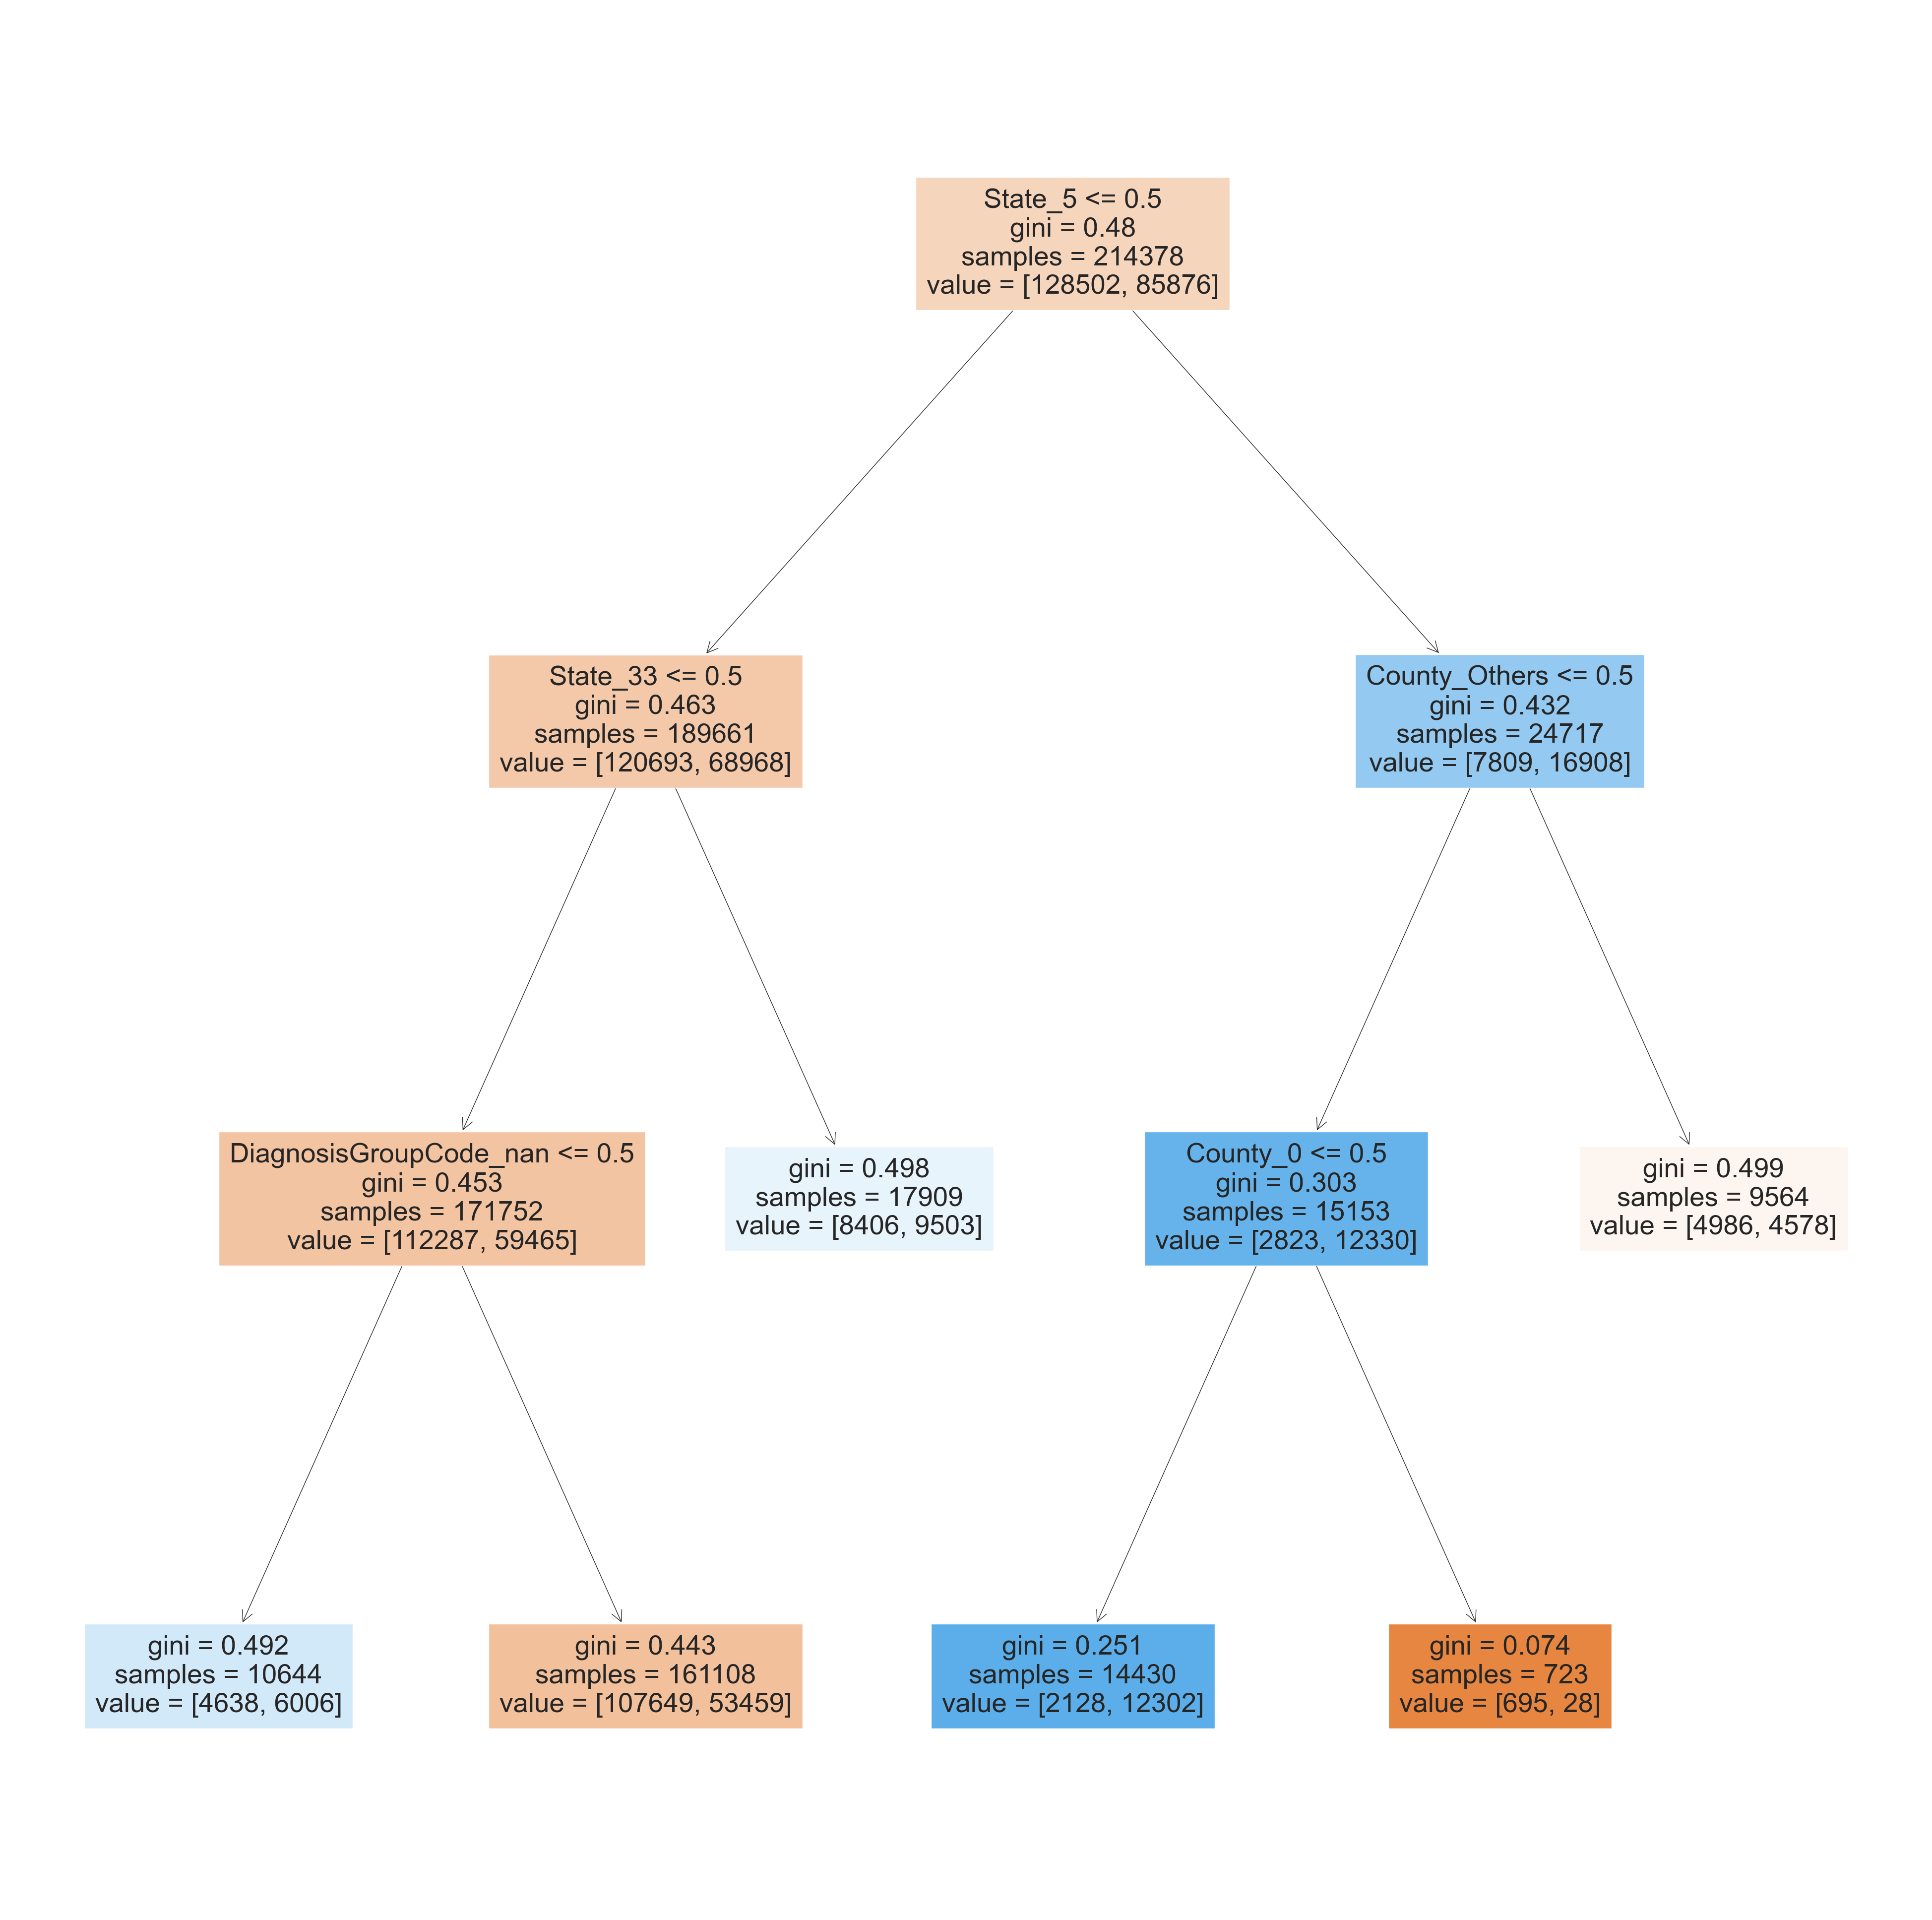

In [142]:
from sklearn.tree import plot_tree, export_text
plt.figure(figsize =(50,50))

plot_tree(dt_final_model, feature_names=X_train_final.columns, max_depth=10, filled=True)

## XGBoost

In [143]:
xgb_params_space={'max_depth': scope.int(hp.quniform("max_depth", 3, 18, 1)),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
}

xgb_params_dict = param_opt(X_train_final, y_train, XGBClassifier, xgb_params_space)
xgb_final_model = XGBClassifier(**xgb_params_dict, random_state=random_num).fit(X_train_final, y_train)

100%|██████████| 50/50 [1:10:44<00:00, 84.89s/trial, best loss: -0.2652560974899709] 


In [144]:
print(f"Best Params: {xgb_params_dict}")

Best Params: {'colsample_bytree': 0.6824801411657254, 'gamma': 6.811609610774132, 'max_depth': 18, 'min_child_weight': 1.0, 'n_estimators': 180, 'reg_alpha': 170.0, 'reg_lambda': 0.9698996314783409, 'seed': 0}


In [145]:
xgb_pred = xgb_final_model.predict(X_test_final)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = metrics.f1_score(y_test,xgb_pred)
print(f"Recall: {xgb_recall}")
print(f"F1: {xgb_f1}")

Recall: 0.31377756121330247
F1: 0.40581673808923624


## Neural Networks

In [161]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [165]:
# Baseline Model as a benchmark

basemodel = Sequential()
basemodel.add(keras.Input(shape=(242,)))
basemodel.add(layers.Dense(50, activation= 'relu'))
basemodel.add(layers.Dense(20, activation='relu'))
basemodel.add(layers.Dense(1, activation='sigmoid'))
basemodel.compile(optimizer='adam',loss='binary_crossentropy',metrics=[get_f1,keras.metrics.Precision(),keras.metrics.Recall()])
basemodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                12150     
                                                                 
 dense_7 (Dense)             (None, 20)                1020      
                                                                 
 dense_8 (Dense)             (None, 1)                 21        
                                                                 
Total params: 13,191
Trainable params: 13,191
Non-trainable params: 0
_________________________________________________________________


In [166]:
early_stop=EarlyStopping(monitor='loss', restore_best_weights= True, patience=10, verbose=1)
callback = [early_stop]
history_basemodel = basemodel.fit(X_train_final, y_train, epochs=30, batch_size=200, callbacks = callback)

Epoch 1/30
2144/2144 [==============================] - 5s 2ms/step - loss: 0.6473 - get_f1: 0.3799 - precision_1: 0.5748 - recall_1: 0.3033
Epoch 2/30
2144/2144 [==============================] - 4s 2ms/step - loss: 0.6397 - get_f1: 0.4311 - precision_1: 0.5866 - recall_1: 0.3526
Epoch 3/30
2144/2144 [==============================] - 5s 2ms/step - loss: 0.6366 - get_f1: 0.4412 - precision_1: 0.5908 - recall_1: 0.3627
Epoch 4/30
2144/2144 [==============================] - 4s 2ms/step - loss: 0.6347 - get_f1: 0.4478 - precision_1: 0.5949 - recall_1: 0.3686
Epoch 5/30
2144/2144 [==============================] - 5s 2ms/step - loss: 0.6339 - get_f1: 0.4516 - precision_1: 0.5954 - recall_1: 0.3730
Epoch 6/30
2144/2144 [==============================] - 5s 2ms/step - loss: 0.6324 - get_f1: 0.4570 - precision_1: 0.5977 - recall_1: 0.3780
Epoch 7/30
2144/2144 [==============================] - 4s 2ms/step - loss: 0.6314 - get_f1: 0.4585 - precision_1: 0.6006 - recall_1: 0.3773
Epoch 8/30
21

In [170]:
# Optimizing based on baseline model

def model_builder(hp):

    model = keras.Sequential()
    model.add(keras.Input(shape=(242,)))

    # Choose number of neurons for first layer between 10 - 200
    neurons = hp.Int('neurons', min_value=10, max_value=200, step=32)
    model.add(keras.layers.Dense(neurons, activation='relu'))

    model.add(keras.layers.Dense(20, activation = 'relu'))

    model.add(layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=[get_f1,keras.metrics.Precision(),keras.metrics.Recall()])

    return model

In [171]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("recall", direction="max"),
                     max_epochs=10,
                     factor=8)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json


In [172]:
tuner.search(X_train_final, y_train, epochs = 20, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('neurons')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 17 Complete [00h 03m 37s]
recall: 0.5312899947166443

Best recall So Far: 0.5312899947166443
Total elapsed time: 00h 22m 53s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 10 and the optimal learning rate for the optimizer
is 0.001.



In [177]:
best_hps

In [179]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_final, y_train, epochs=20, validation_split=0.2, callbacks=[stop_early])

Epoch 1/20
10719/10719 [==============================] - 21s 2ms/step - loss: 0.6639 - get_f1: 0.5243 - precision_5: 0.6072 - recall_5: 0.4869 - val_loss: 0.6436 - val_get_f1: 0.0498 - val_precision_5: 0.1144 - val_recall_5: 0.3378
Epoch 2/20
10719/10719 [==============================] - 19s 2ms/step - loss: 0.6556 - get_f1: 0.5440 - precision_5: 0.6229 - recall_5: 0.5009 - val_loss: 0.5958 - val_get_f1: 0.0402 - val_precision_5: 0.1143 - val_recall_5: 0.2396
Epoch 3/20
10719/10719 [==============================] - 17s 2ms/step - loss: 0.6515 - get_f1: 0.5562 - precision_5: 0.6271 - recall_5: 0.5163 - val_loss: 0.6442 - val_get_f1: 0.0495 - val_precision_5: 0.1231 - val_recall_5: 0.3410
Epoch 4/20
10719/10719 [==============================] - 18s 2ms/step - loss: 0.6490 - get_f1: 0.5564 - precision_5: 0.6305 - recall_5: 0.5143 - val_loss: 0.6052 - val_get_f1: 0.0470 - val_precision_5: 0.1203 - val_recall_5: 0.3024
Epoch 5/20
10719/10719 [==============================] - 17s 2ms/st

In [180]:
recall_per_epoch = history.history['recall_1']
best_epoch = recall_per_epoch.index(max(recall_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 7


In [181]:
hypermodel = tuner.hypermodel.build(best_hps)
# Retrain the model
hypermodel.fit(X_train_final, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/7
10719/10719 [==============================] - 23s 2ms/step - loss: 0.6635 - get_f1: 0.5161 - precision_6: 0.6097 - recall_6: 0.4740 - val_loss: 0.6334 - val_get_f1: 0.0461 - val_precision_6: 0.1122 - val_recall_6: 0.2932
Epoch 2/7
10719/10719 [==============================] - 21s 2ms/step - loss: 0.6553 - get_f1: 0.5395 - precision_6: 0.6212 - recall_6: 0.4954 - val_loss: 0.6084 - val_get_f1: 0.0461 - val_precision_6: 0.1261 - val_recall_6: 0.2932
Epoch 3/7
10719/10719 [==============================] - 21s 2ms/step - loss: 0.6512 - get_f1: 0.5475 - precision_6: 0.6287 - recall_6: 0.5031 - val_loss: 0.6210 - val_get_f1: 0.0474 - val_precision_6: 0.1191 - val_recall_6: 0.3097
Epoch 4/7
10719/10719 [==============================] - 20s 2ms/step - loss: 0.6480 - get_f1: 0.5555 - precision_6: 0.6321 - recall_6: 0.5123 - val_loss: 0.6569 - val_get_f1: 0.0505 - val_precision_6: 0.1174 - val_recall_6: 0.3469
Epoch 5/7
10719/10719 [==============================] - 21s 2ms/step - 

In [276]:
nn_pred = hypermodel.predict(X_test_final)
clf_threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for i in range(98,0,-2):
    test = (nn_pred>i/100)
    test_next = (nn_pred>(i-1)/100)
    curr_recall = recall_score(y_test, test)
    curr_accuracy = metrics.precision_score(y_test,test)

    if curr_accuracy < 0.4:
        print(f"Current Precision: {curr_accuracy} Current Recall: {curr_recall}")
        print(f" clf threshold: {i/100}")
        clf_threshold = i
        break

4046/4046 [==============================] - 4s 967us/step
Current Precision: 0.38547548948630084 Current Recall: 0.5837495431843099
 clf threshold: 0.52


In [277]:
nn_pred = (nn_pred>0.52)

In [280]:
print(f"Accuracy: {metrics.accuracy_score(y_test,nn_pred)}")
print(f"Precision: {metrics.precision_score(y_test,nn_pred)}")
print(f"Recall: {recall_score(y_test, nn_pred)}")
print(f"F1: {metrics.f1_score(y_test,nn_pred)}")

Accuracy: 0.5729635780773241
Precision: 0.38547548948630084
Recall: 0.5837495431843099
F1: 0.4643320865874692


## Neural Networks were found to be the best performing model giving us the best recall score on our test set.